# Preparation

Install the necessary packages:

In [1]:
! pip install numpy awkward vector uproot lz4 xxhash pandas matplotlib tqdm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.8/835.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 636.5/636.5 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.3/182.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.1/357.1 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 34.8 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import awkward as ak
import uproot
import matplotlib.pyplot as plt
import vector
vector.register_awkward()


Here defines some helper functions to visualize a jet:

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

typelist = ['ch+', 'ch-', 'nh', 'ph', 'el+', 'el-', 'mu+', 'mu-']


def make_subplot(ax, data, force_xylim=None):
    # default plotting configuration
    color_dict_ = {'ch': 'C0', 'nh': 'mediumpurple', 'ph': 'orange', 'el': 'red', 'mu': 'green'}
    color_dict = color_dict_.copy()
    color_dict.update({k + '+': color_dict_[k] for k in color_dict_})
    color_dict.update({k + '-': color_dict_[k] for k in color_dict_})
    if data.get('id') is None:
        data['id'] = ['default'] * len(data['pt'])
    if data.get('e') is None:
        for eta, phi, pt, id, d3d in zip(data['eta'], data['phi'], data['pt'], data['id'], data['d3d']):
            ptdraw = np.sqrt(pt) / 200
            alpha = 0.3
            if id in [4, 5]:
                ax.add_patch(mpl.patches.RegularPolygon((eta, phi), 3, radius=ptdraw, clip_on=True,
                                                        alpha=alpha, edgecolor='black', **make_color_args(id, d3d)))
            elif id in [6, 7]:
                ax.add_patch(mpl.patches.RegularPolygon((eta, phi), 3, radius=ptdraw, orientation=np.pi,
                                                        clip_on=True, alpha=alpha, edgecolor='black', **make_color_args(id, d3d)))
            elif id in [3]:
                ax.add_patch(mpl.patches.RegularPolygon((eta, phi), 5, radius=ptdraw,
                                                        clip_on=True, alpha=alpha, **make_color_args(id, d3d)))
            else:
                ax.add_patch(plt.Circle((eta, phi), ptdraw, clip_on=True, alpha=alpha, **make_color_args(id, d3d)))
    else:
        for eta, phi, pt, e, id, d3d in zip(data['eta'], data['phi'], data['pt'], data['e'], data['id'], data['d3d']):
            ax.add_patch(mpl.patches.Wedge((eta, phi), pt / 600., 90, 270,
                                           clip_on=True, alpha=alpha, **make_color_args(id, d3d)))
            ax.add_patch(mpl.patches.Wedge((eta, phi), e / 600., 270, 90,
                                           clip_on=True, alpha=alpha, **make_color_args(id, d3d)))
    max_ang = force_xylim if force_xylim else max(max(abs(data['eta'])), max(abs(data['phi'])))
    # make square plot centered at (0,0)
    ax.set_xlim(-max_ang, max_ang)
    ax.set_ylim(-max_ang, max_ang)
    ax.set_xlabel(r'$\Delta\eta$')
    ax.set_ylabel(r'$\Delta\phi$')
    ax.set_aspect('equal')
    return max_ang


def make_color_args(id, d3d):
    color = color_fader('#74c476', '#081d58', d3d)
    if id in [2, 3]:
        return {'edgecolor': color, 'linewidth': 1, 'fill': False}
    else:
        return {'facecolor': color}


def color_fader(c1, c2, mix=0):  # fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    mix = min(1., mix)
    c1 = np.array(mpl.colors.to_rgb(c1))
    c2 = np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1 - mix) * c1 + mix * c2)


def visualize(arrays, idx=0, title=None, ax=None):
    data = {}
    data['pt'] = np.hypot(arrays[idx].part_px, arrays[idx].part_py)
    data['eta'] = arrays[idx].part_deta
    data['phi'] = arrays[idx].part_dphi
    data['d3d'] = np.tanh(np.hypot(arrays[idx].part_d0val, arrays[idx].part_dzval))
    part_type = np.concatenate([
        [(arrays[idx].part_isChargedHadron) & (arrays[idx].part_charge == 1)],
        [(arrays[idx].part_isChargedHadron) & (arrays[idx].part_charge == -1)],
        [arrays[idx].part_isNeutralHadron],
        [arrays[idx].part_isPhoton],
        [(arrays[idx].part_isElectron) & (arrays[idx].part_charge == 1)],
        [(arrays[idx].part_isElectron) & (arrays[idx].part_charge == -1)],
        [(arrays[idx].part_isMuon) & (arrays[idx].part_charge == 1)],
        [(arrays[idx].part_isMuon) & (arrays[idx].part_charge == -1)],
    ], axis=0)
    data['id'] = np.argmax(part_type.T, axis=1)  # better

    assert len(data['eta'] == data['id'])
    if ax is None:
        _, ax = plt.subplots(figsize=(5, 5))
    make_subplot(ax, data, force_xylim=0.5)
    if title:
        ax.set_title(title)
    return ax


# Download the dataset

In [4]:
def download(url, fname, chunk_size=1024):
    '''https://gist.github.com/yanqd0/c13ed29e29432e3cf3e7c38467f42f51'''
    import requests
    from tqdm import tqdm

    if os.path.dirname(fname):
        os.makedirs(os.path.dirname(fname), exist_ok=True)

    resp = requests.get(url, stream=True)
    total = int(resp.headers.get('content-length', 0))
    with open(fname, 'wb') as file, tqdm(
        desc=fname,
        total=total,
        unit='iB',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=chunk_size):
            size = file.write(data)
            bar.update(size)


In [5]:
signal_file = './JetClassMini/TTBar_000.root'
background_file = './JetClassMini/ZJetsToNuNu_000.root'

if not os.path.exists(signal_file):
    download('https://hqu.web.cern.ch/datasets/JetClassMini/TTBar_000.root', signal_file)
if not os.path.exists(background_file):
    download('https://hqu.web.cern.ch/datasets/JetClassMini/ZJetsToNuNu_000.root', background_file)


./JetClassMini/TTBar_000.root: 100%|██████████| 183M/183M [00:07<00:00, 26.3MiB/s]
./JetClassMini/ZJetsToNuNu_000.root: 100%|██████████| 131M/131M [00:12<00:00, 11.4MiB/s]


# Explore the dataset


In [6]:
# Load the content from the file
signal_tree = uproot.open(signal_file)['tree']


In [7]:
# Display the content of the "tree"
signal_tree.show()


name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
part_px              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_py              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_pz              | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_energy          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_deta            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dphi            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_d0val           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_d0err           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dzval           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_dzerr           | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
part_charge          | std::

In [8]:
# Load all arrays in the tree
# Each array is a column of the table
signal_table = signal_tree.arrays()


In [9]:
signal_table


<Array [{part_px: [...], ...}, ..., {...}] type='100000 * {part_px: var * f...'>

In [10]:
background_table = uproot.open(background_file)['tree'].arrays()
background_table


<Array [{part_px: [...], ...}, ..., {...}] type='100000 * {part_px: var * f...'>

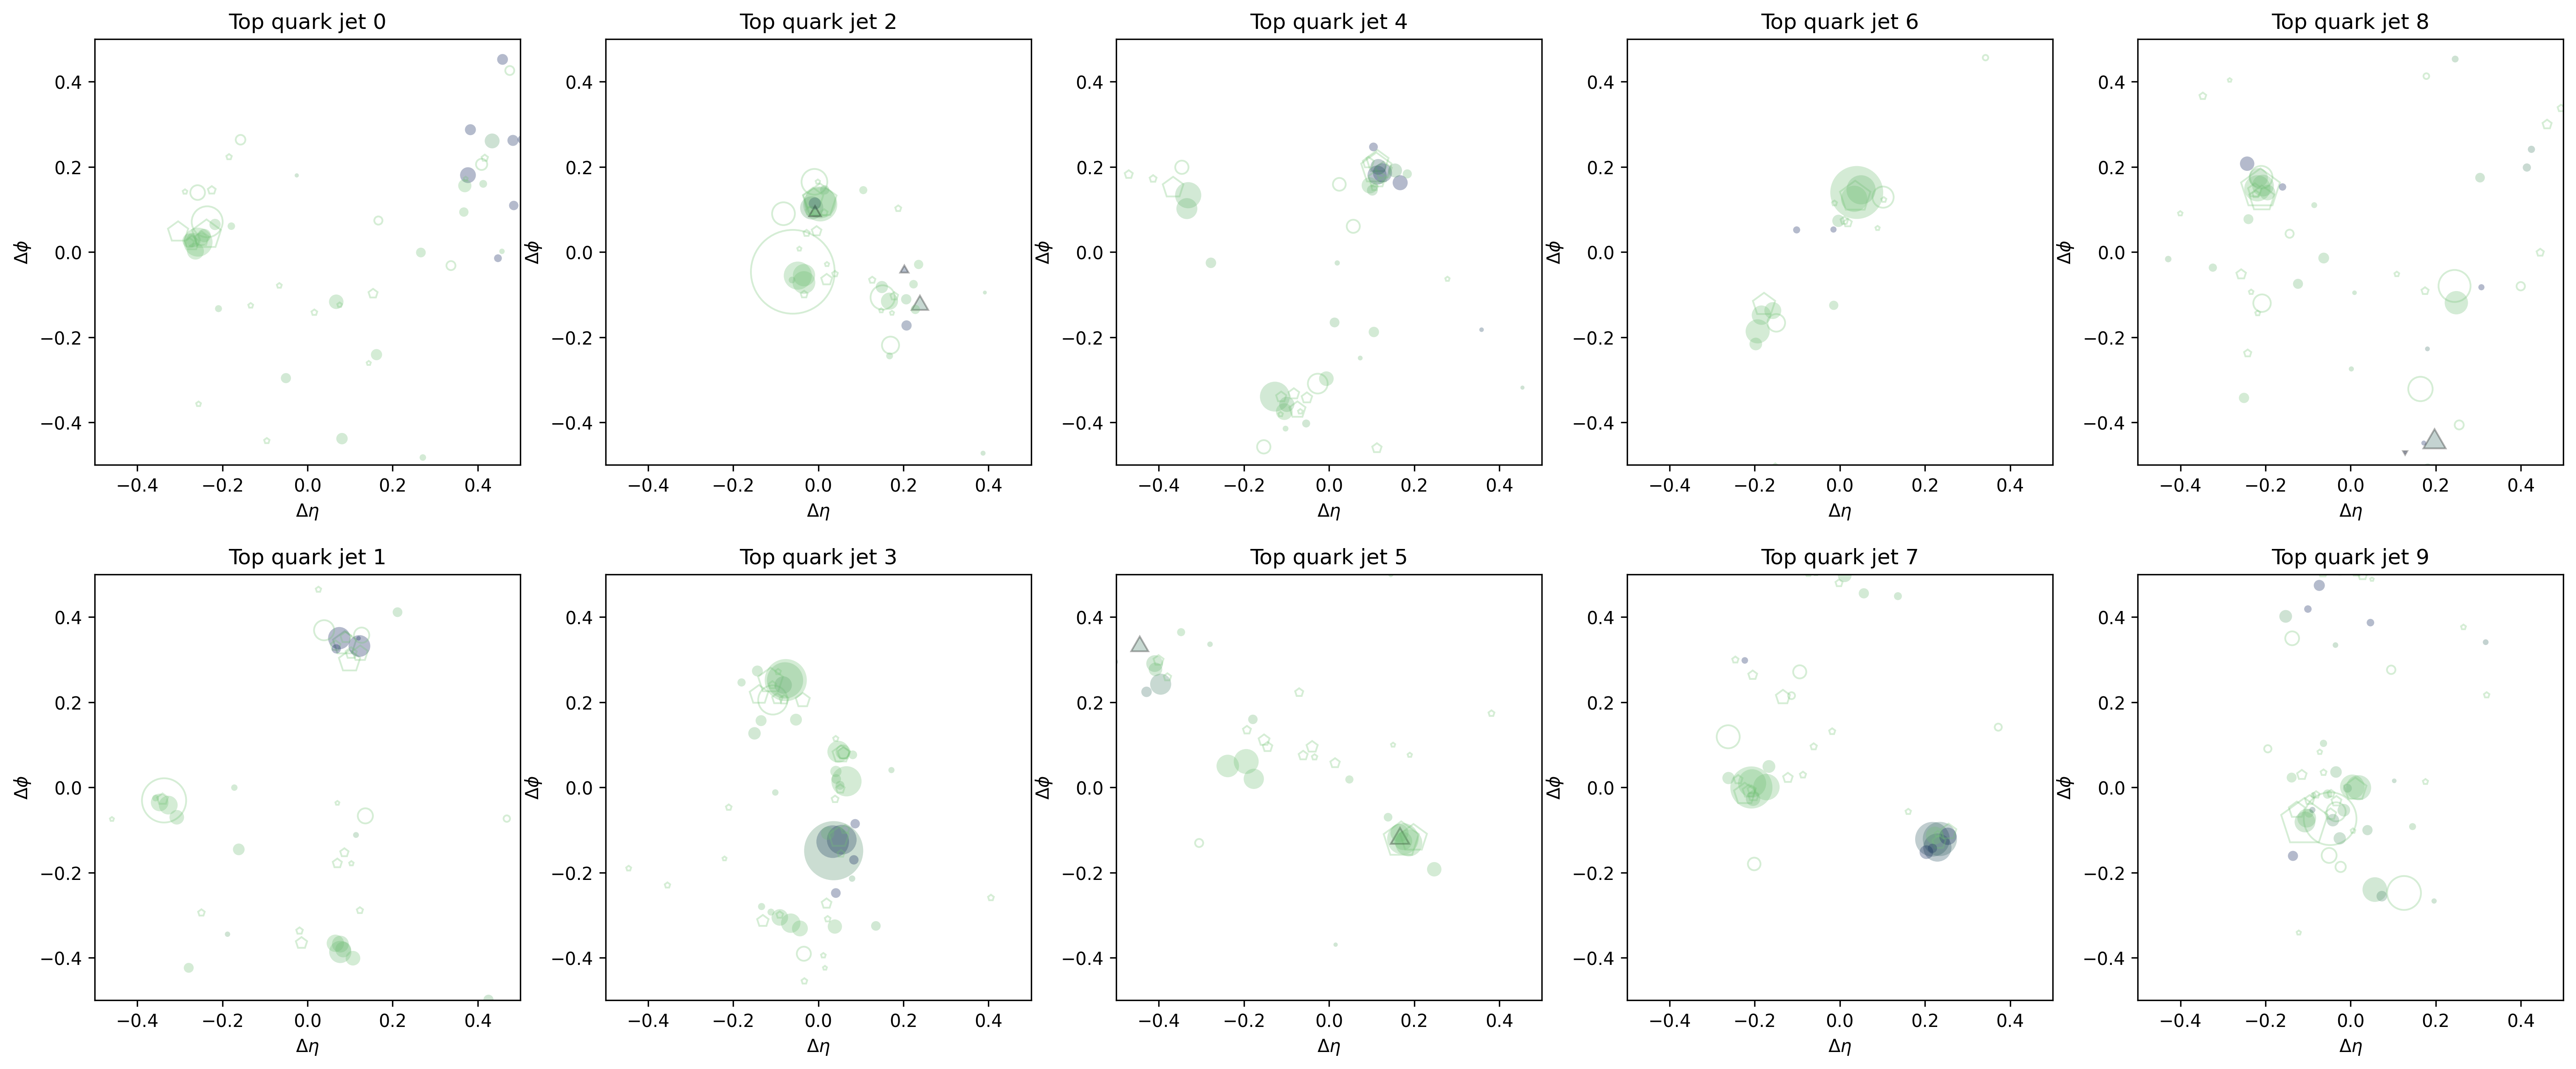

In [11]:
fig, axes = plt.subplots(2, 5, figsize=(25, 10), dpi=300)
for idx in range(10):
    visualize(signal_table, idx, title=f'Top quark jet {idx}', ax=axes[idx % 2][idx // 2])


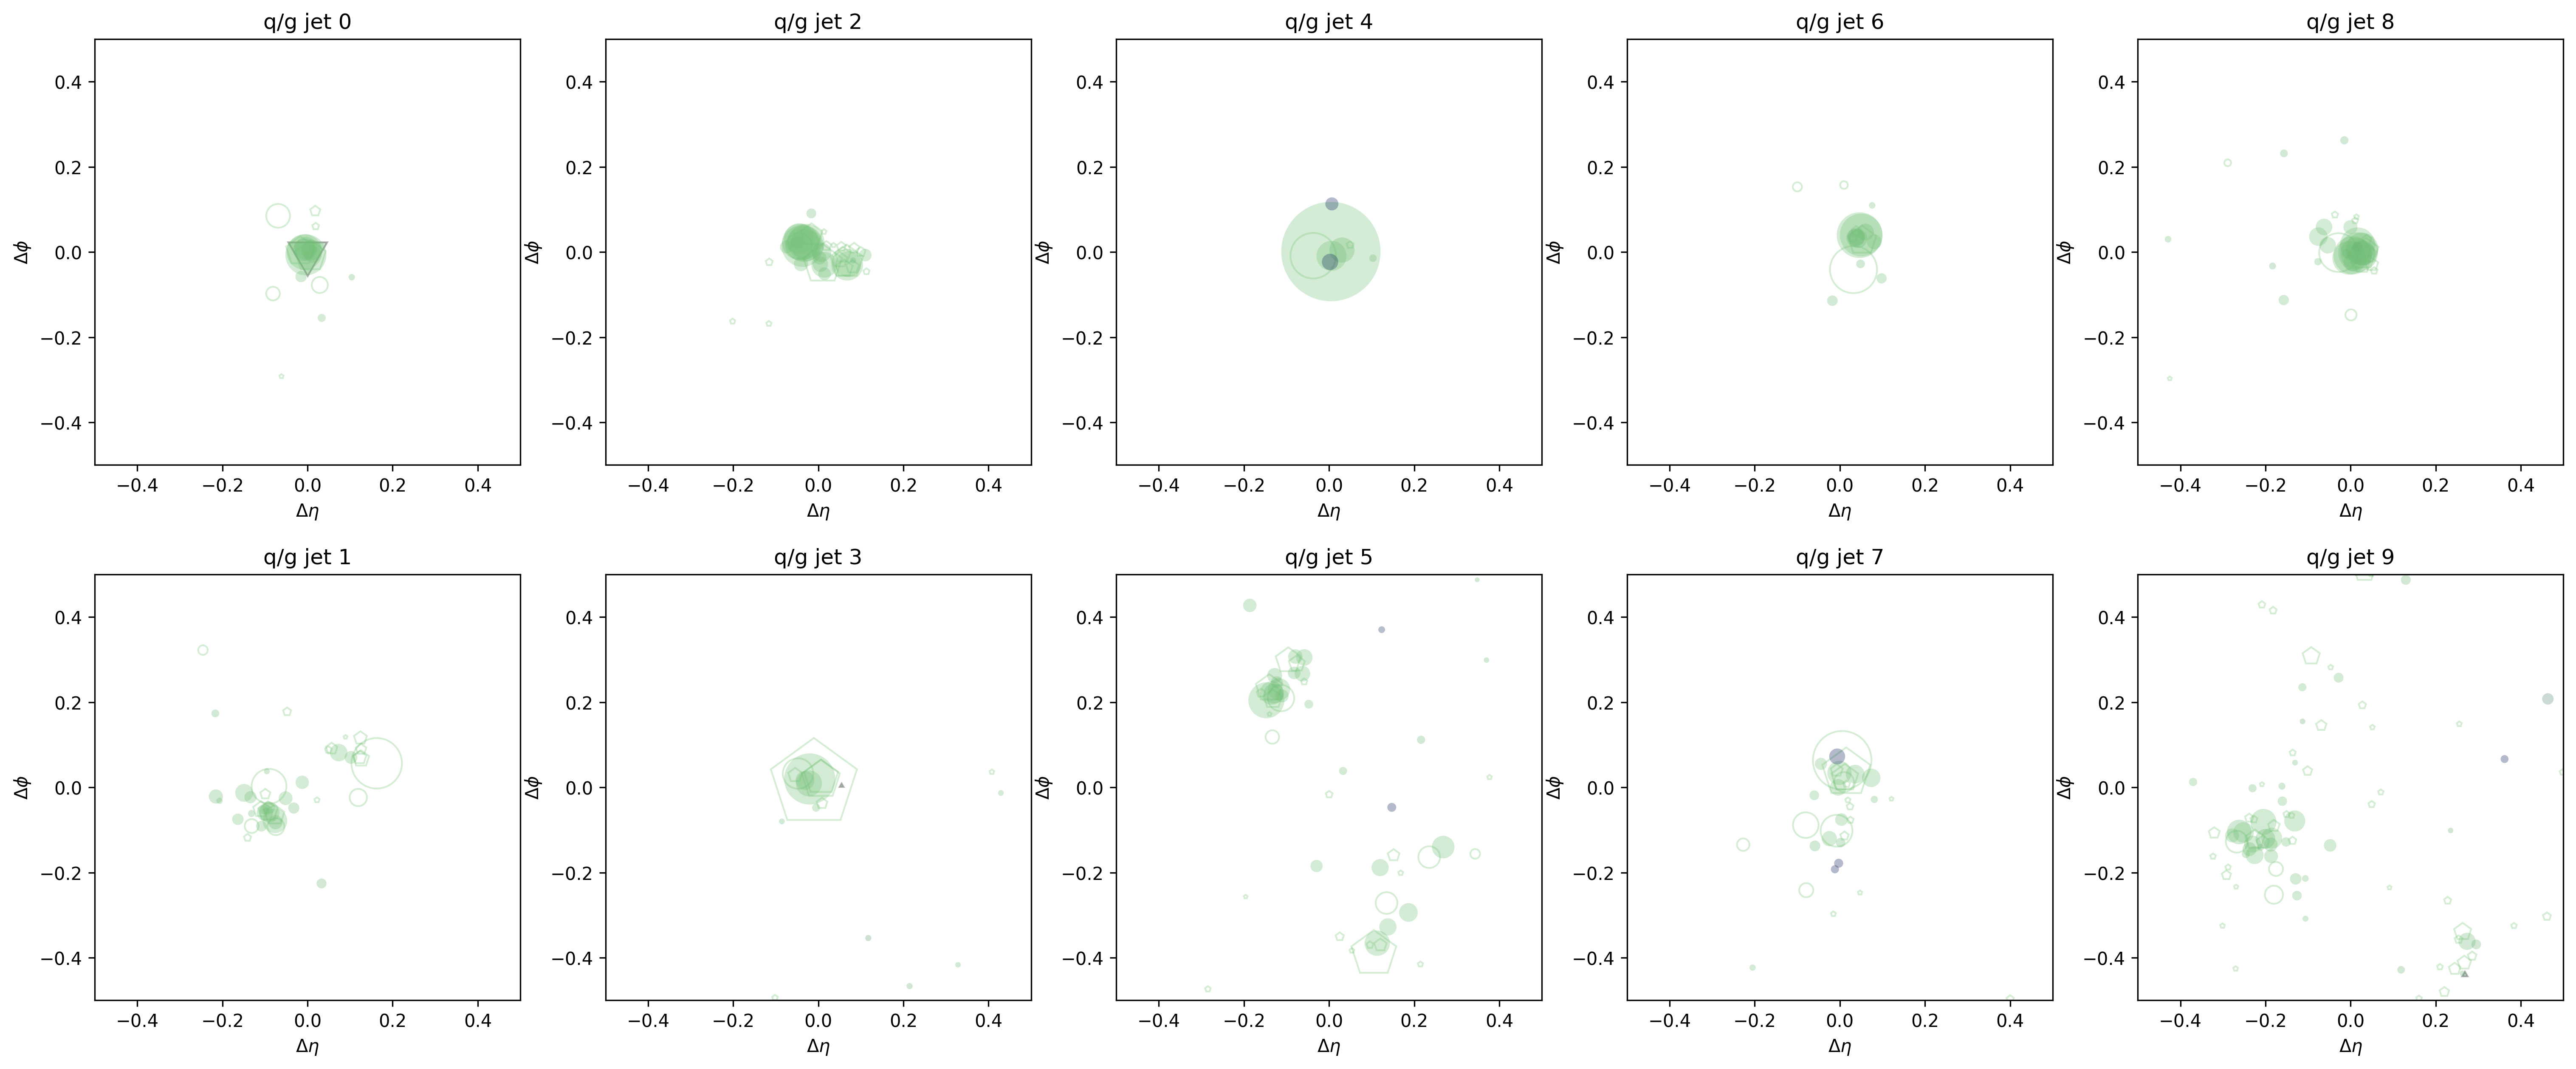

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(25, 10), dpi=300)
for idx in range(10):
    visualize(background_table, idx, title=f'q/g jet {idx}', ax=axes[idx % 2][idx // 2])


# Jet properties


In [13]:
jet_features = [k for k in signal_table.fields if k.startswith('jet_')]
jet_features


['jet_pt',
 'jet_eta',
 'jet_phi',
 'jet_energy',
 'jet_nparticles',
 'jet_sdmass',
 'jet_tau1',
 'jet_tau2',
 'jet_tau3',
 'jet_tau4']

In [14]:
df_jet_signal = ak.to_dataframe(signal_table[jet_features])
df_jet_signal.head(10)


,jet_pt,jet_eta,jet_phi,jet_energy,jet_nparticles,jet_sdmass,jet_tau1,jet_tau2,jet_tau3,jet_tau4
entry,,,,,,,,,,
0,516.935364,-0.467094,0.339593,622.854919,70.0,230.369522,0.385736,0.234463,0.130692,0.107689
1,522.771973,1.108905,-2.387866,901.400818,53.0,201.861343,0.443875,0.232752,0.080662,0.066185
2,992.081787,-0.295439,2.945119,1044.726318,47.0,124.356590,0.130054,0.062514,0.026957,0.024248
3,978.478821,-0.850465,0.334134,1373.824585,69.0,207.287201,0.255197,0.100138,0.070748,0.047978
4,543.914001,-1.290817,1.526617,1077.437256,49.0,172.307663,0.357782,0.164833,0.058693,0.048758
5,523.814697,0.427098,-1.460452,592.846436,38.0,154.648254,0.299822,0.104771,0.046748,0.038492
6,501.032440,-0.574296,1.791986,600.948425,26.0,77.850479,0.210666,0.081585,0.029847,0.025328
7,635.456604,0.489925,-1.818528,733.785583,47.0,144.426865,0.301850,0.093496,0.052969,0.039479
8,568.541382,-1.315159,1.360880,1151.167358,57.0,190.394623,0.335589,0.146574,0.095714,0.074820


In [15]:
df_jet_background = ak.to_dataframe(background_table[jet_features])
df_jet_background.head(10)


,jet_pt,jet_eta,jet_phi,jet_energy,jet_nparticles,jet_sdmass,jet_tau1,jet_tau2,jet_tau3,jet_tau4
entry,,,,,,,,,,
0,566.992920,-0.443625,-1.609392,625.308899,22.0,4.674626,0.033582,0.030006,0.022653,0.018792
1,601.180908,-0.345233,1.958757,643.409546,43.0,81.096268,0.161253,0.056395,0.044775,0.038228
2,955.471191,0.815420,-0.558629,1292.205811,37.0,51.288776,0.058520,0.025241,0.014105,0.013124
3,915.252808,0.845484,1.254454,1266.186646,24.0,8.802290,0.035677,0.019943,0.015701,0.011847
4,773.340454,-0.040889,-2.496383,774.186401,8.0,13.352821,0.013250,0.005350,0.003582,0.001905
5,754.010986,-0.061642,-1.648969,795.694519,54.0,247.922073,0.365506,0.099197,0.070758,0.057466
6,550.871582,0.681105,-2.309712,691.288452,24.0,20.956633,0.104046,0.040573,0.015956,0.014793
7,693.920044,0.275410,0.422810,733.737671,34.0,53.652122,0.078059,0.043055,0.031841,0.026984
8,833.138367,-0.740946,-1.179016,1075.225952,41.0,17.784090,0.046320,0.038056,0.032201,0.028891


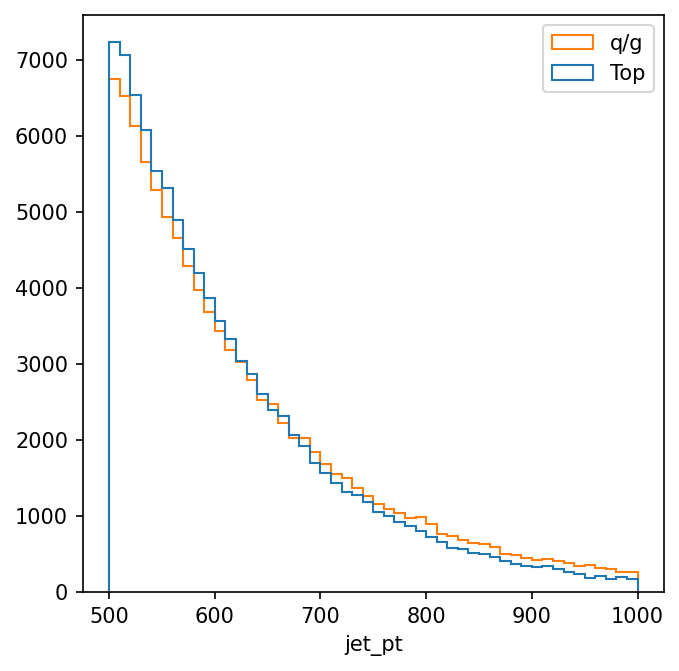

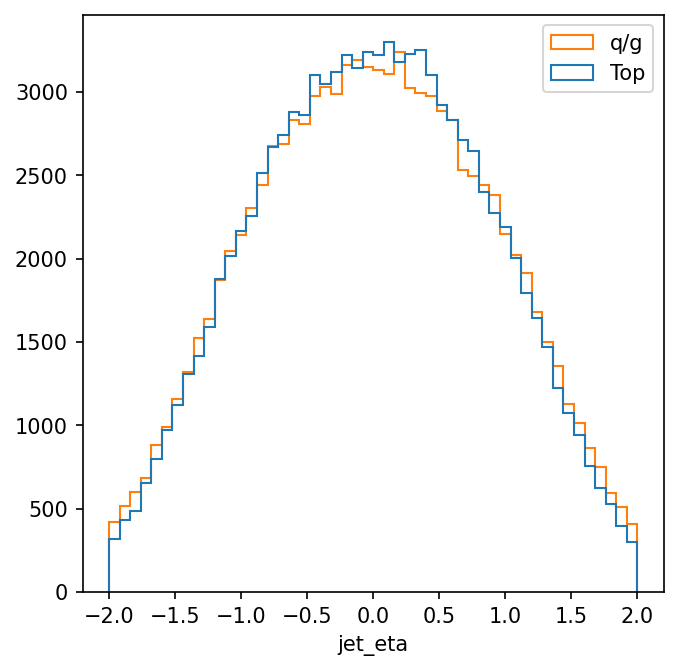

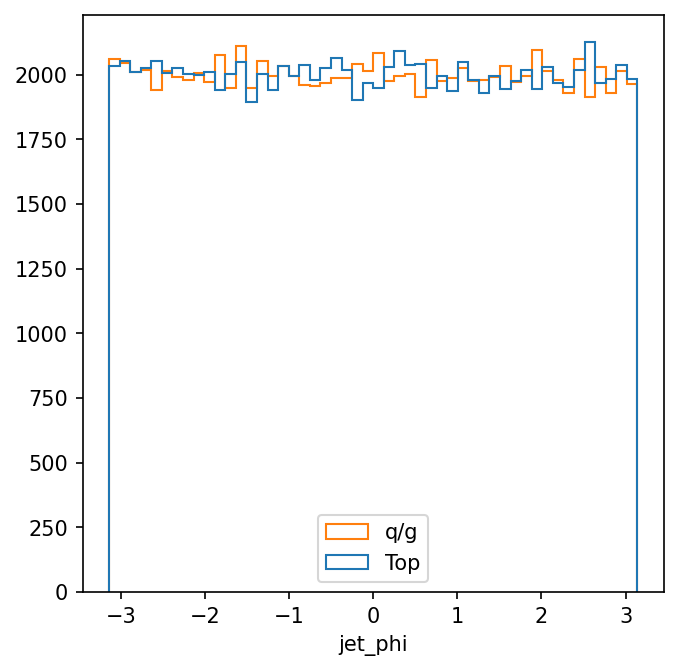

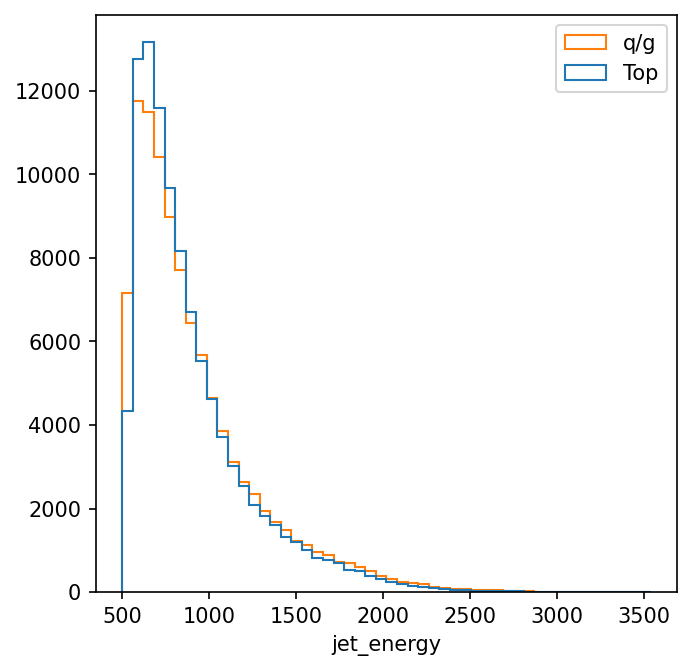

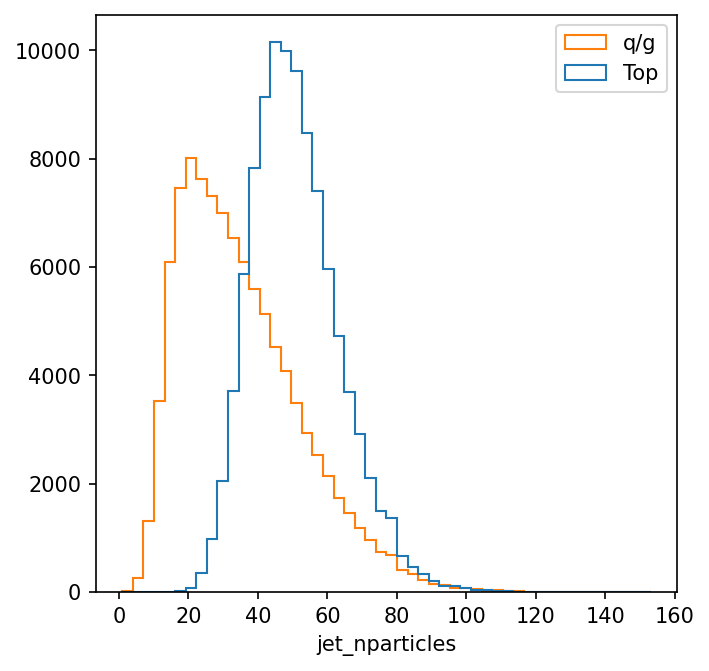

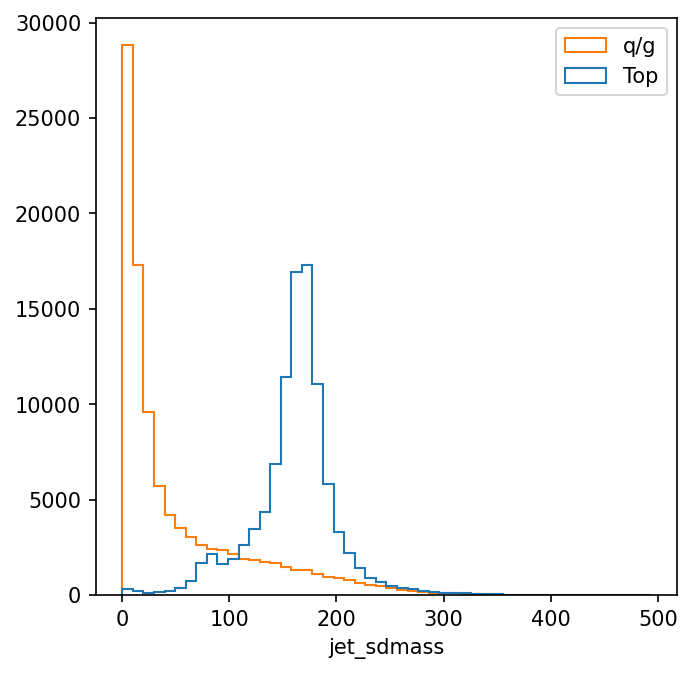

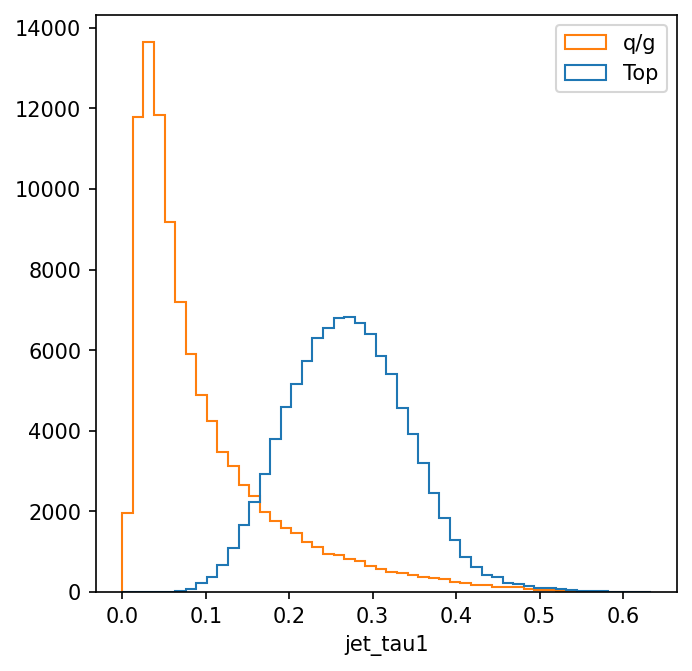

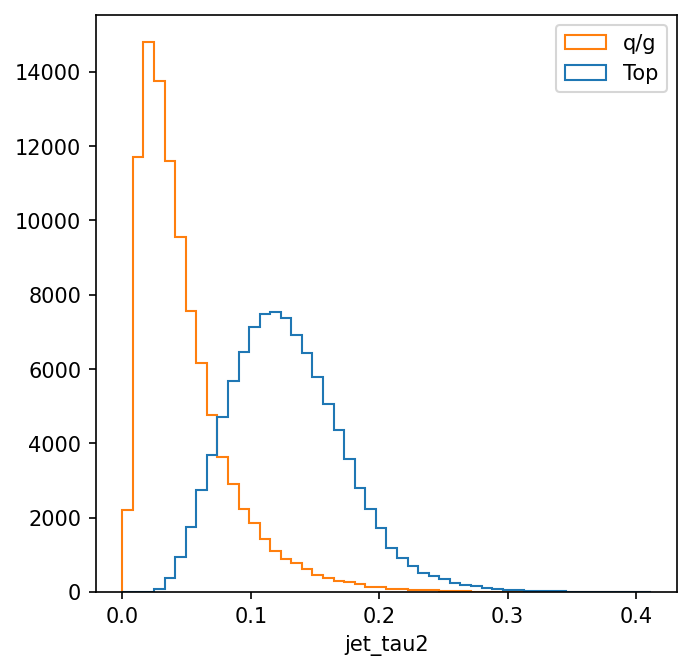

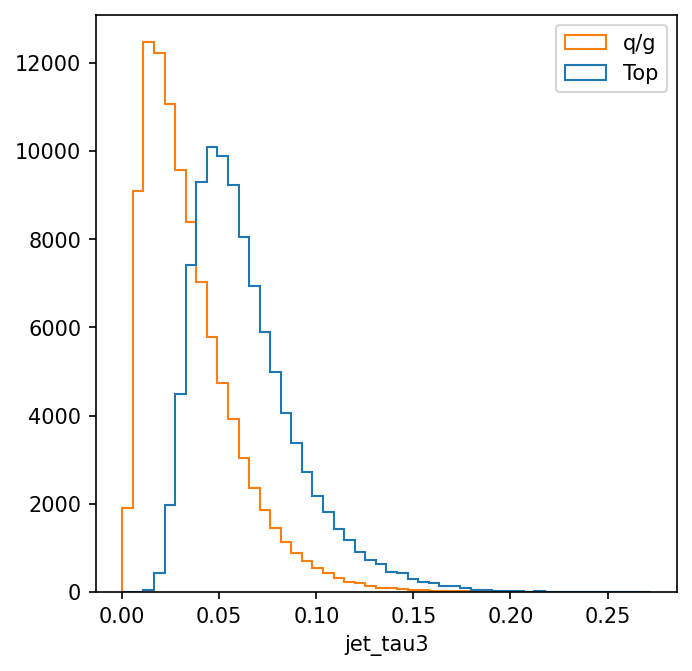

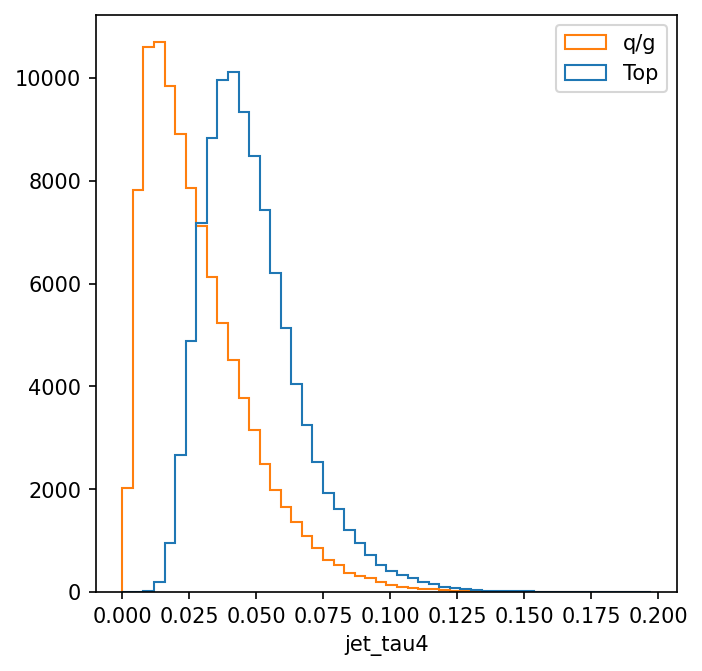

In [17]:
for k in jet_features:
    plt.figure(figsize=(5,5), dpi=150)
    plt.hist([df_jet_signal[k], df_jet_background[k]],
             bins=50, label=['Top', 'q/g'], histtype='step', density=True)
    plt.xlabel(k)
    plt.legend()


# Jet constituent properties


In [18]:
particle_features = [k for k in signal_table.fields if k.startswith('part_')]
particle_features


['part_px',
 'part_py',
 'part_pz',
 'part_energy',
 'part_deta',
 'part_dphi',
 'part_d0val',
 'part_d0err',
 'part_dzval',
 'part_dzerr',
 'part_charge',
 'part_isChargedHadron',
 'part_isNeutralHadron',
 'part_isPhoton',
 'part_isElectron',
 'part_isMuon']

In [19]:
def plot_particle_features(name):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300)
    axes[0].hist([ak.flatten(signal_table[name]), ak.flatten(background_table[name])],
                 bins=50, label=['Top', 'q/g'], histtype='step', density=True)
    axes[0].set_xlabel(name)
    axes[0].legend()

    axes[1].hist([ak.flatten(signal_table[name]), ak.flatten(background_table[name])],
                 bins=50, label=['Top', 'q/g'], histtype='step', density=True)
    axes[1].set_xlabel(name)
    axes[1].set_yscale('log')
    axes[1].legend()


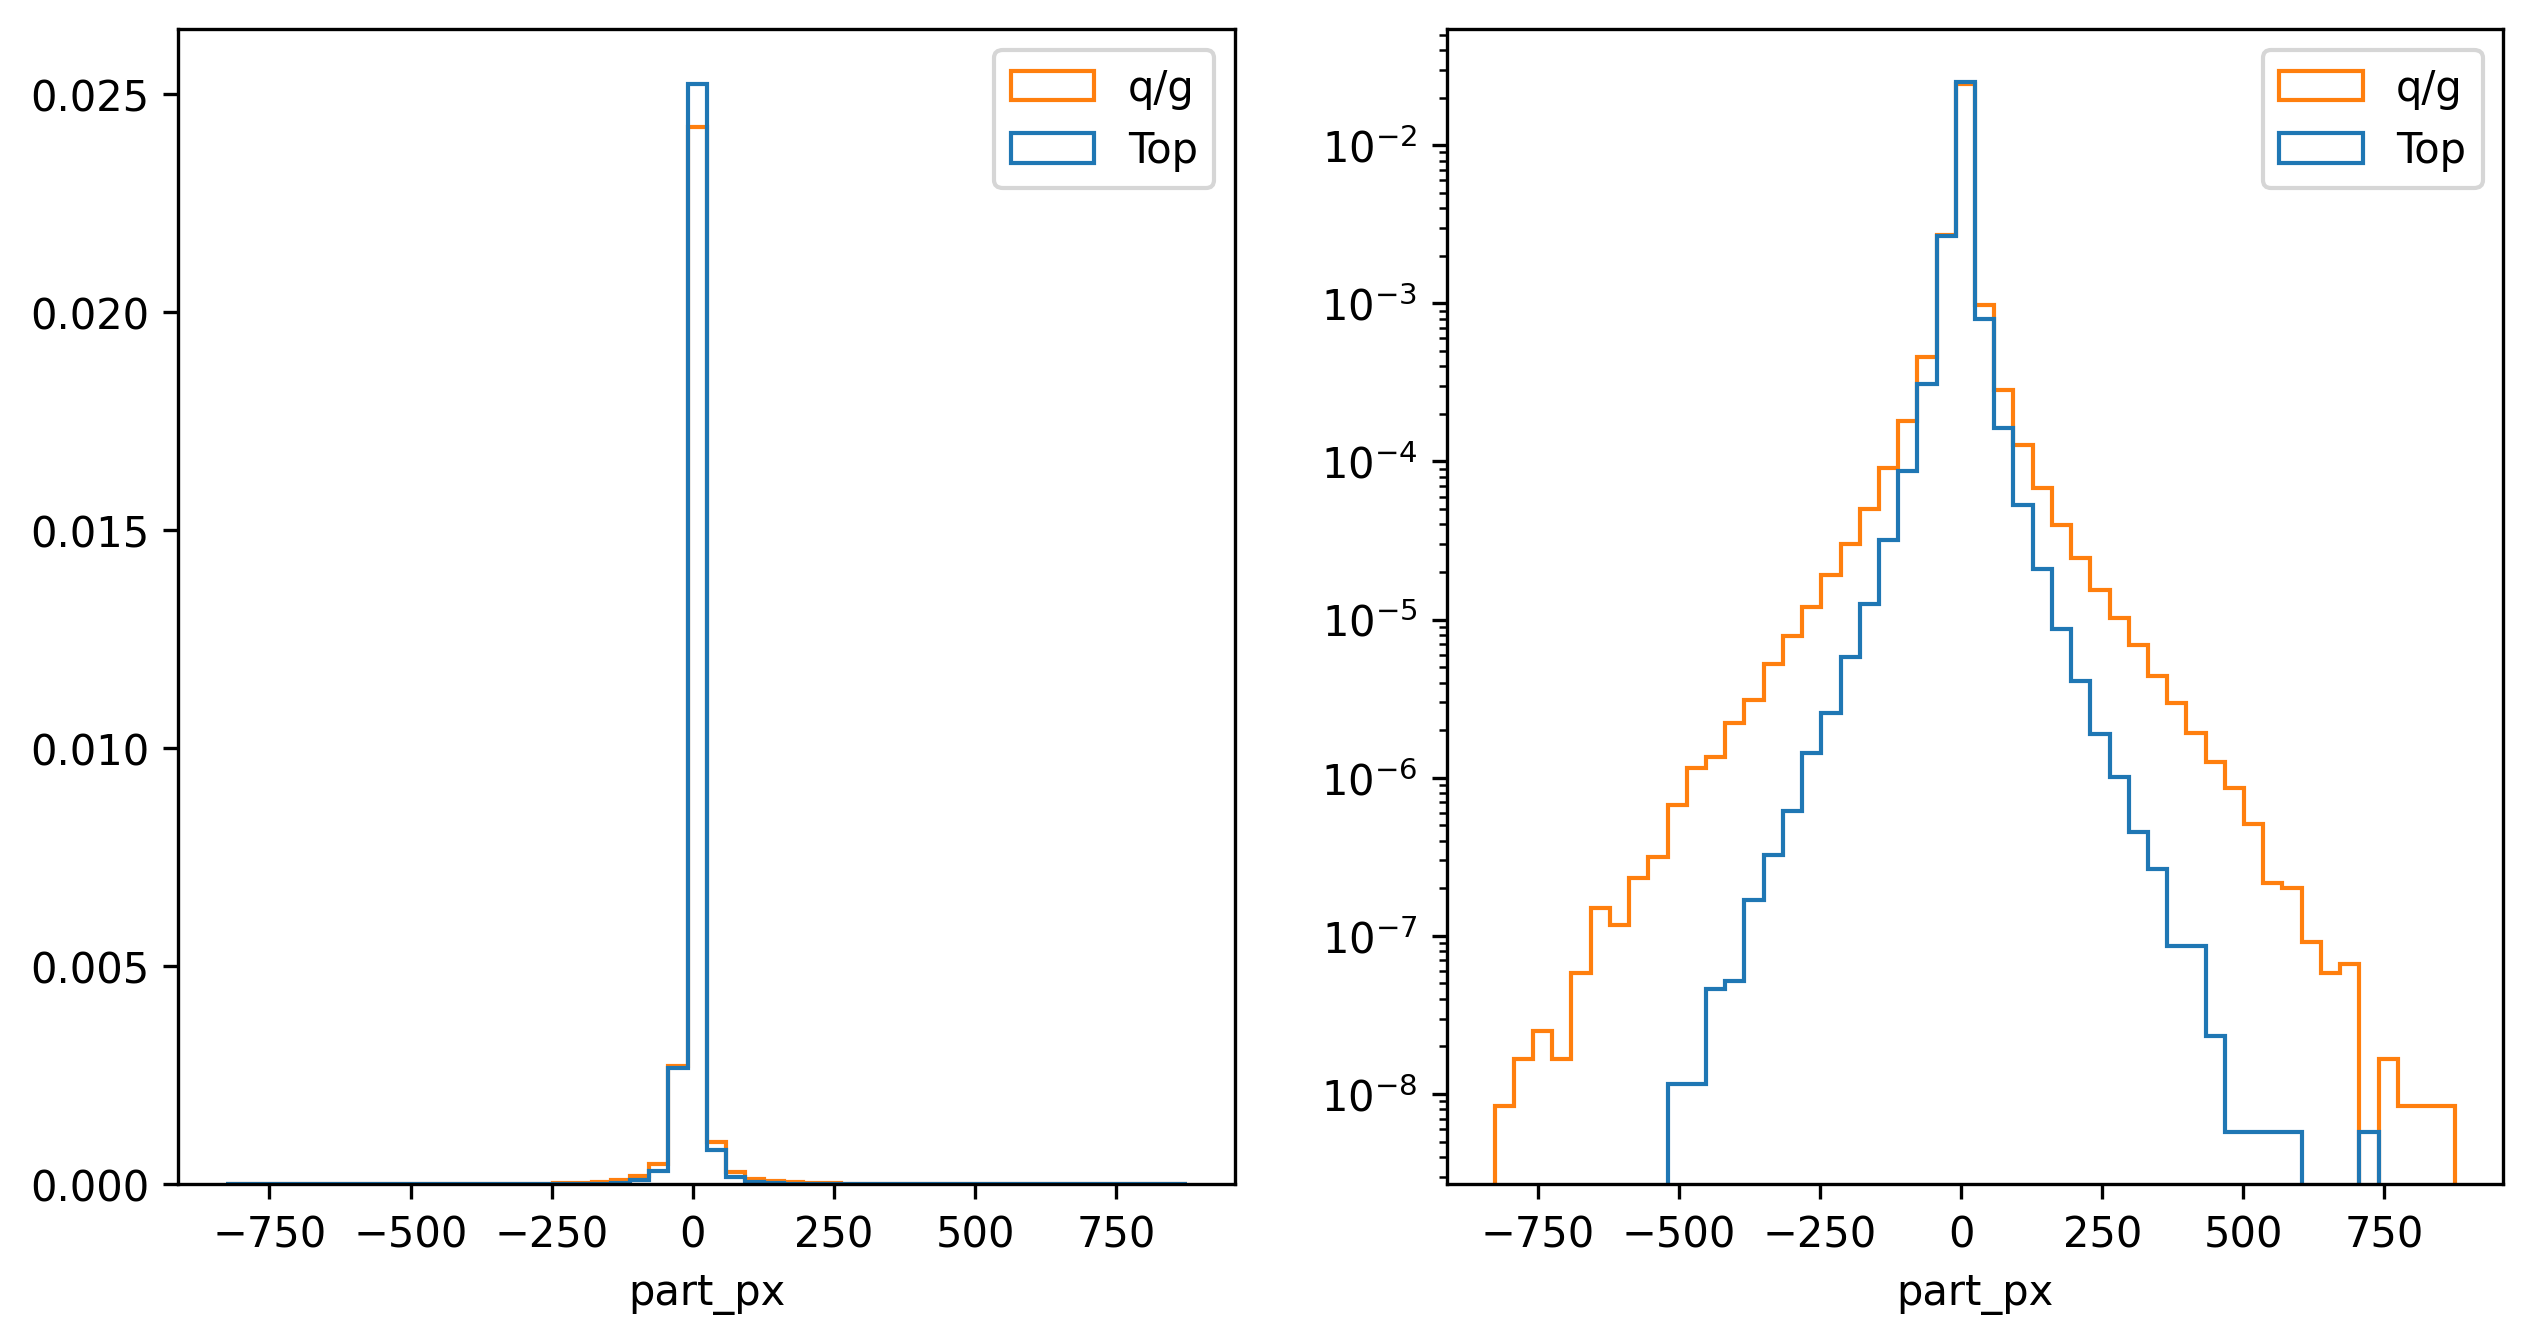

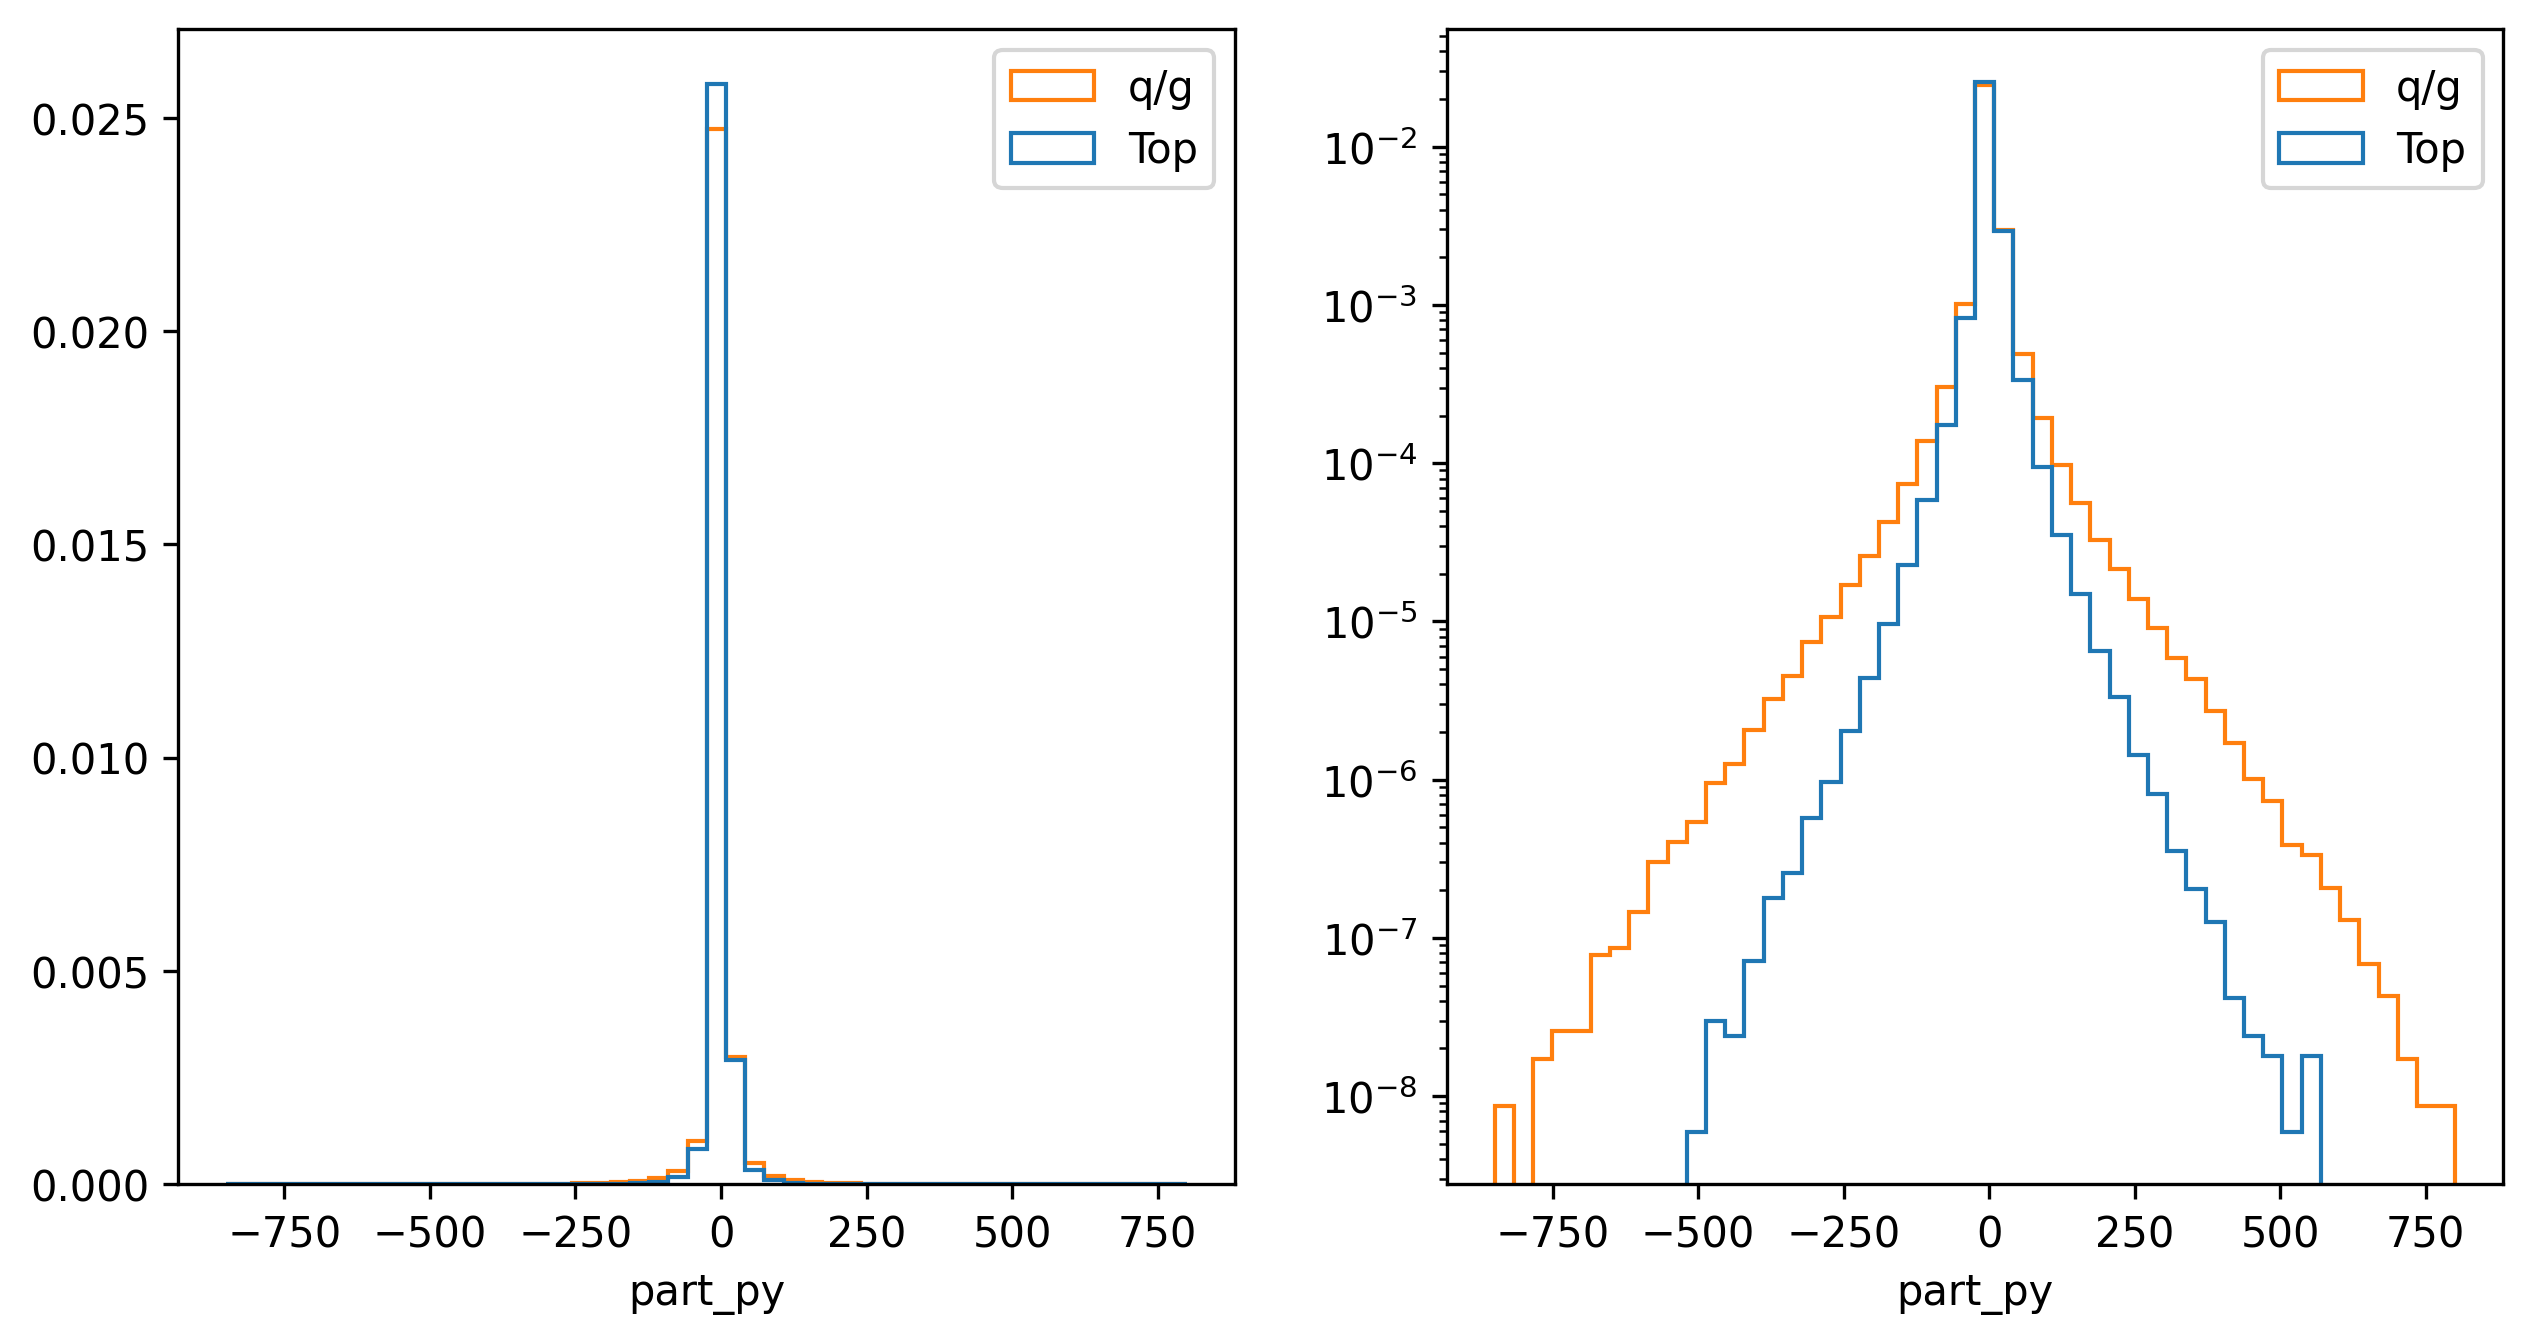

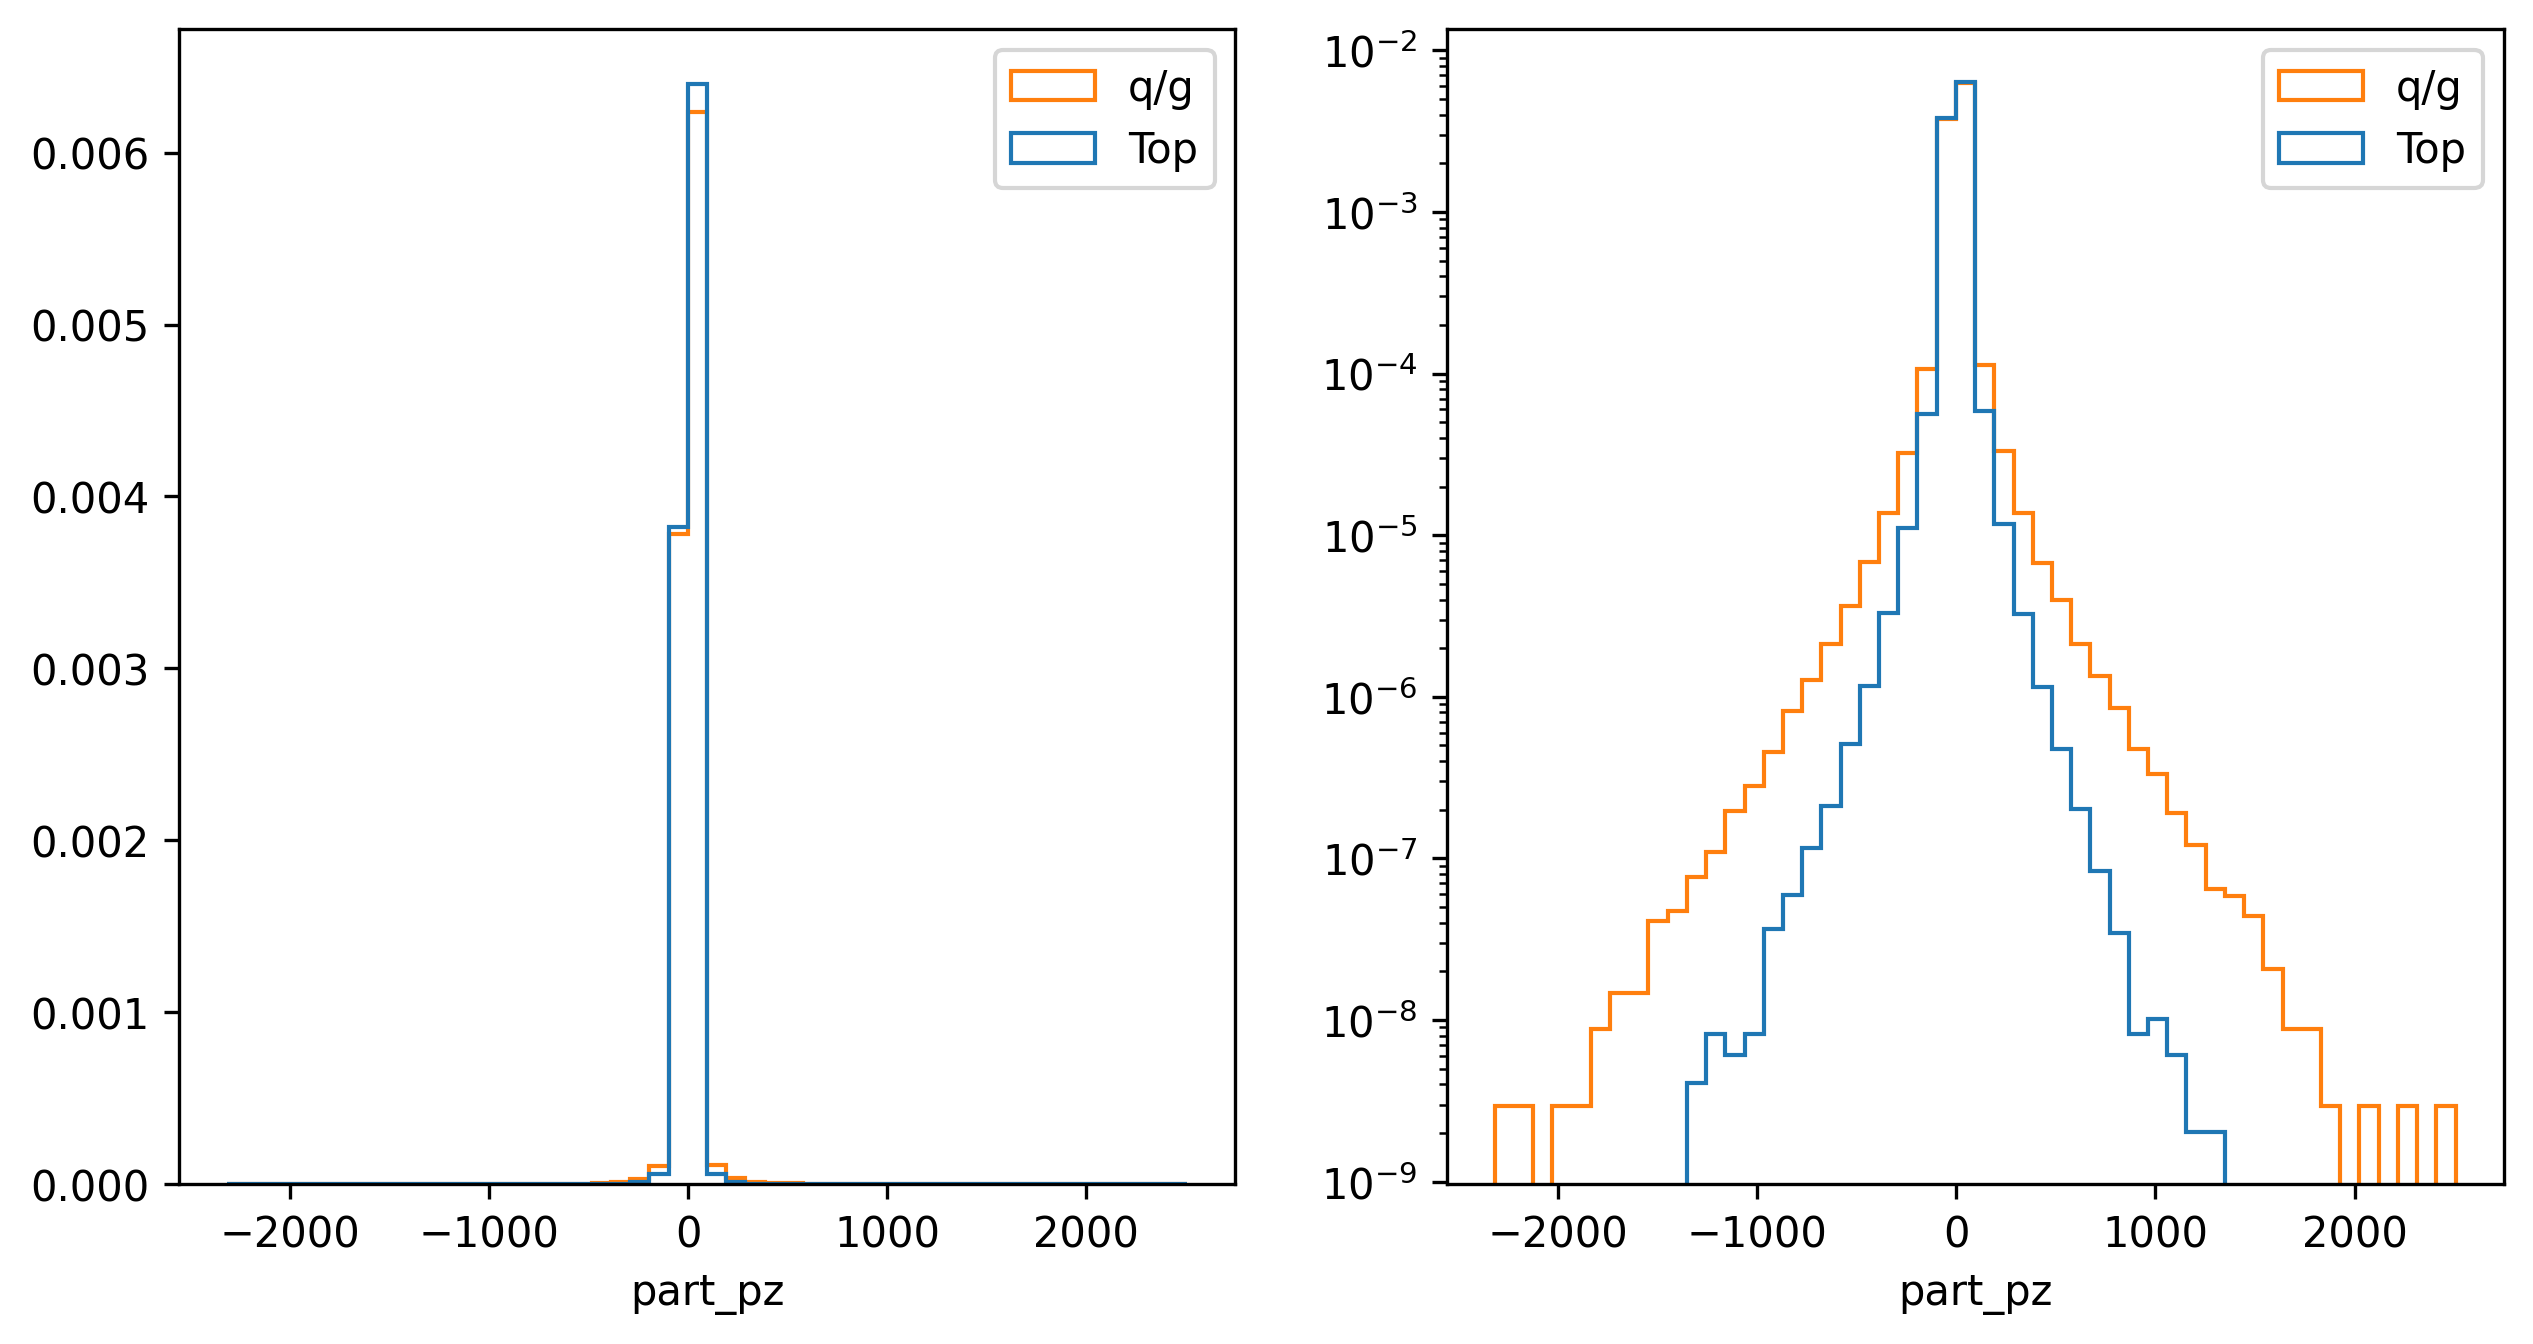

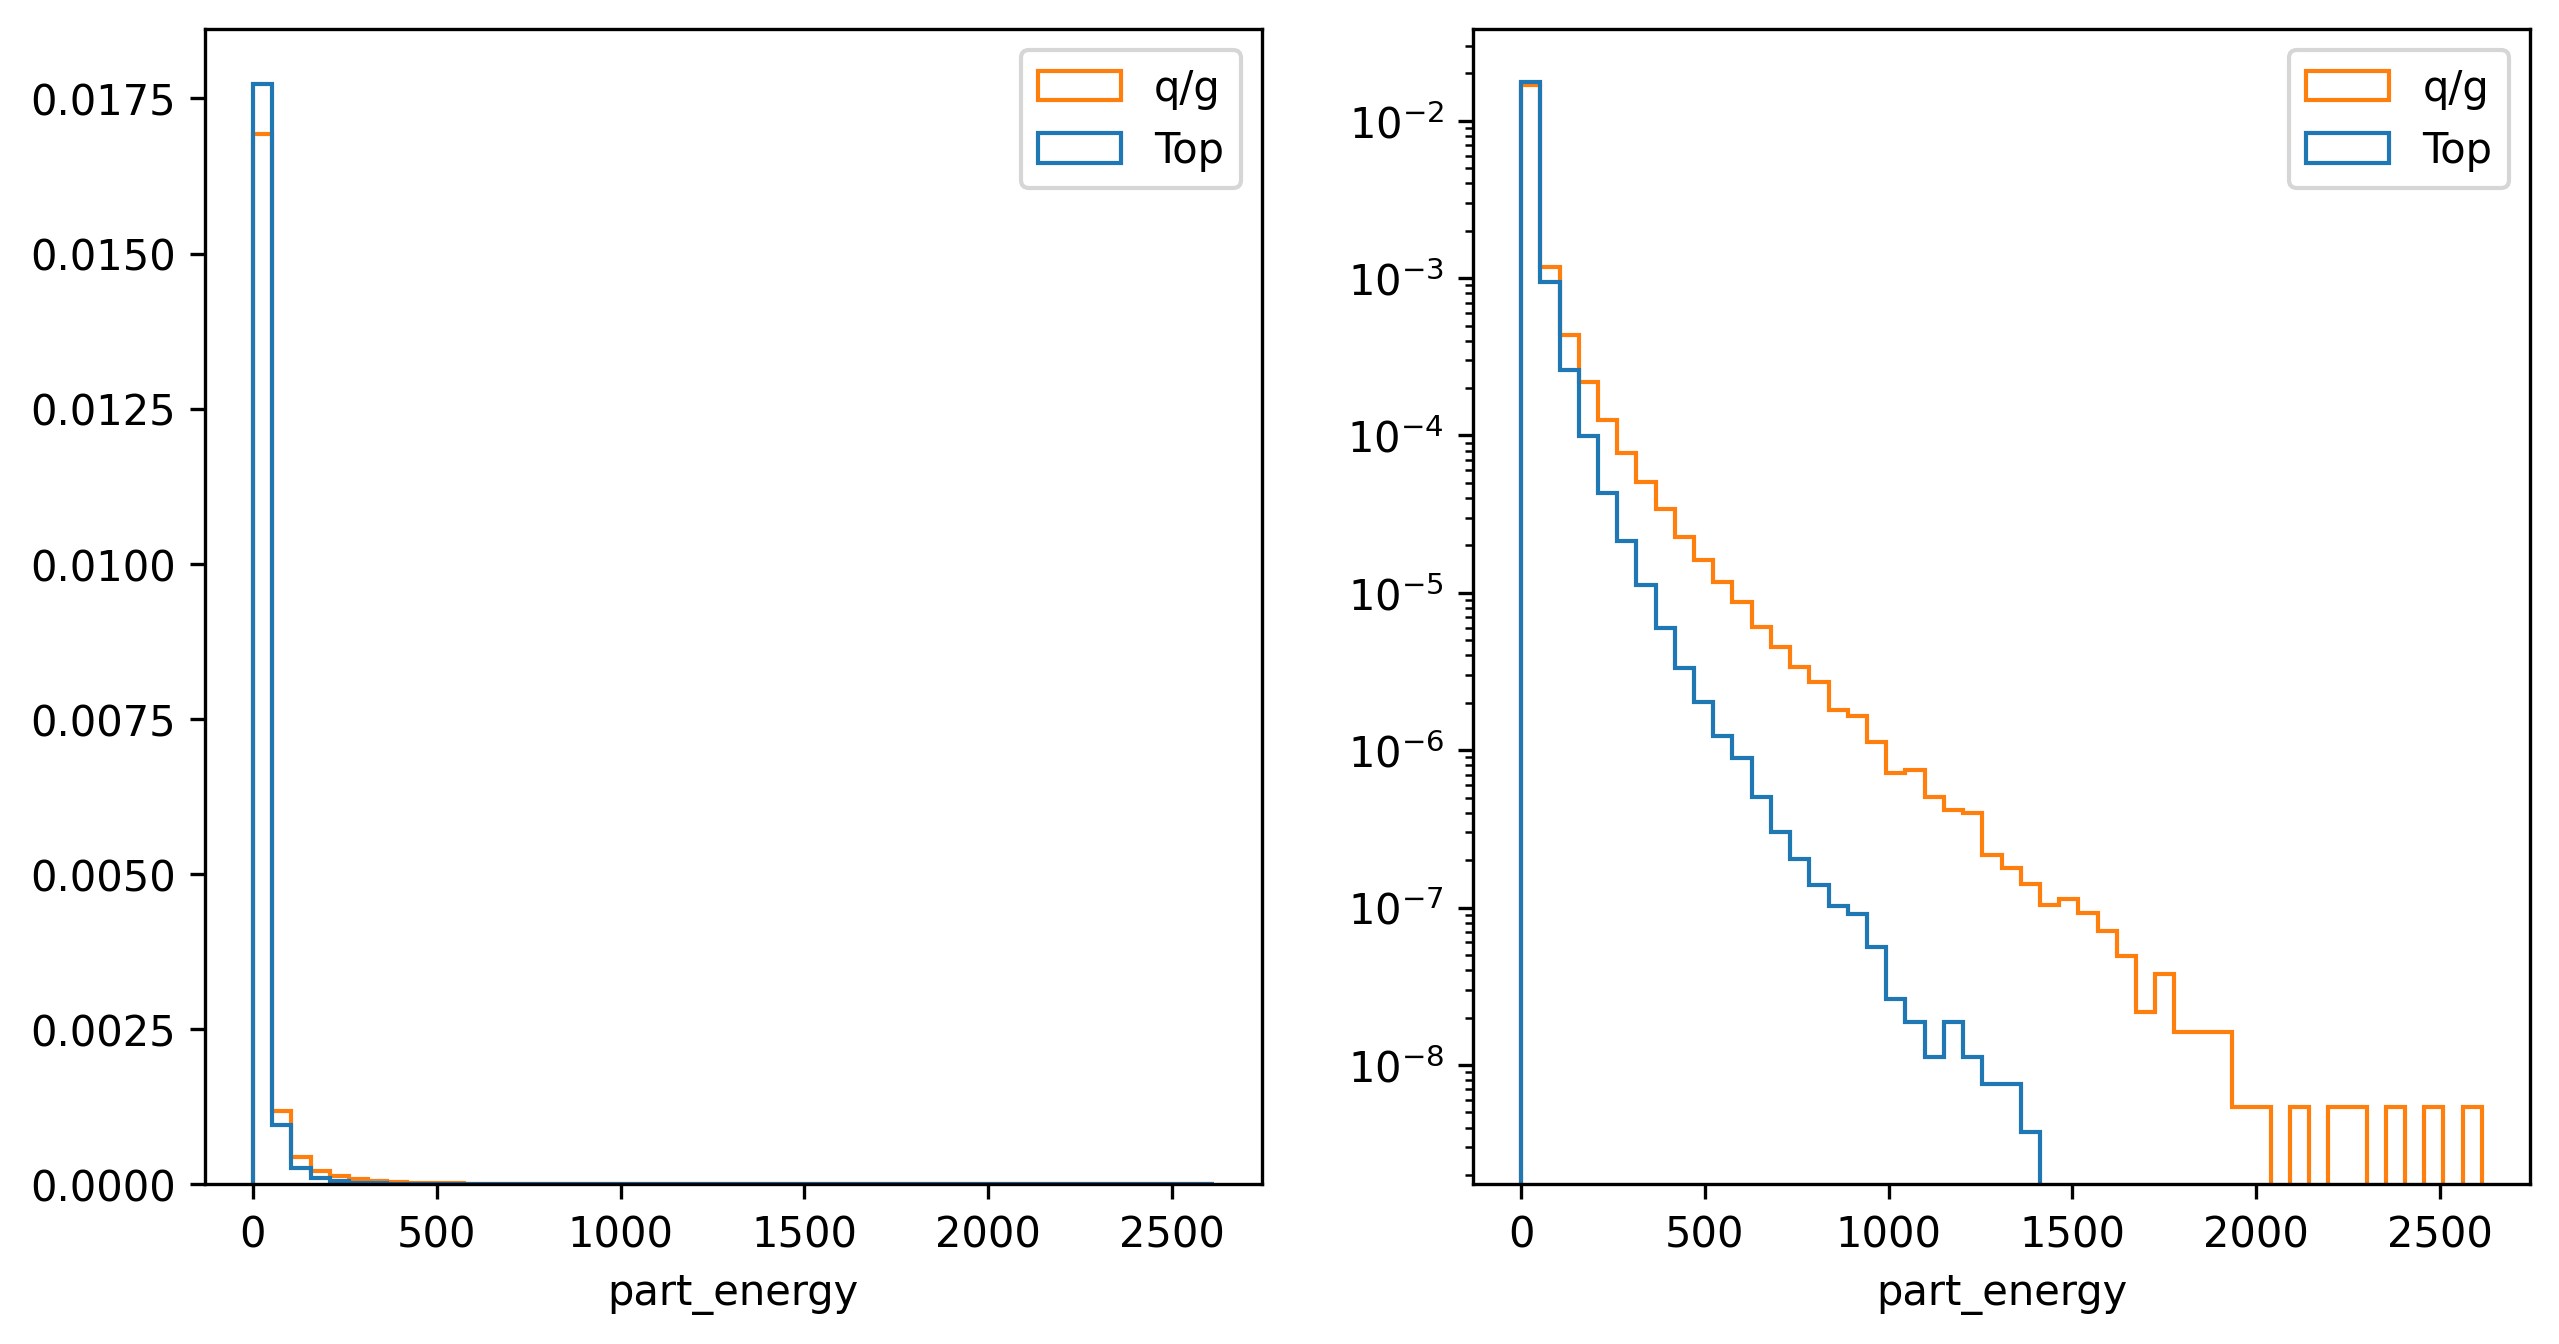

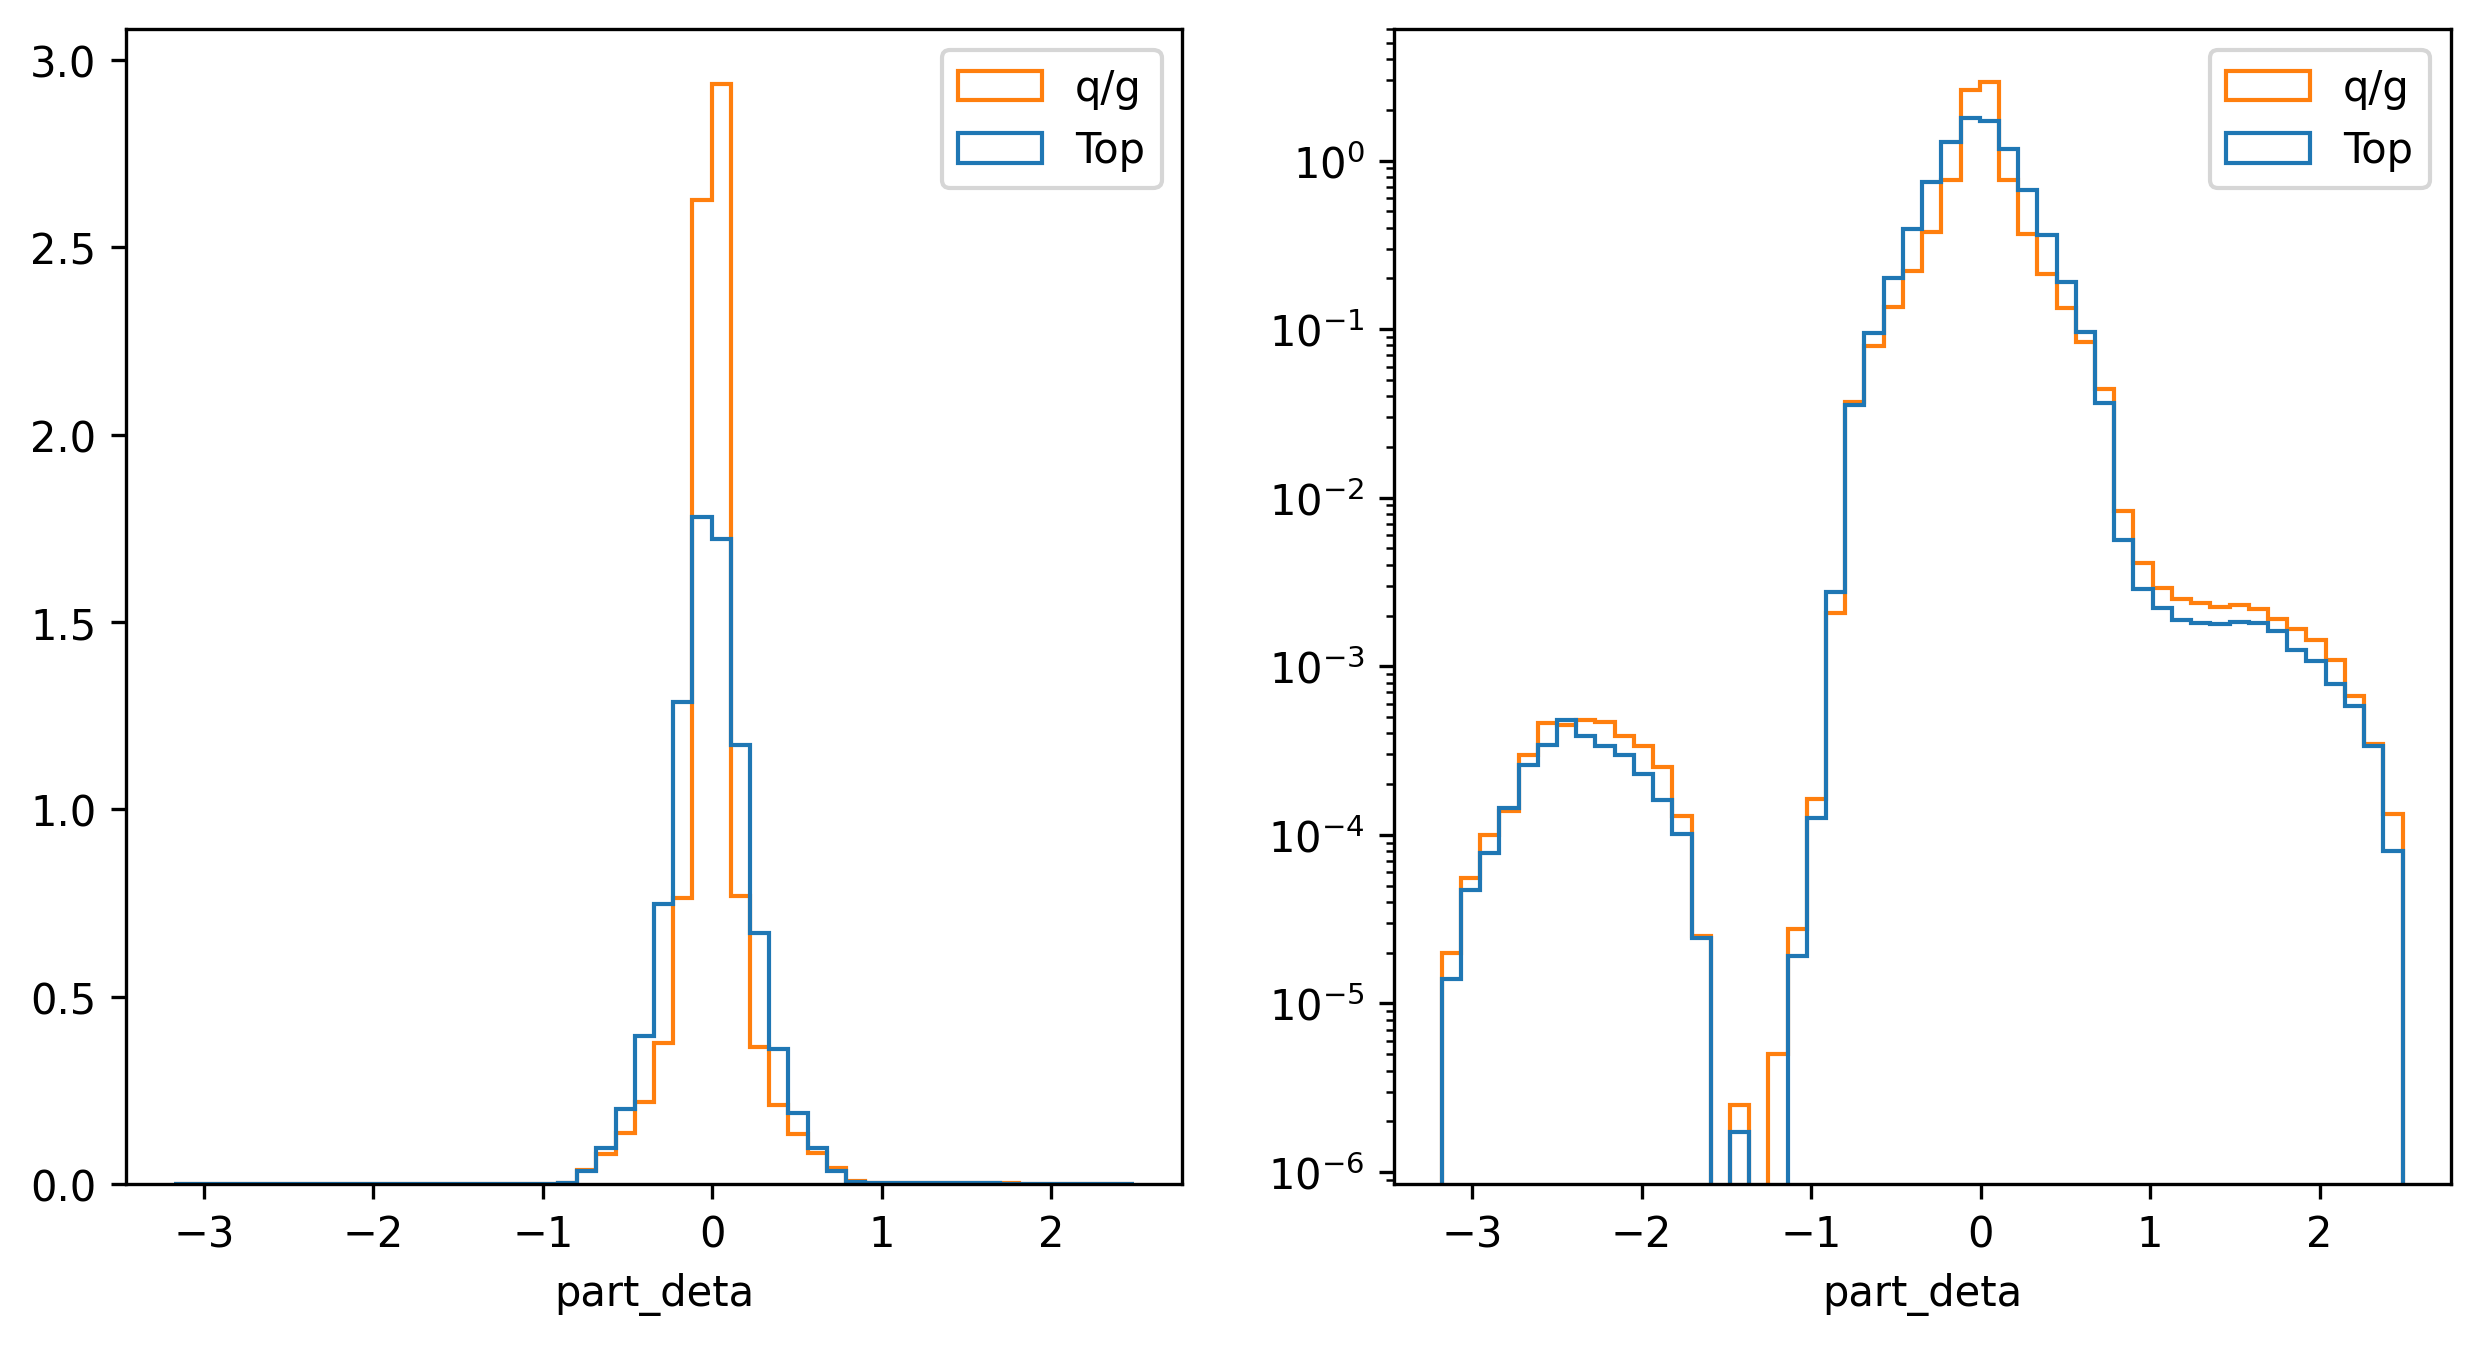

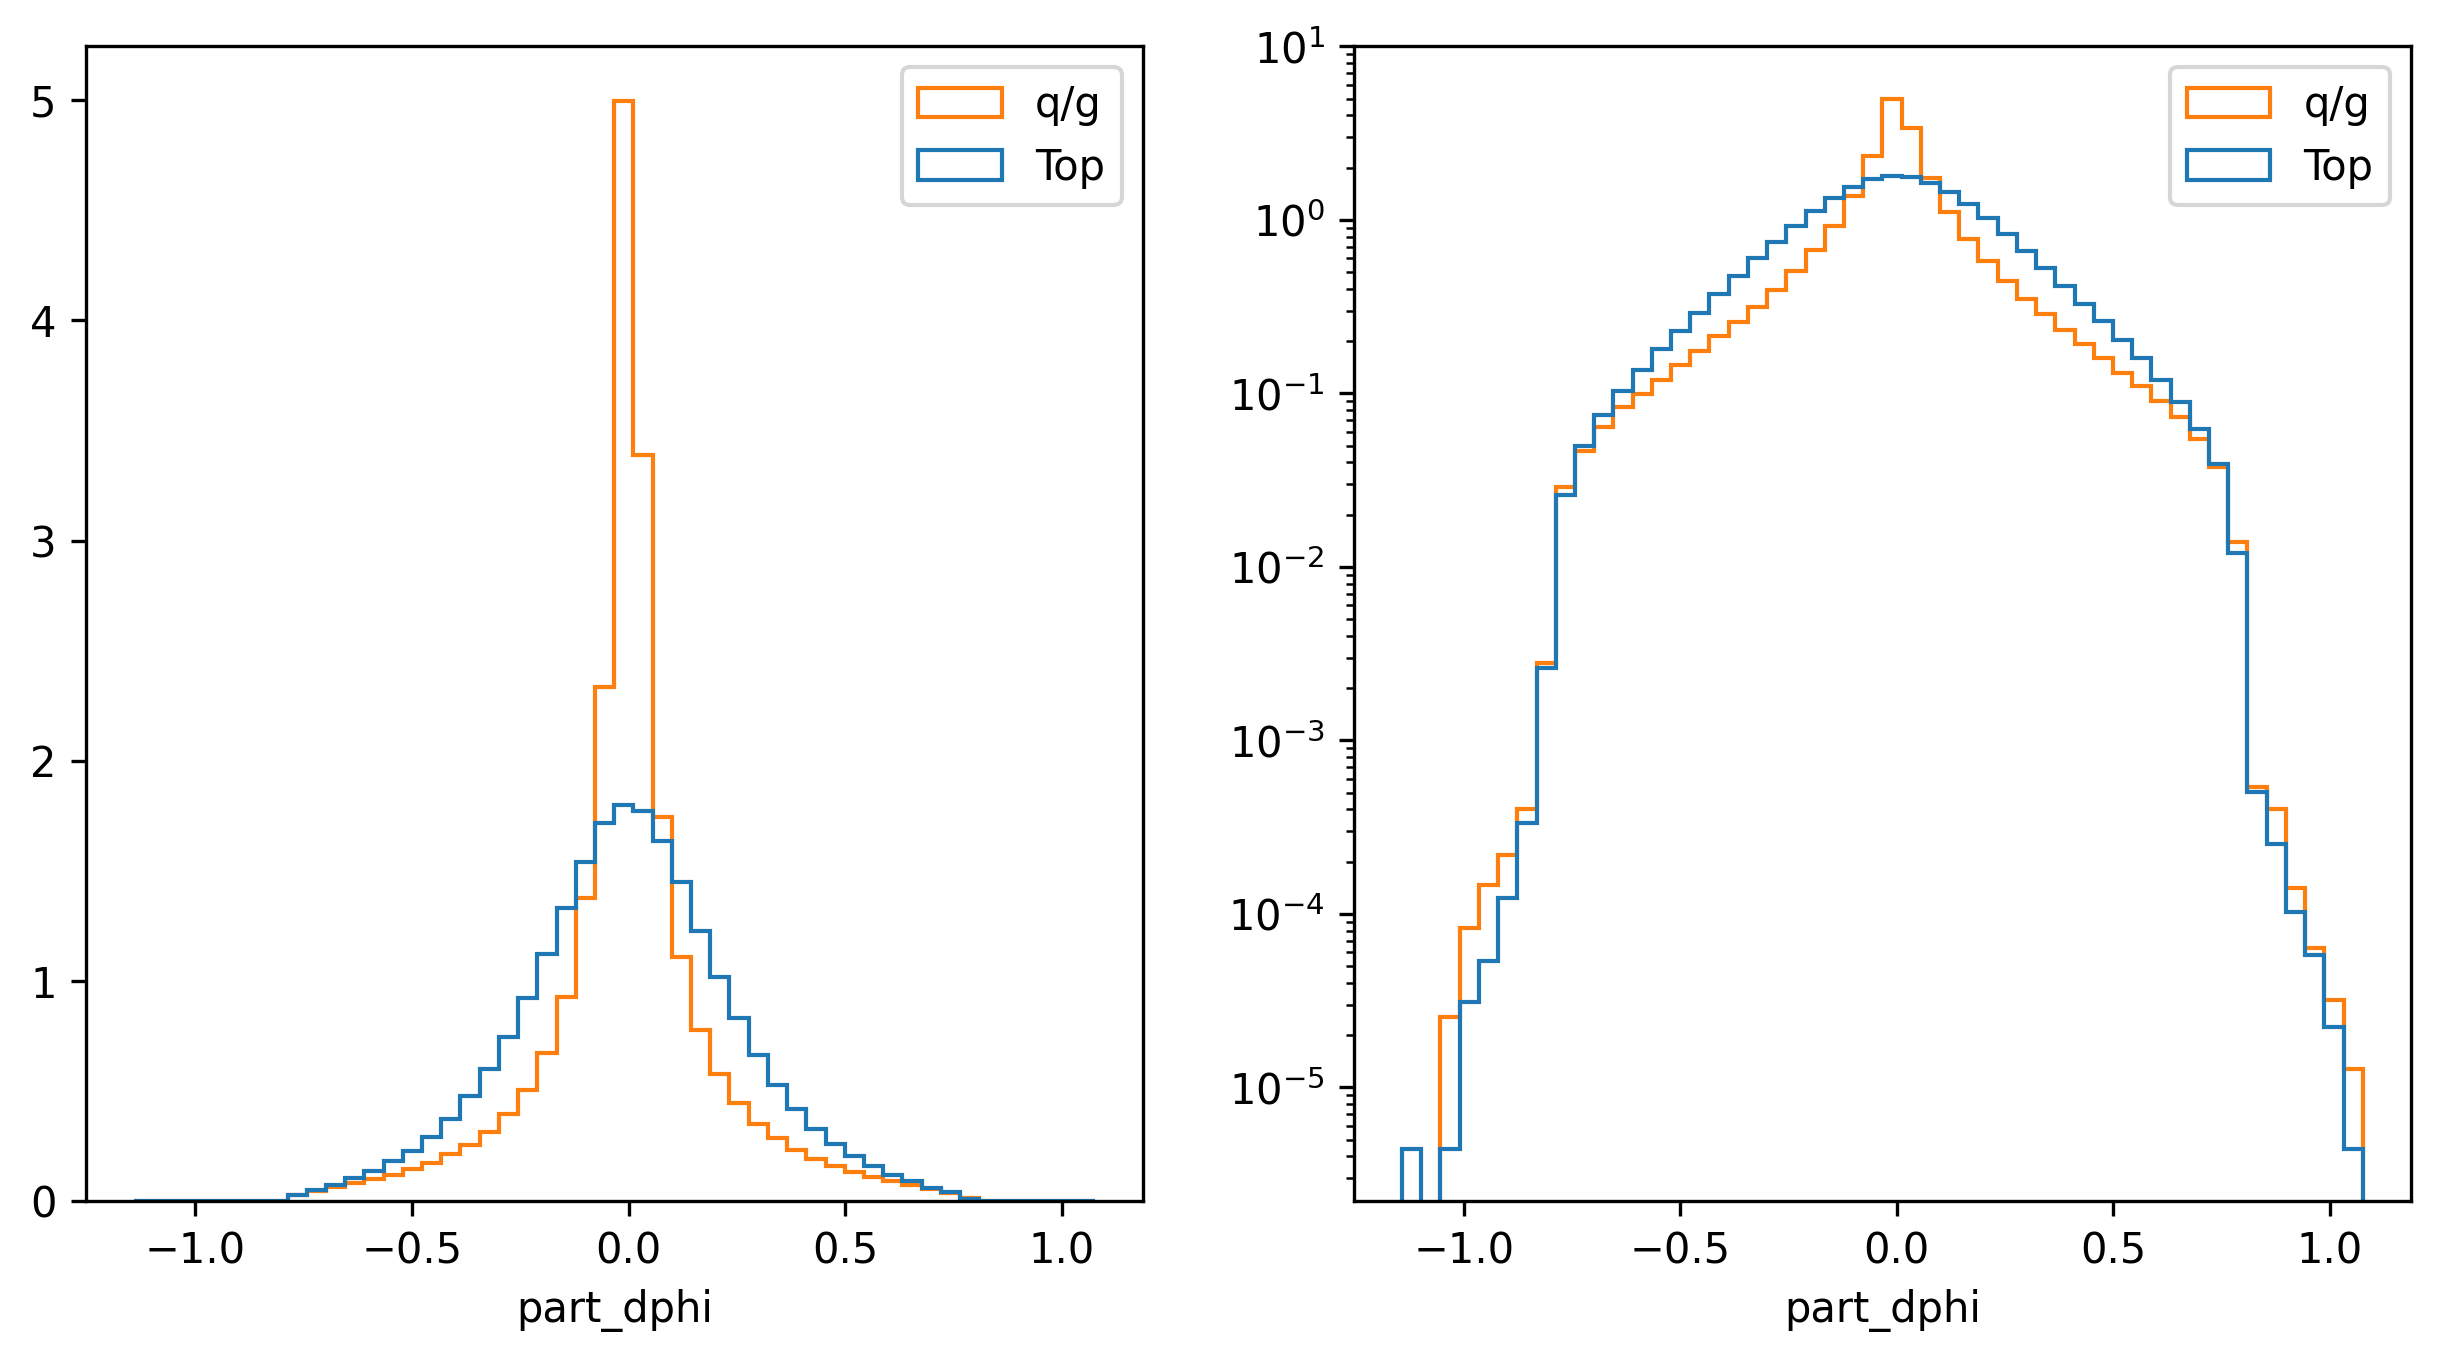

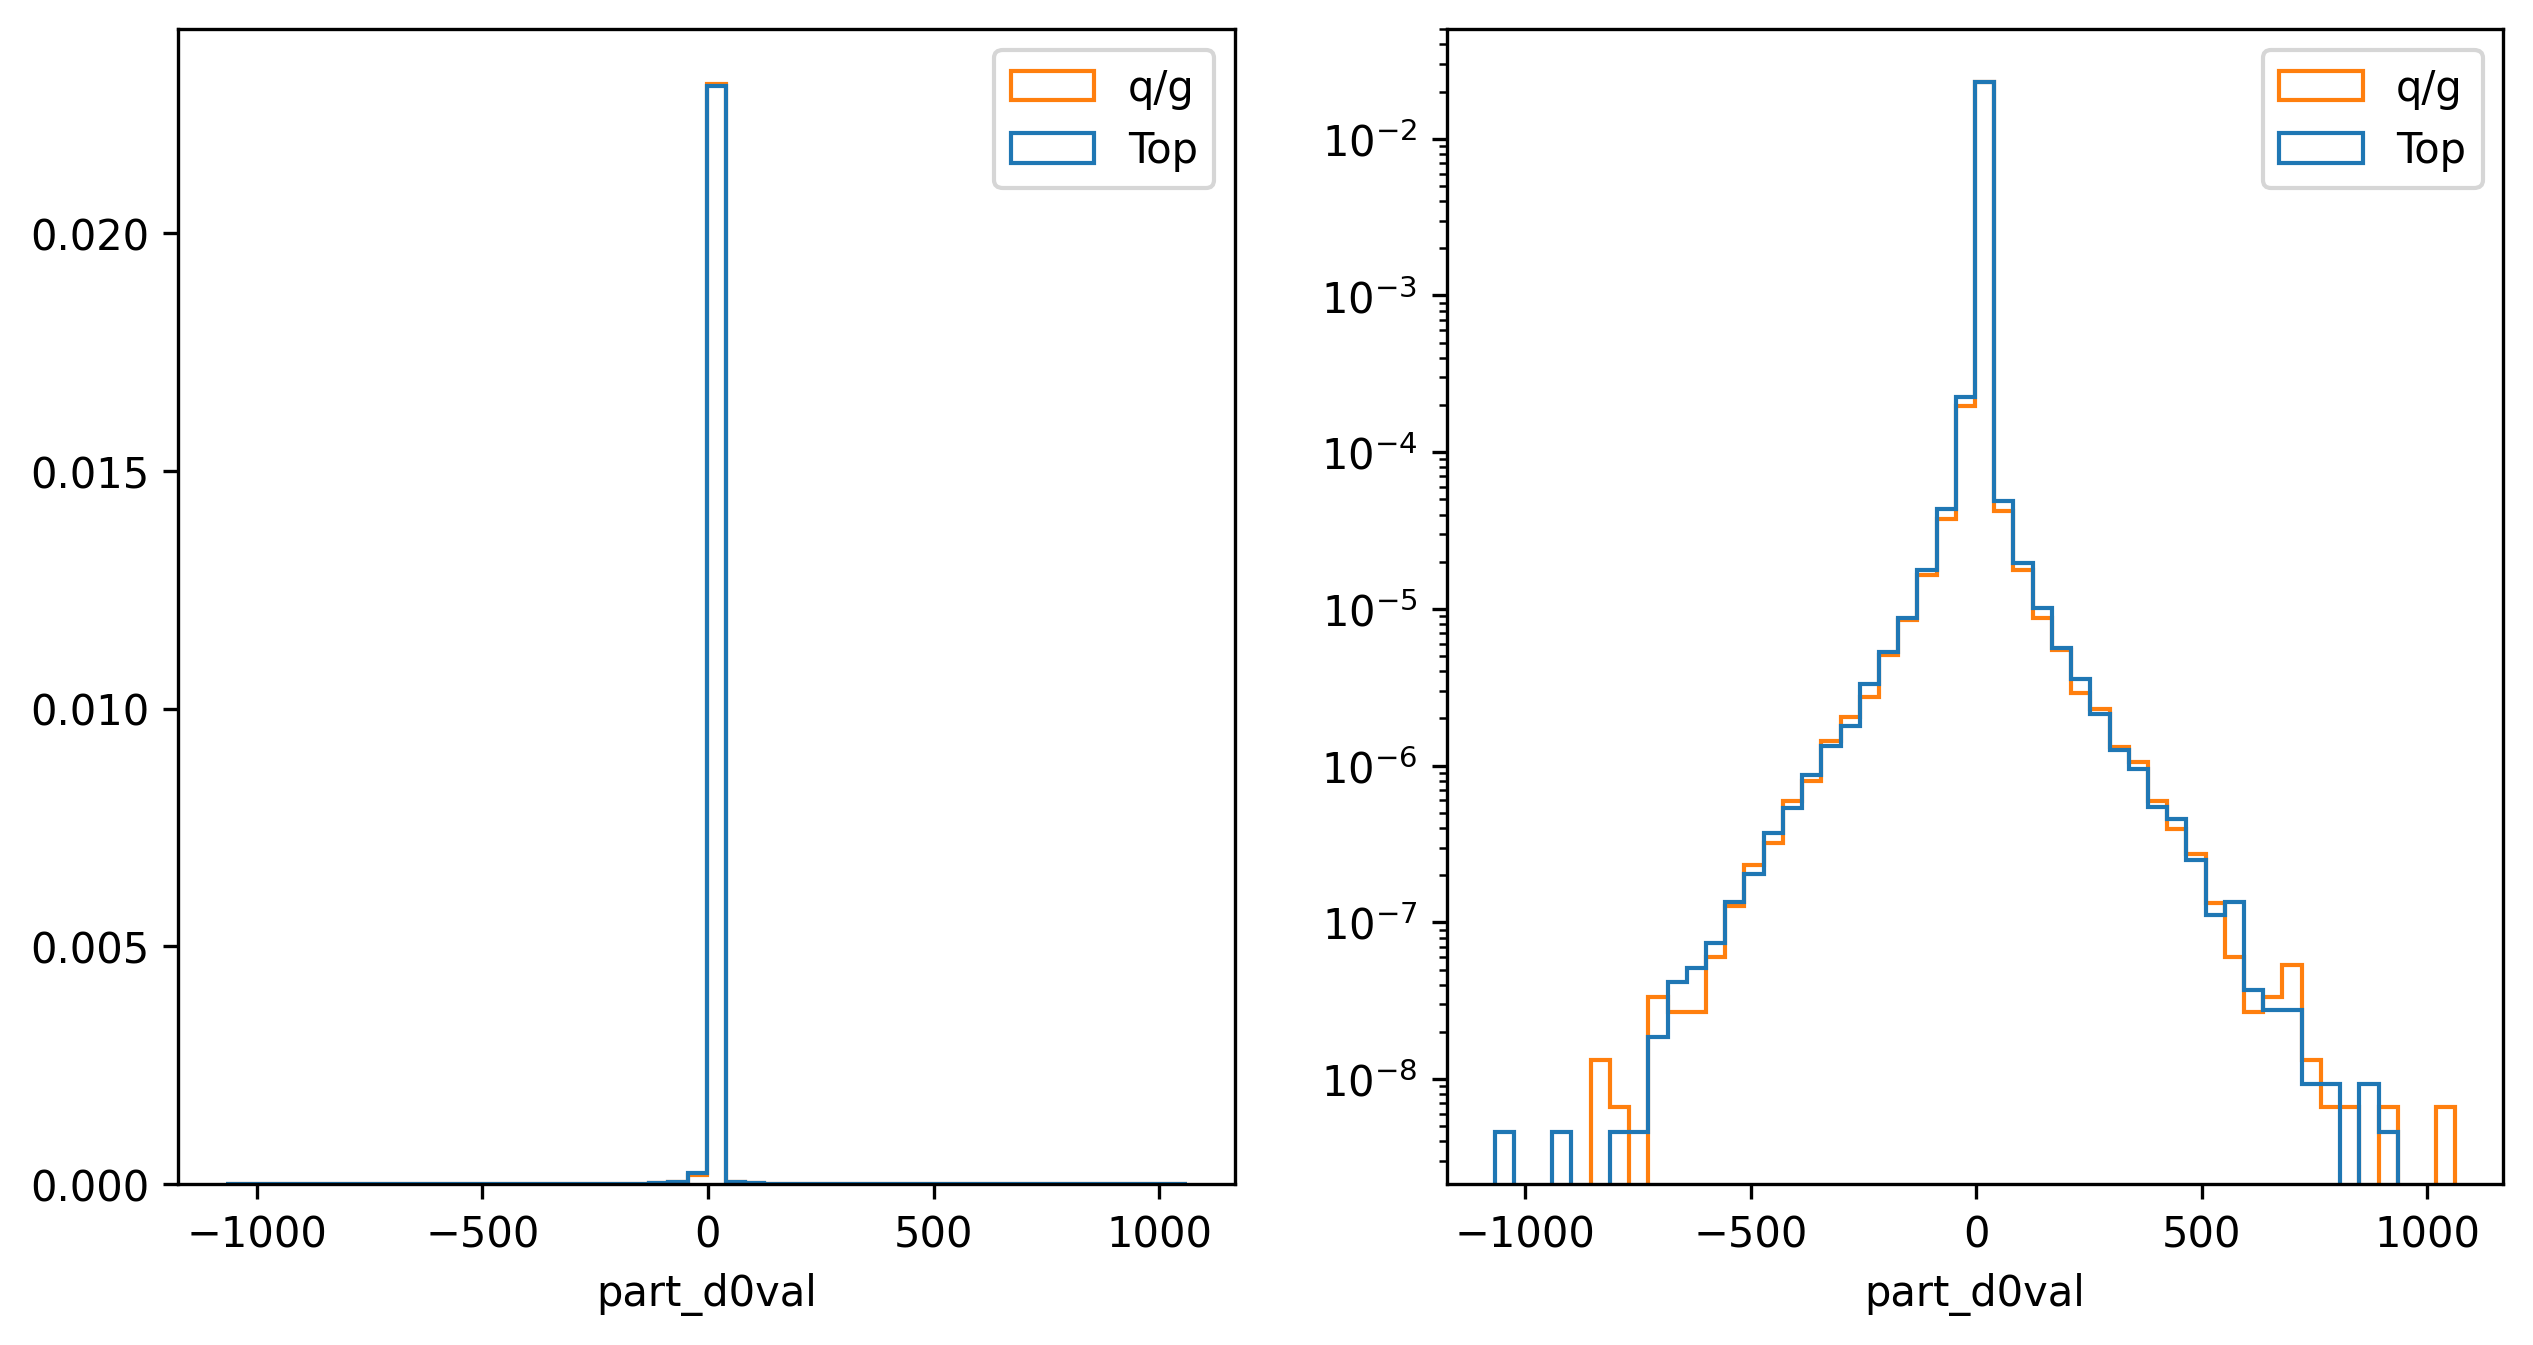

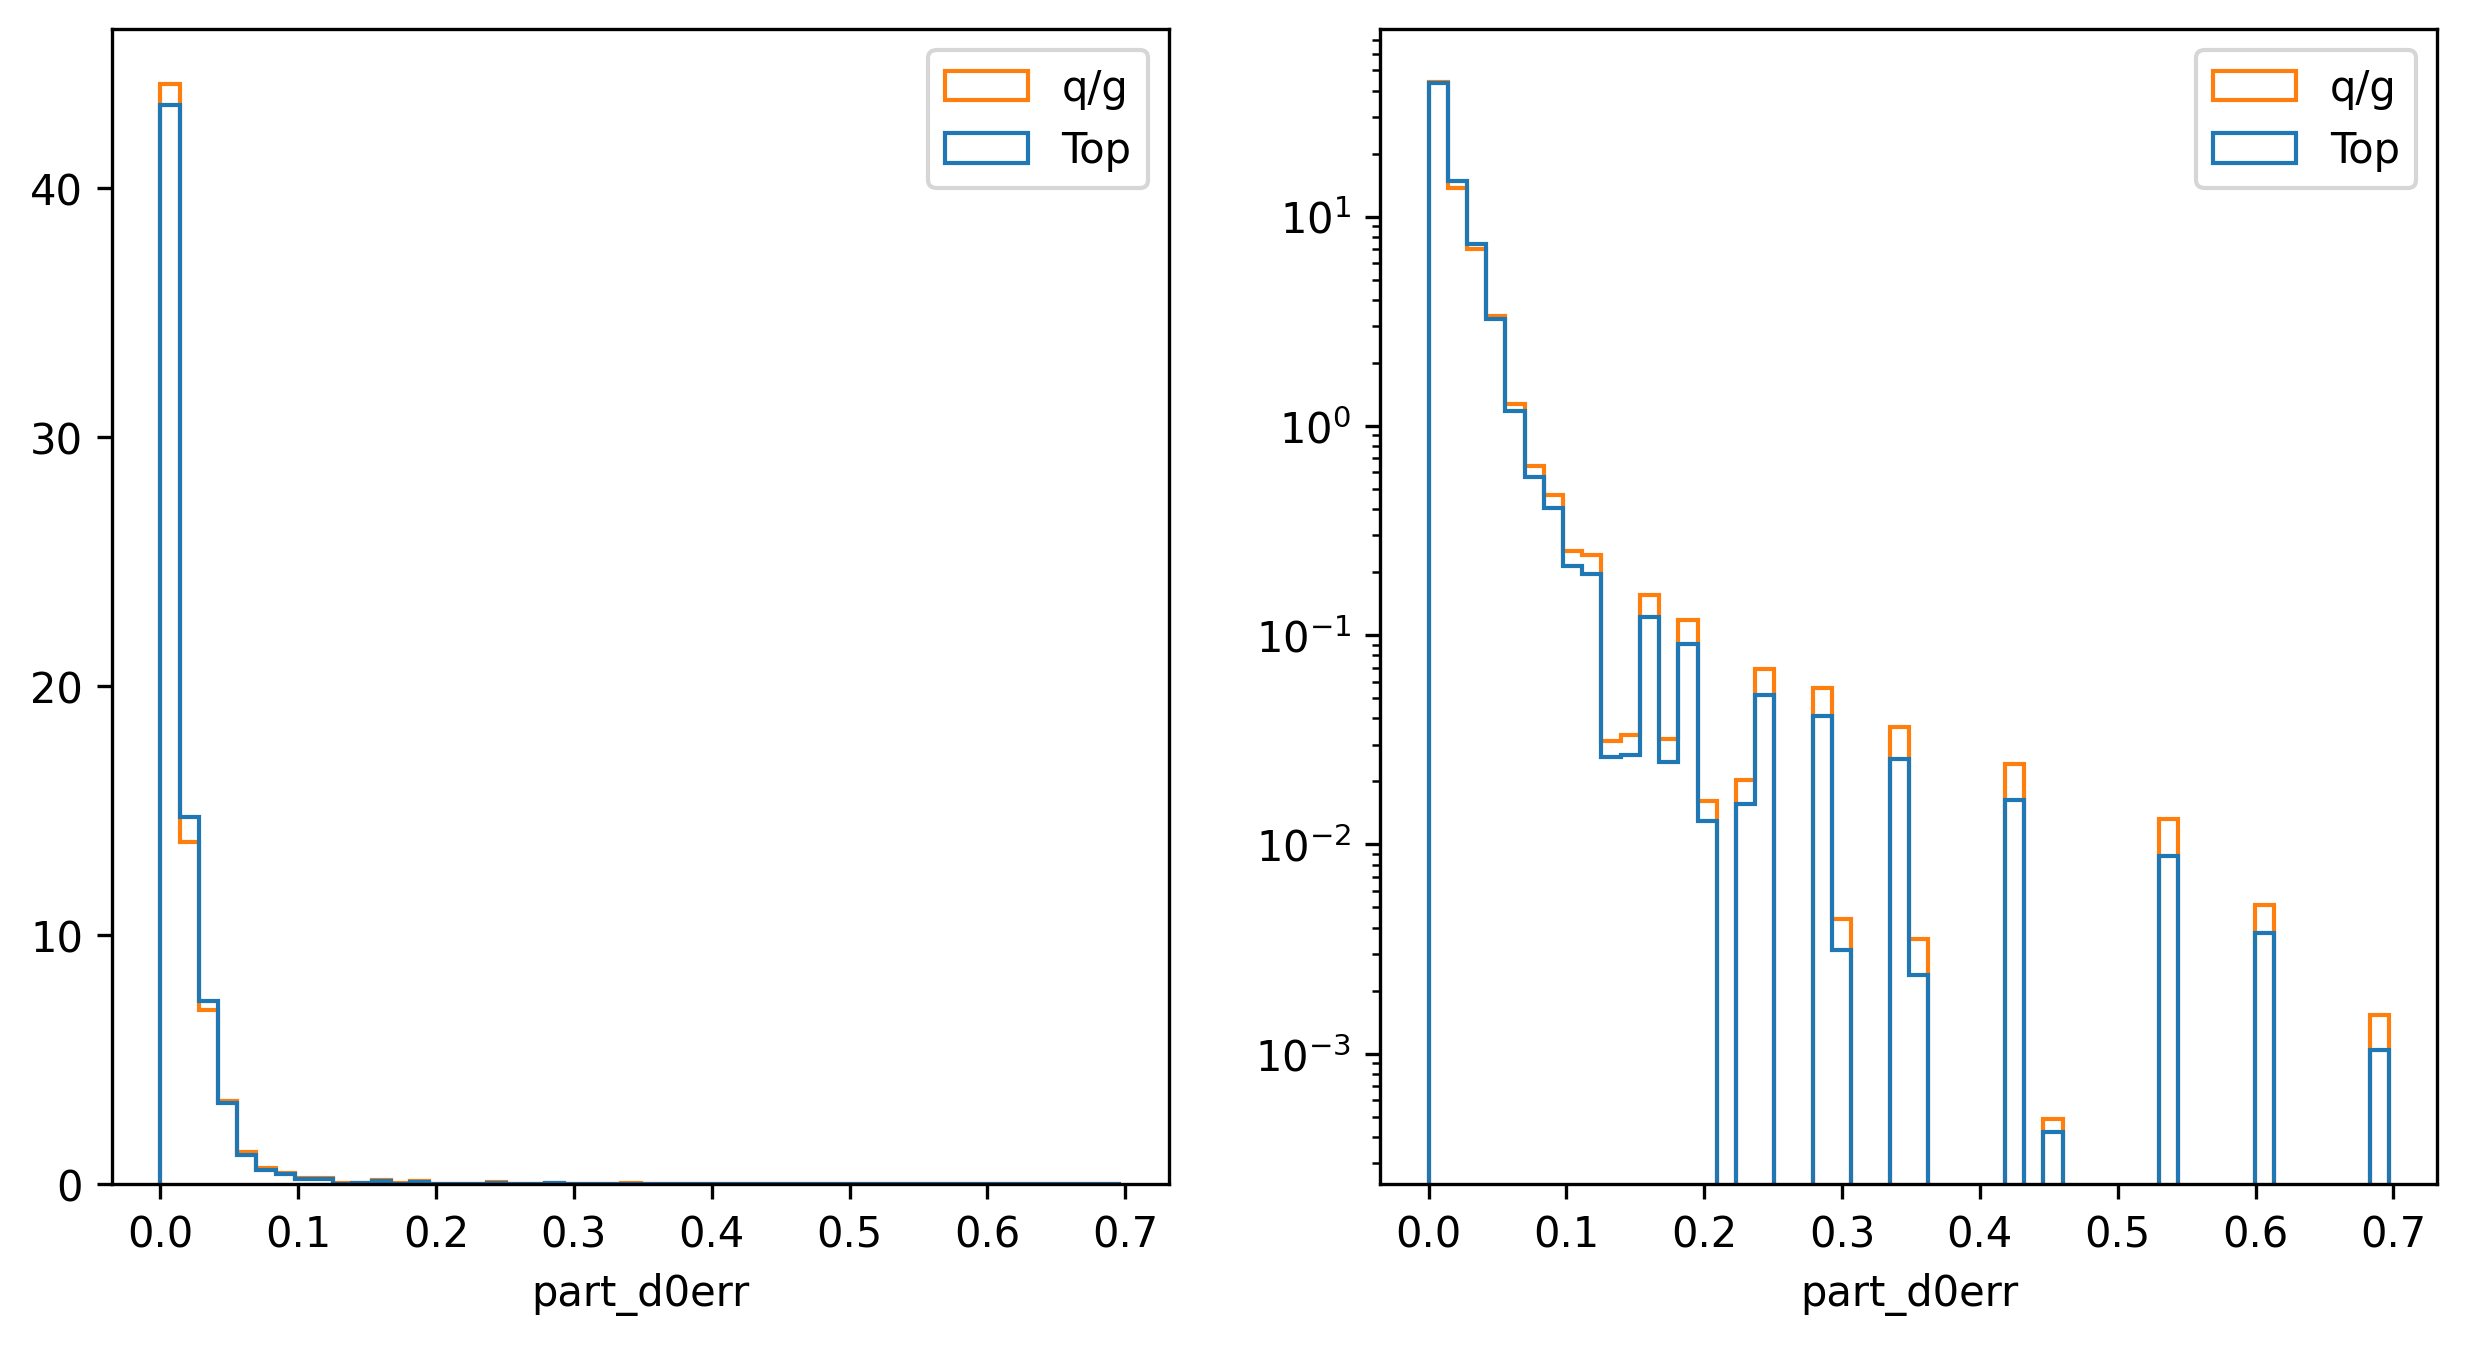

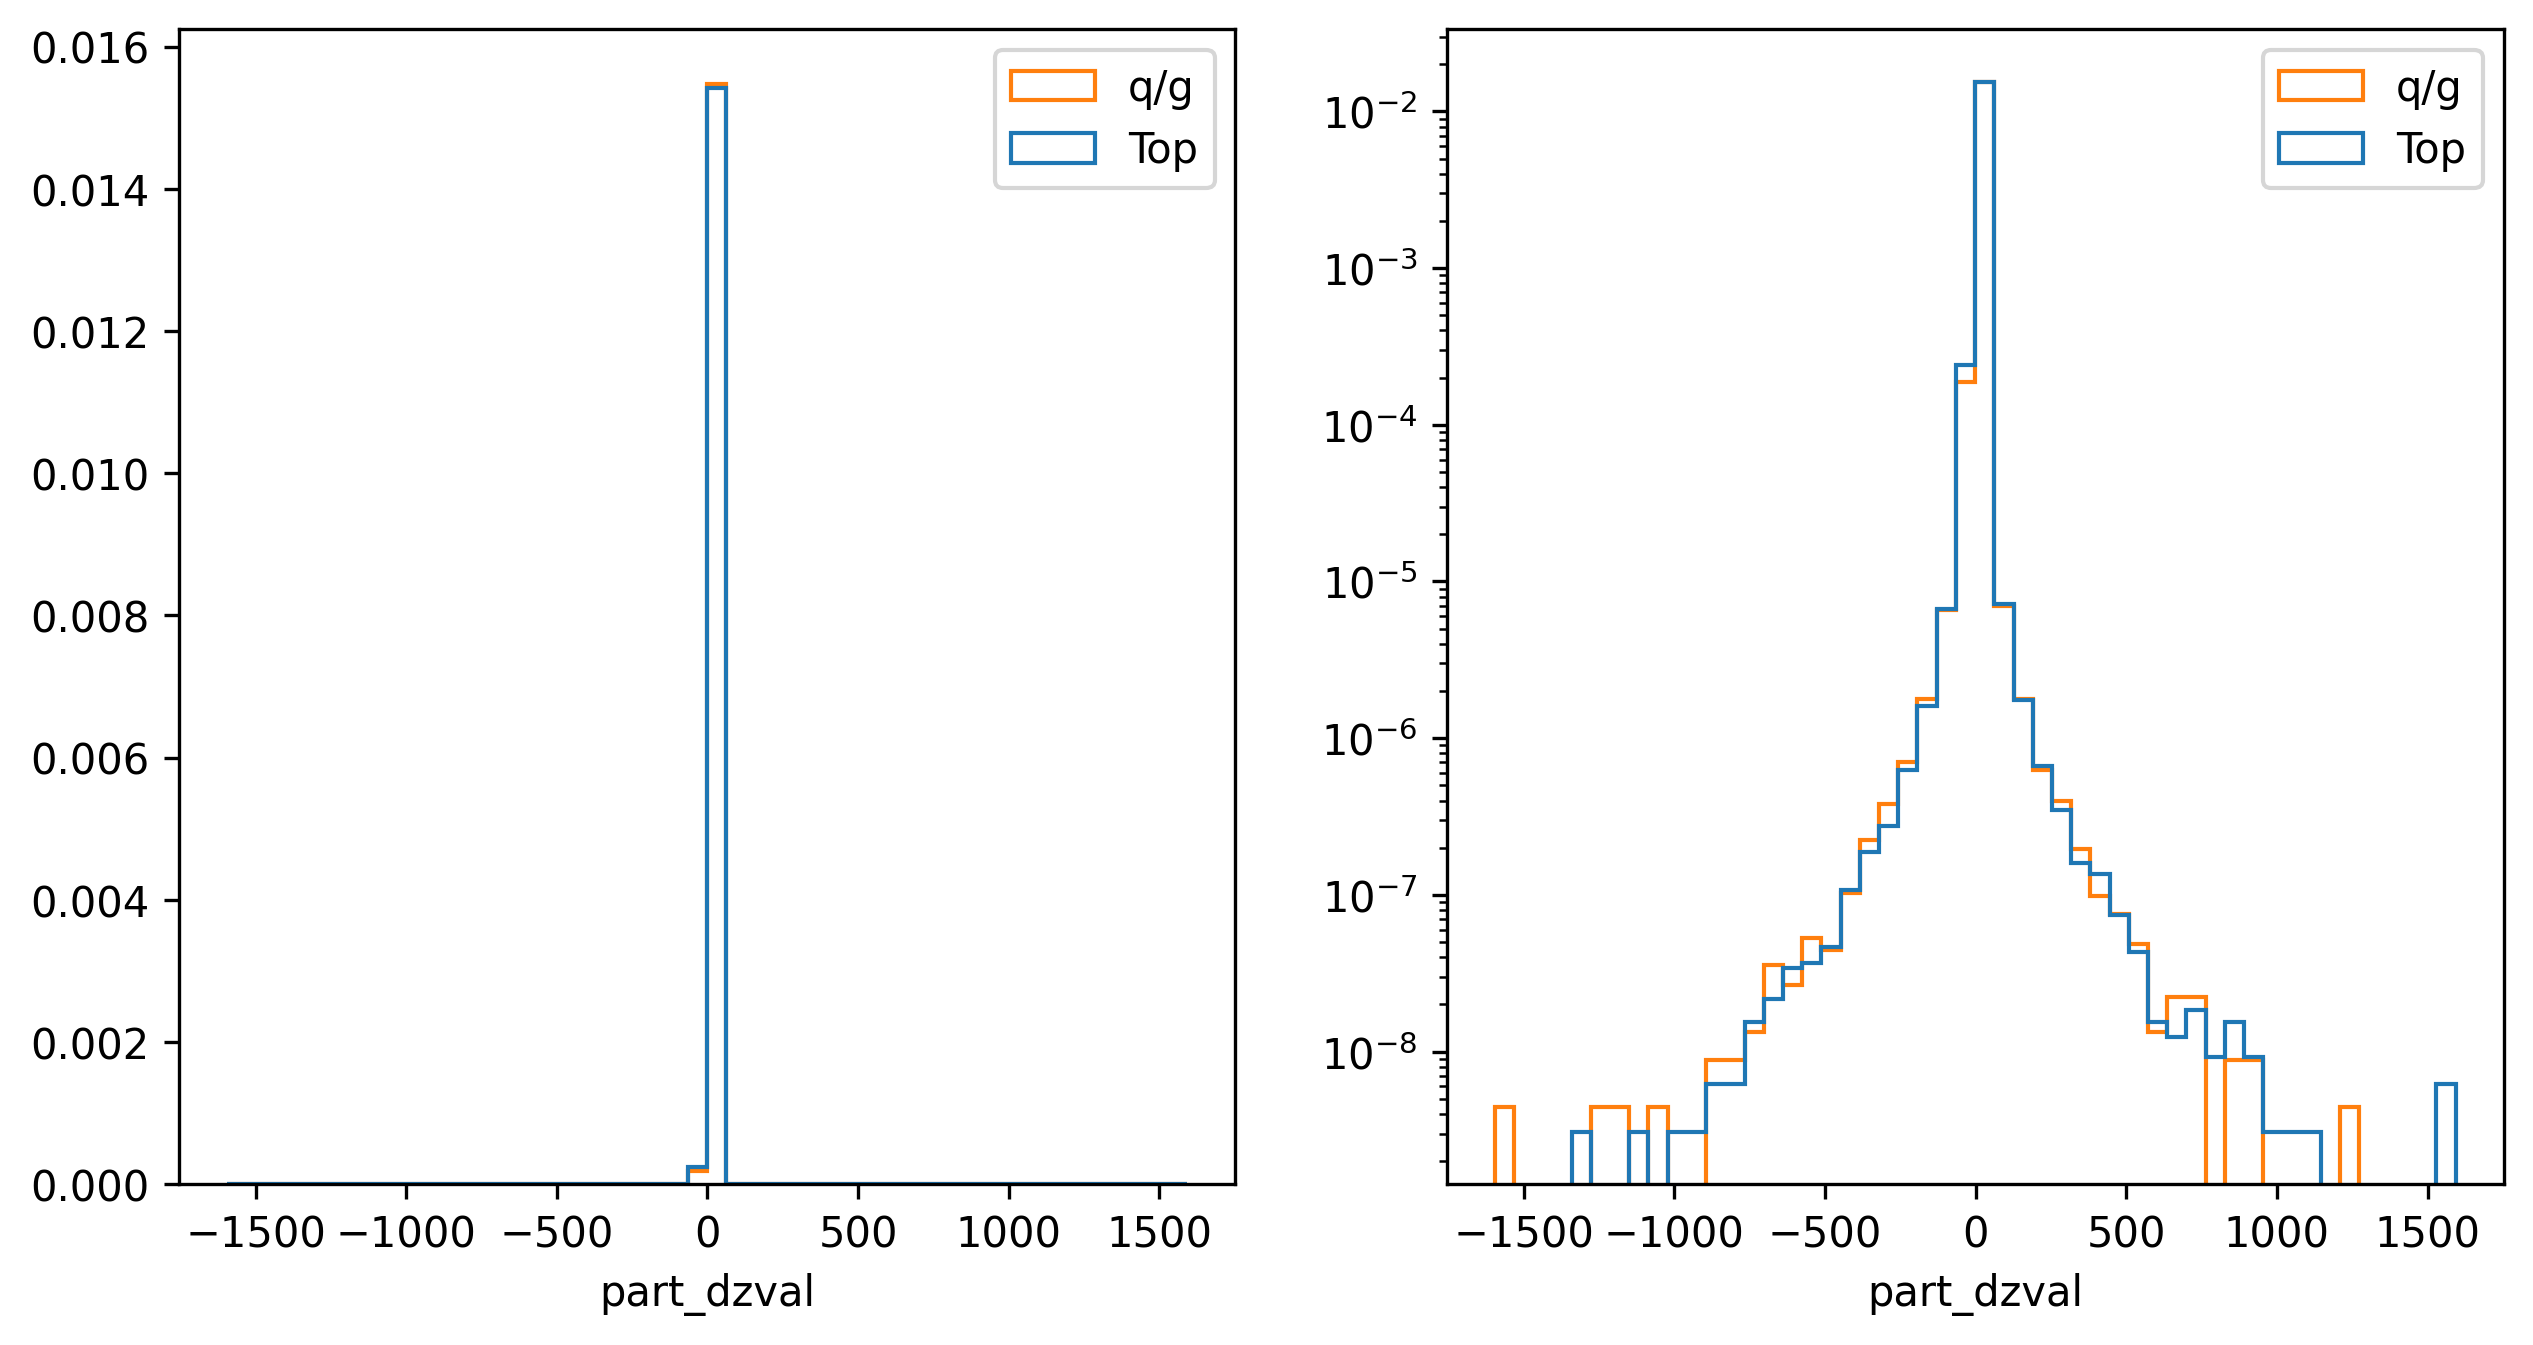

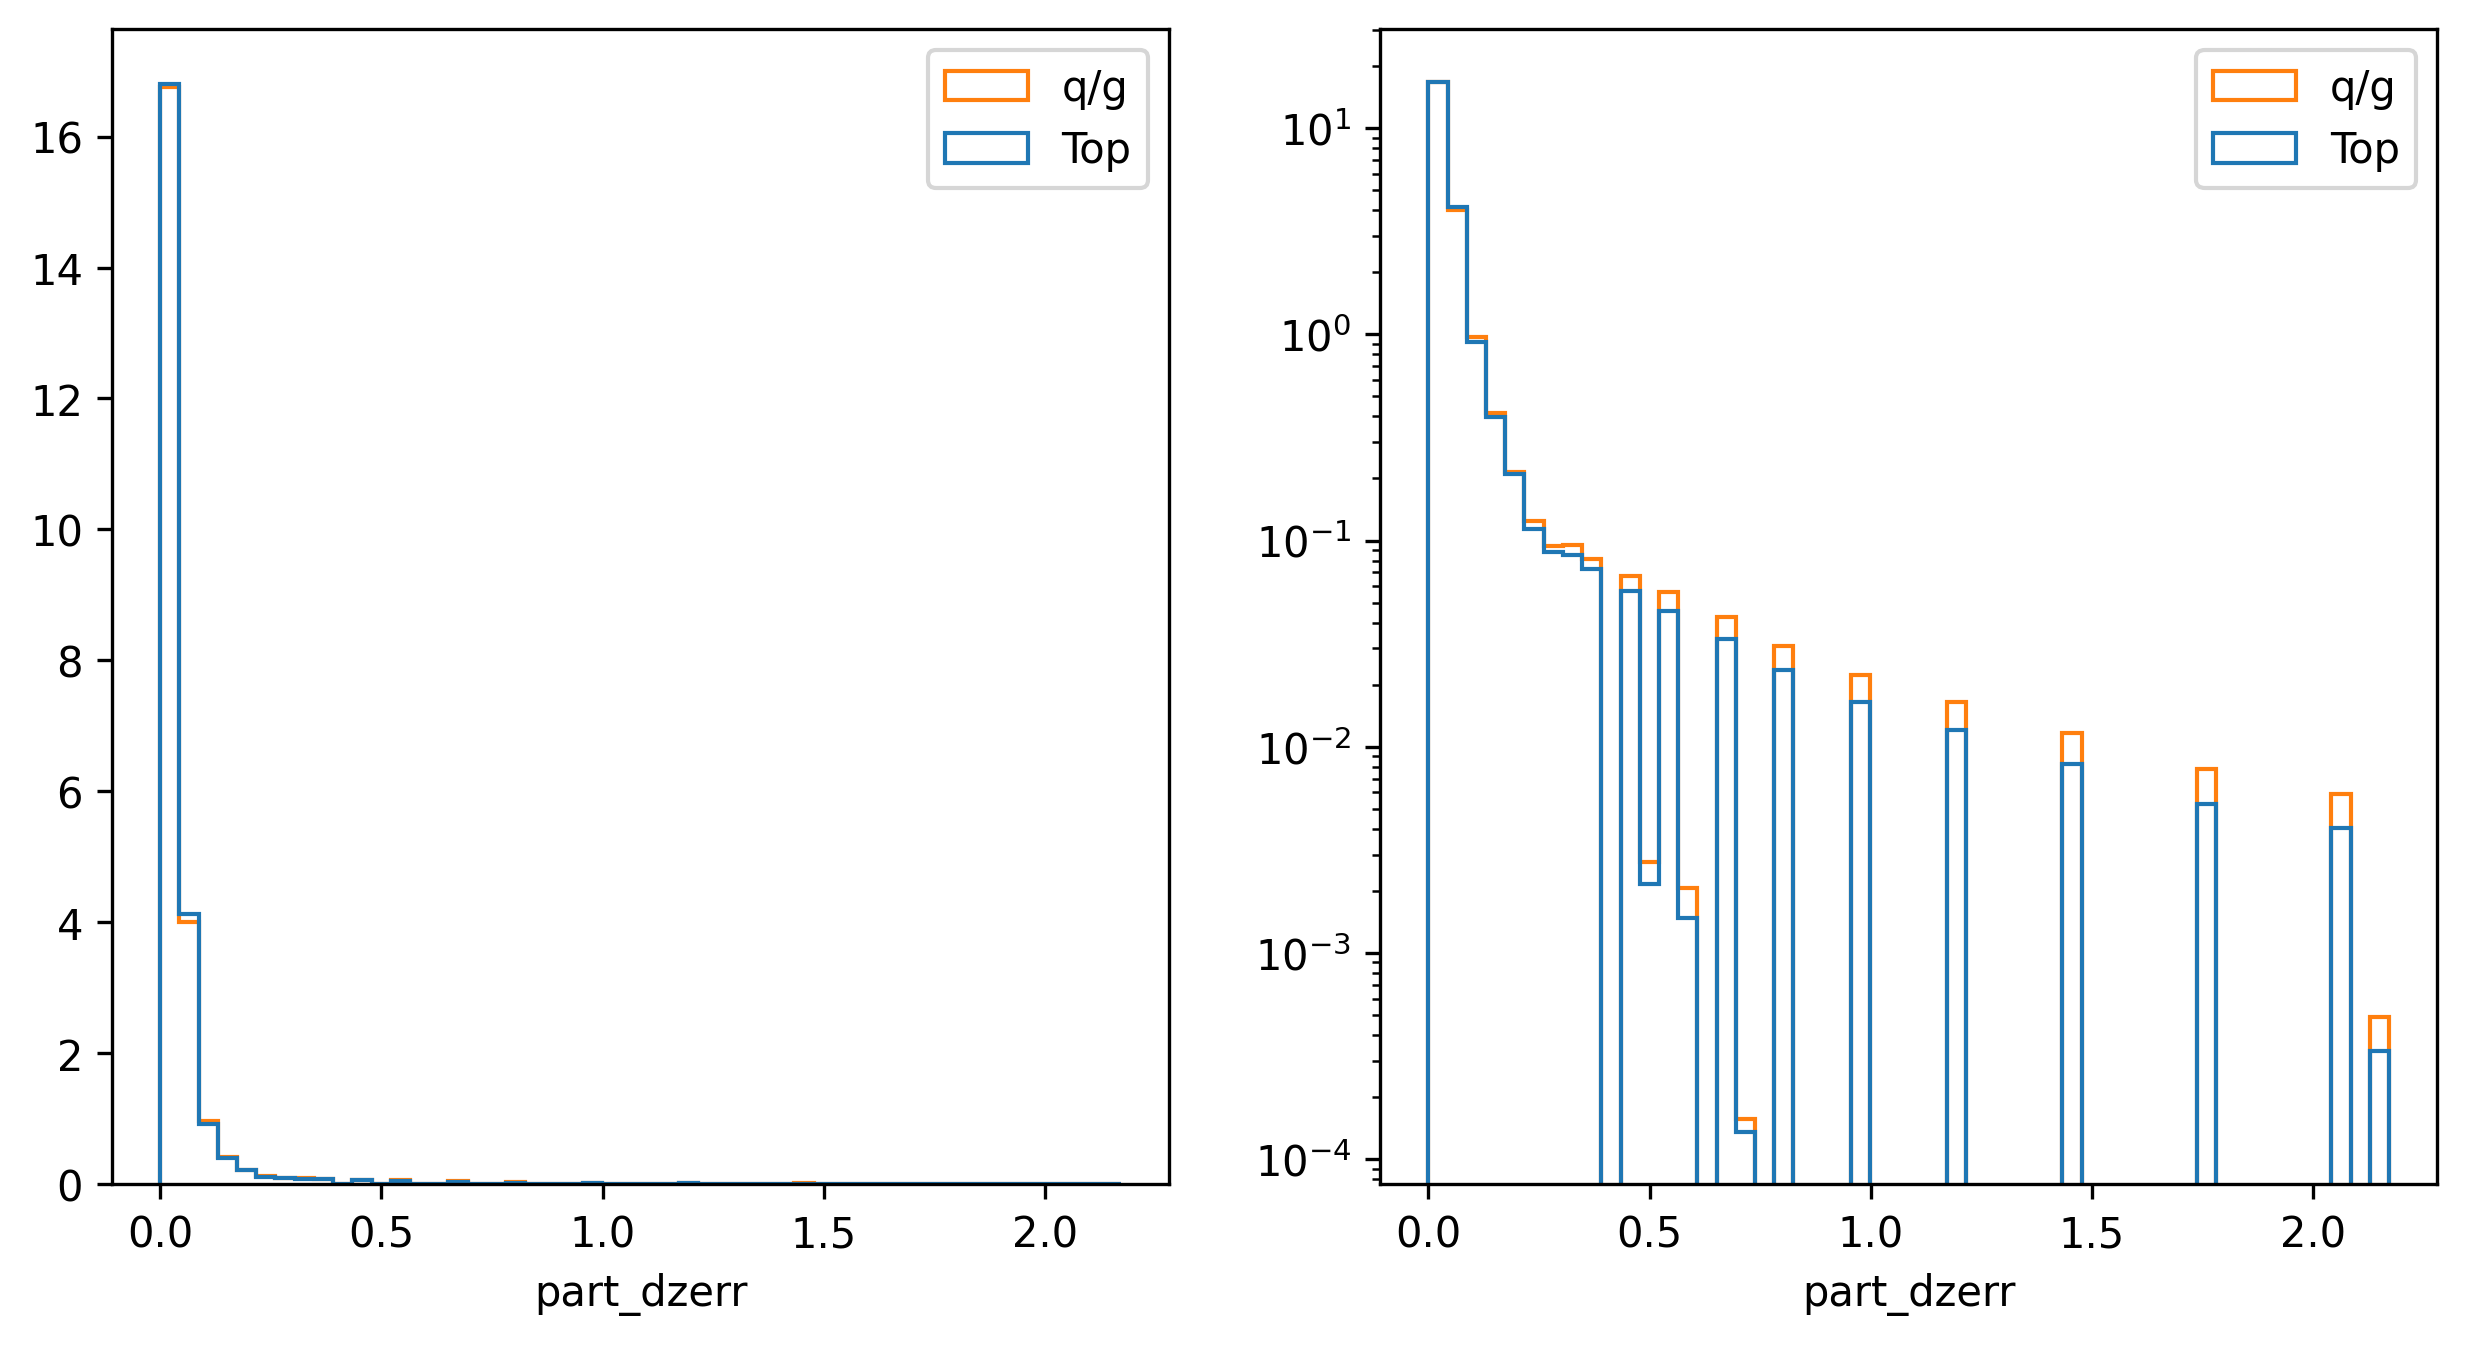

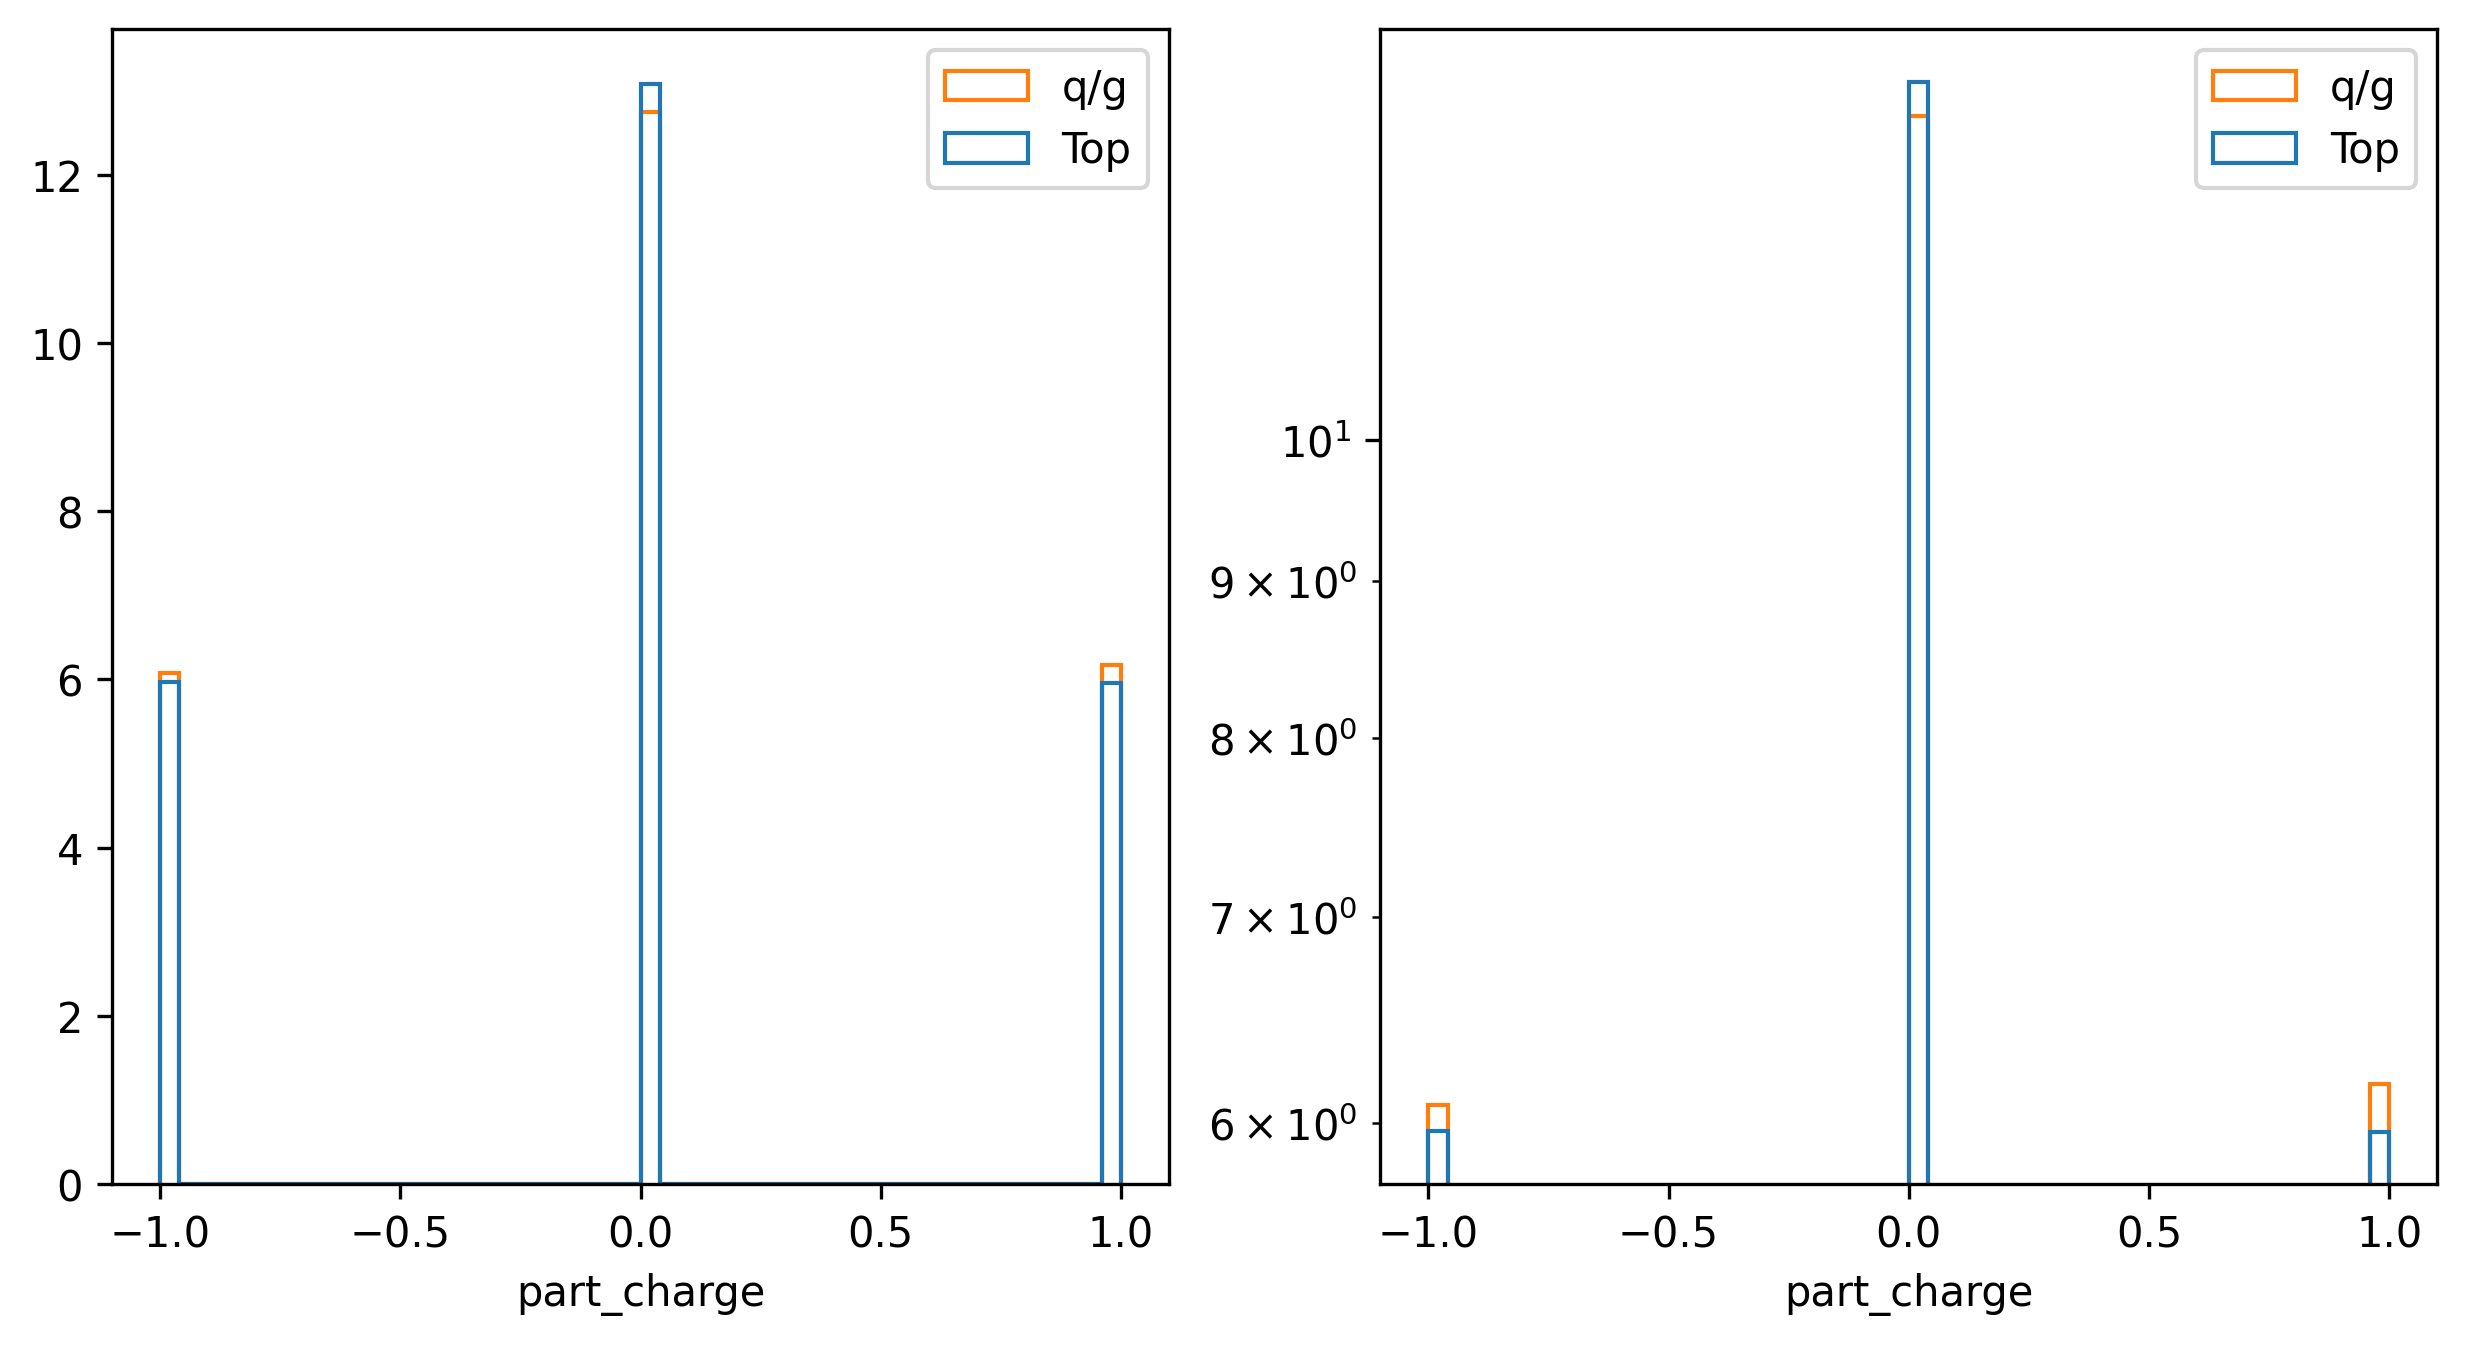

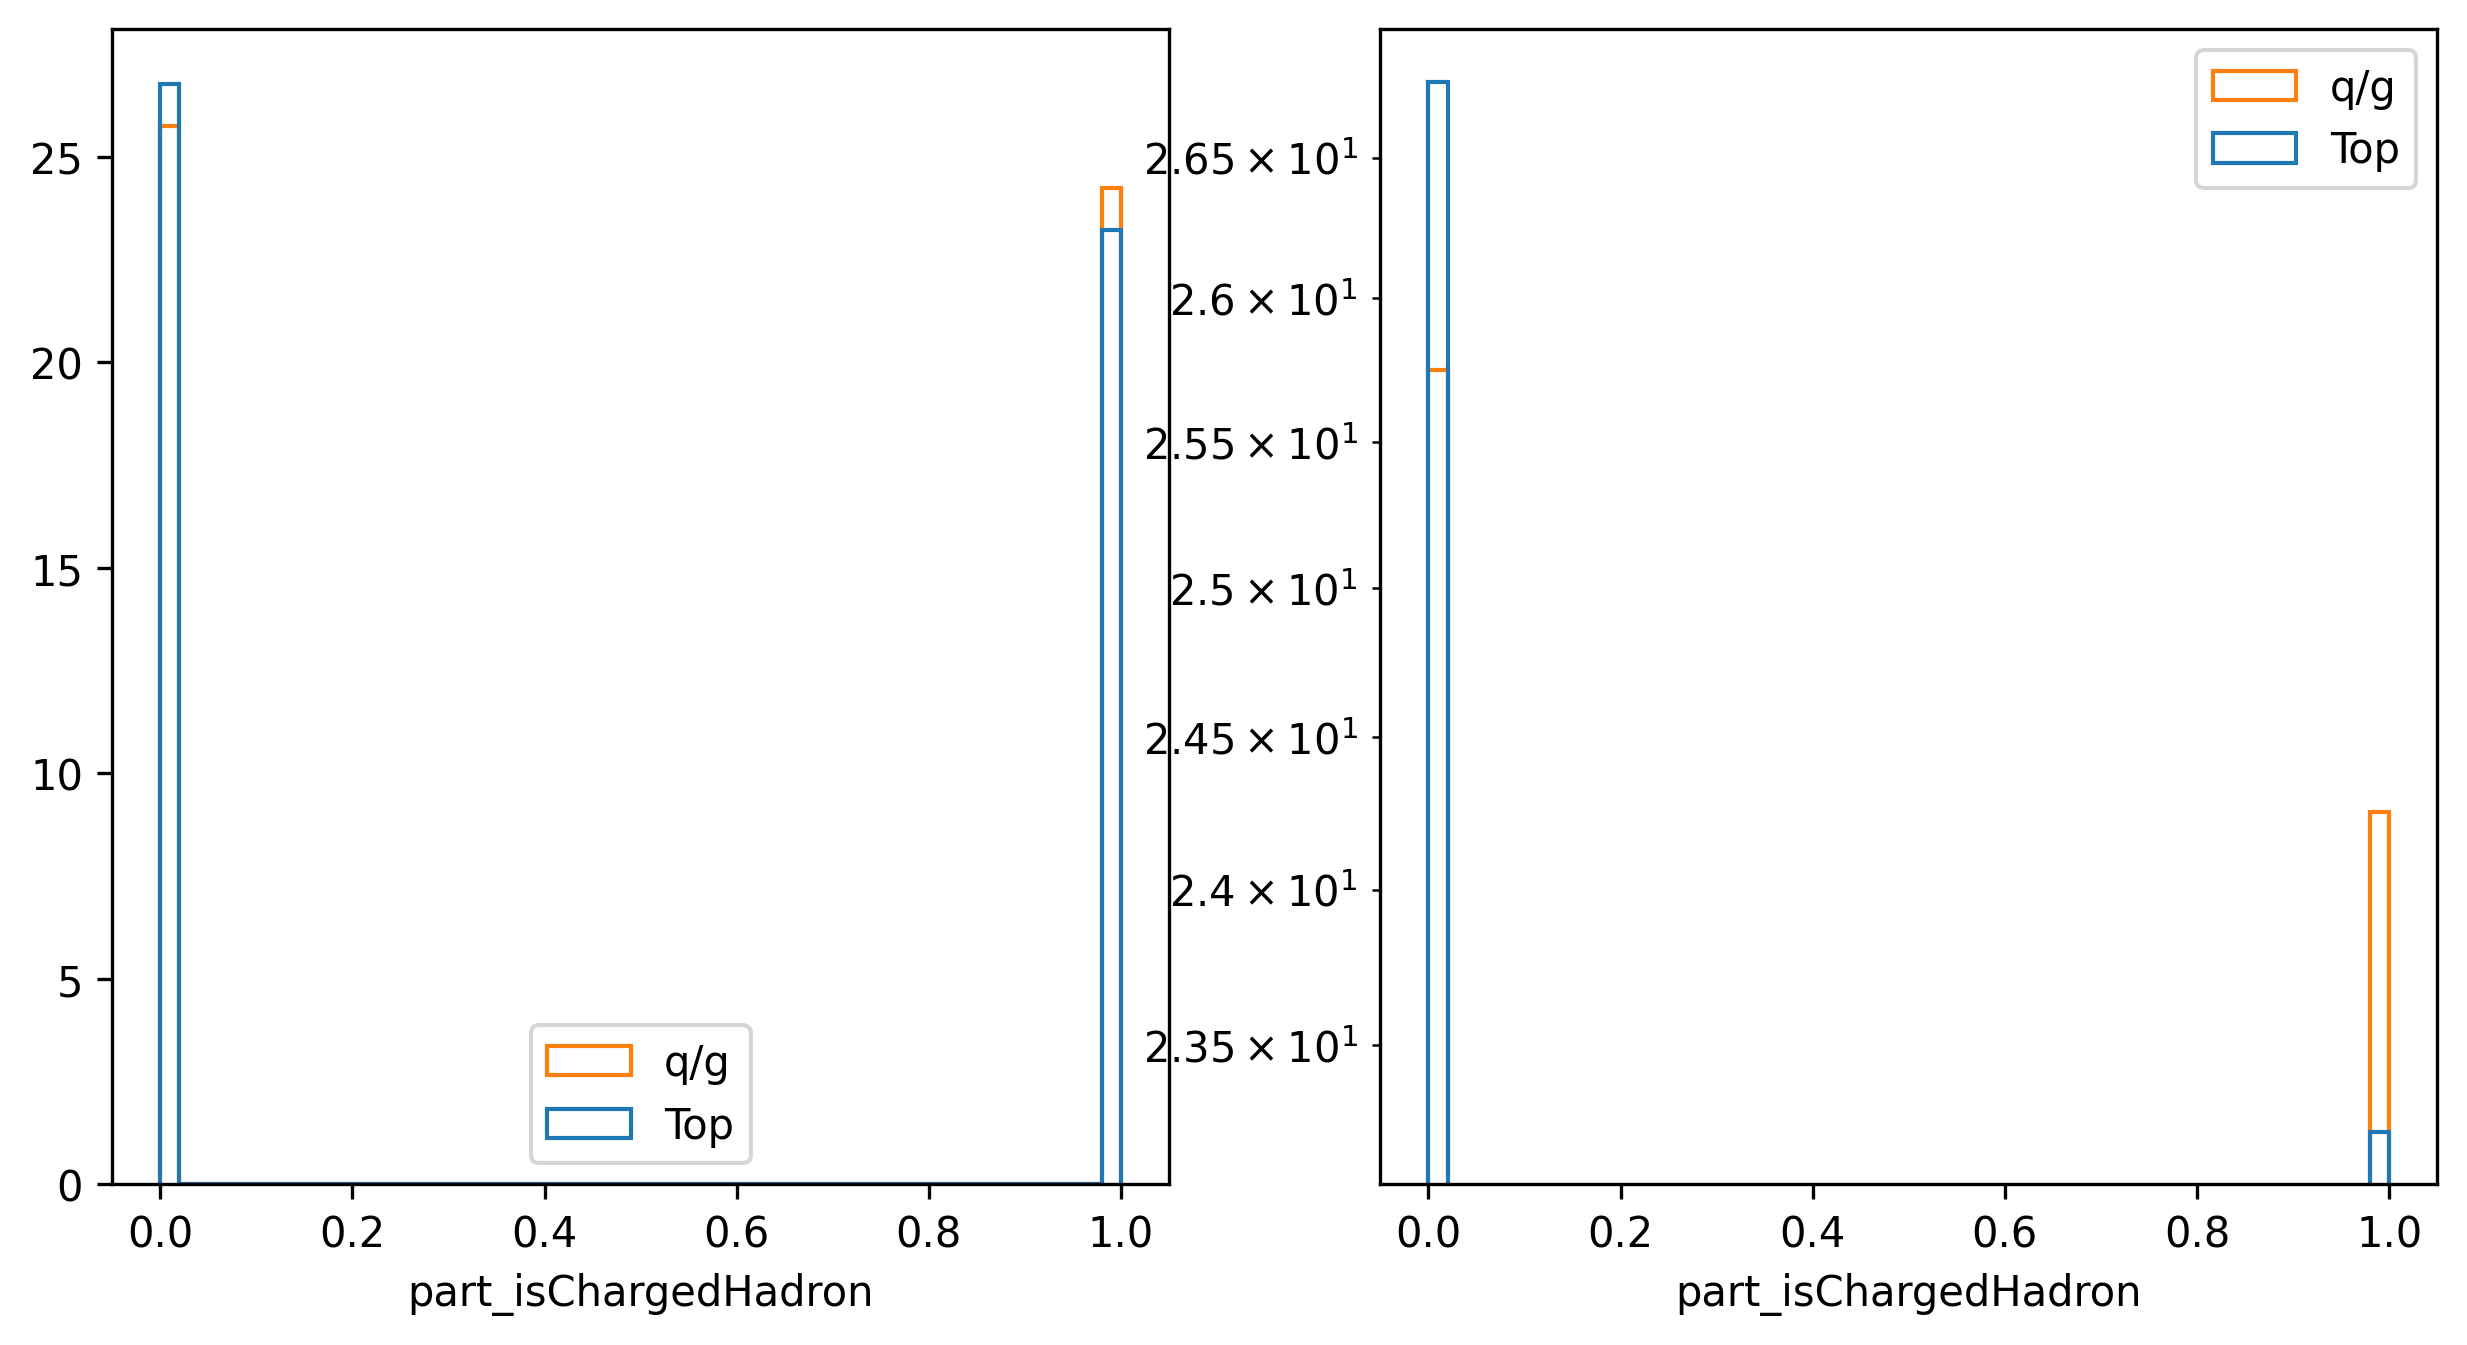

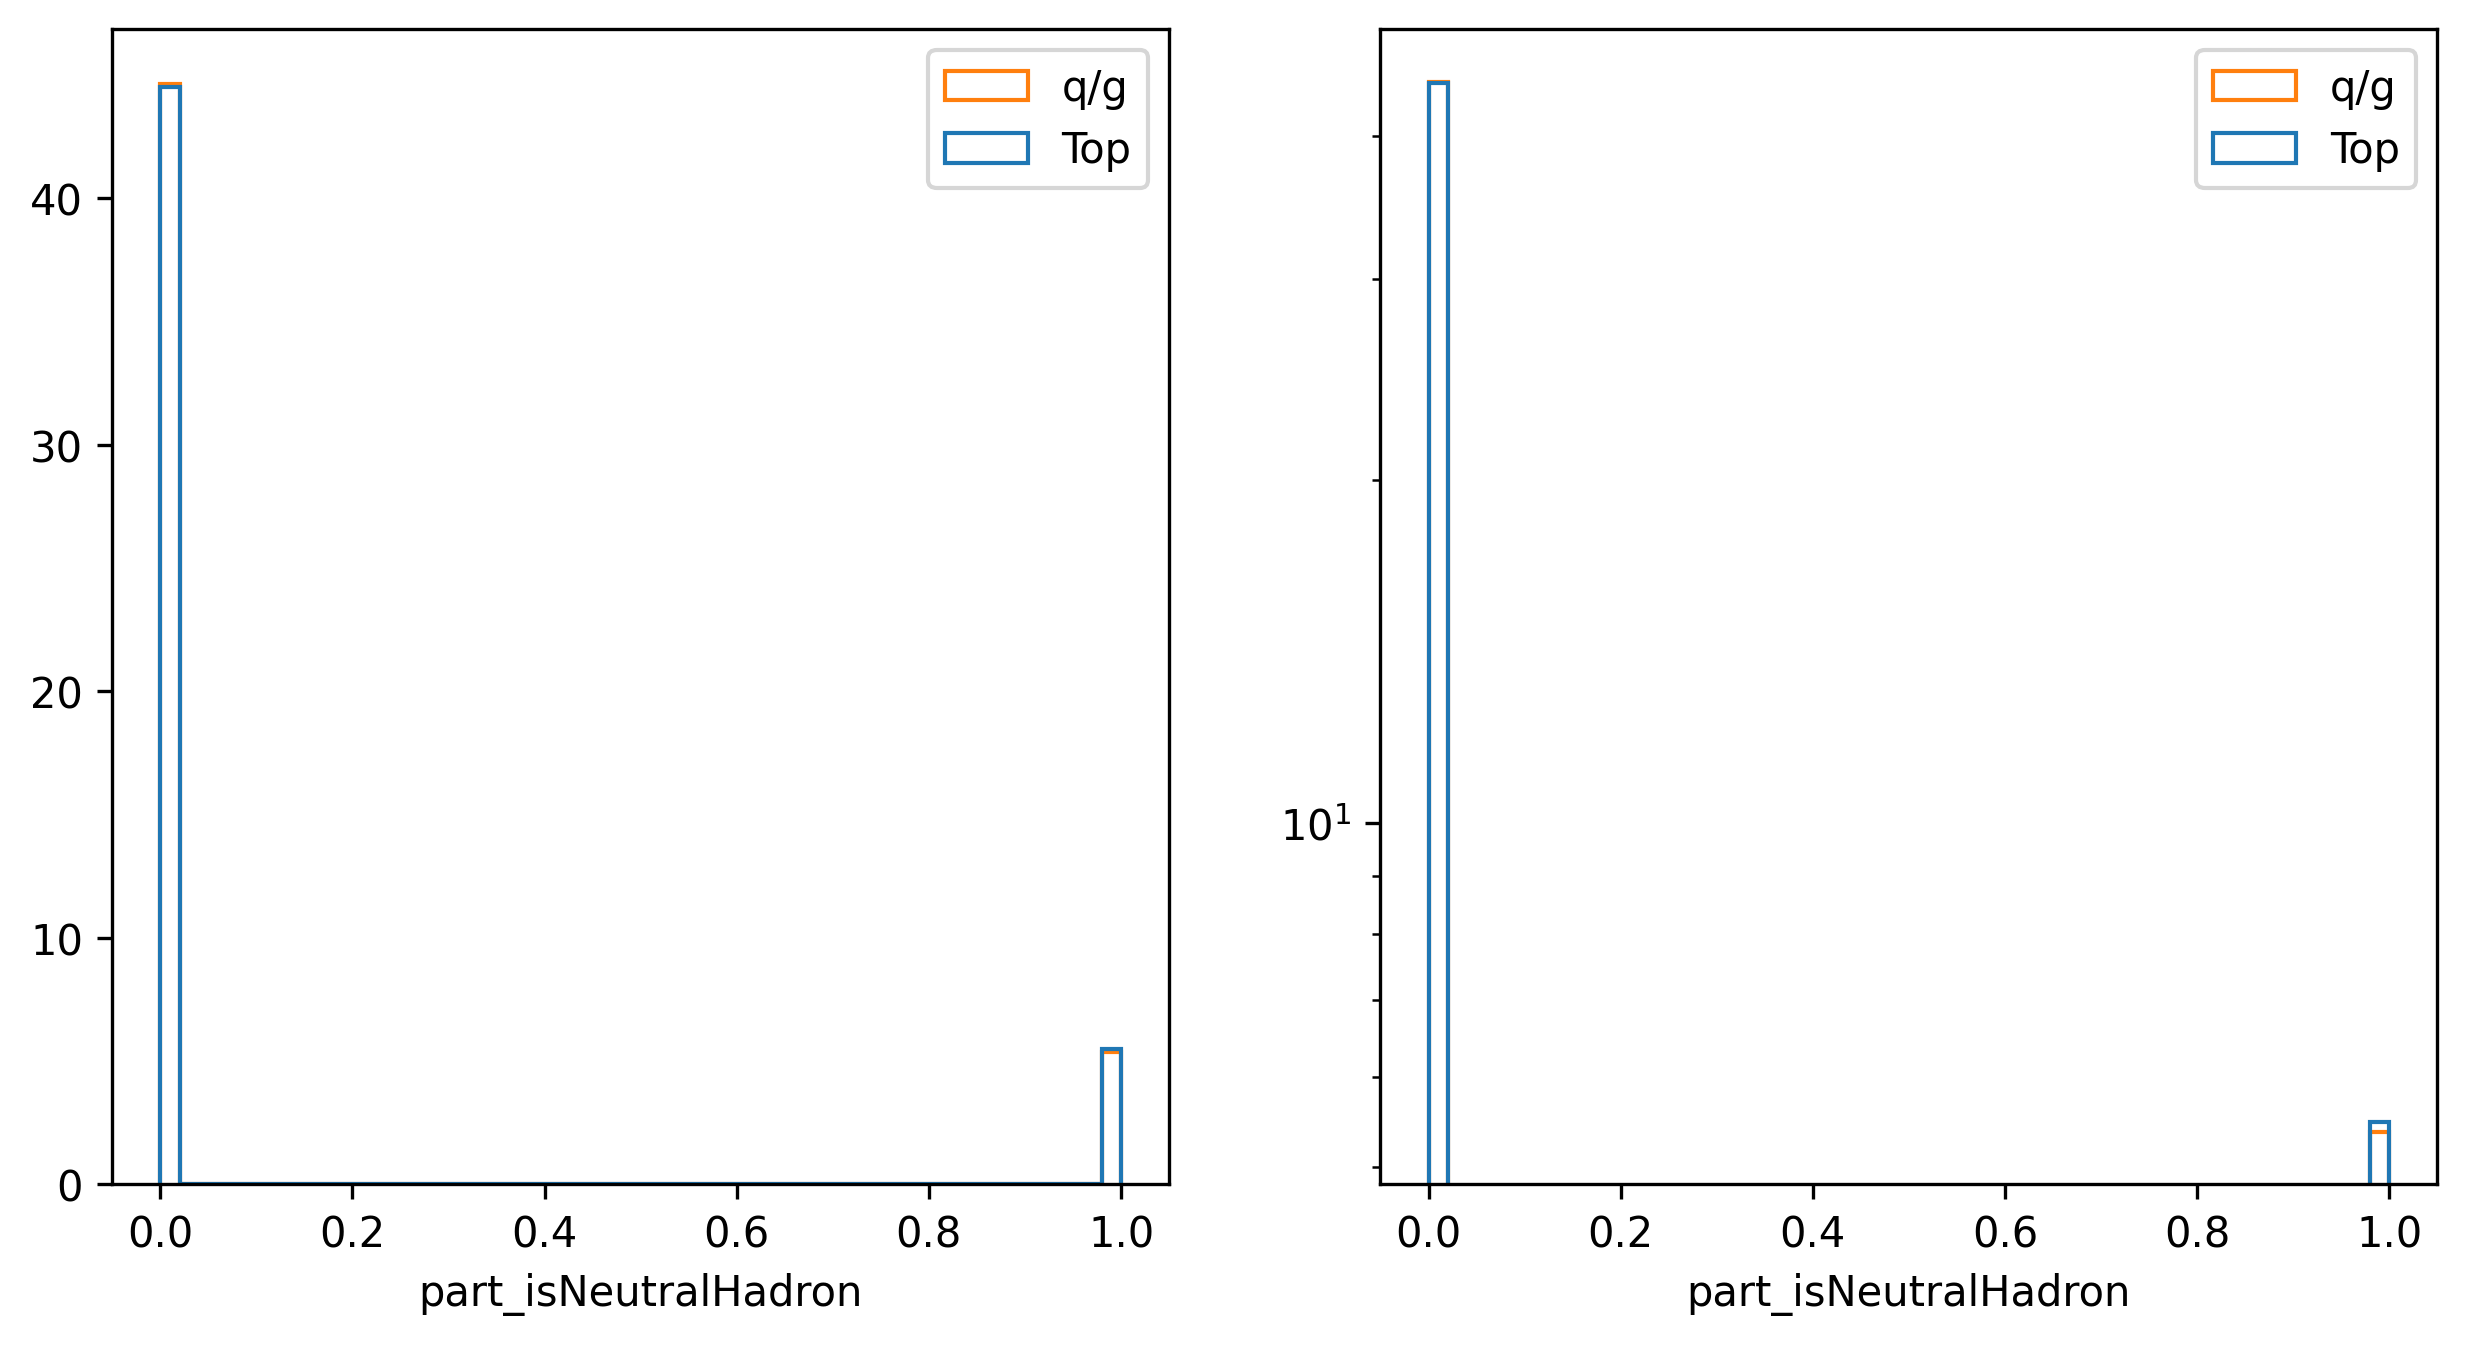

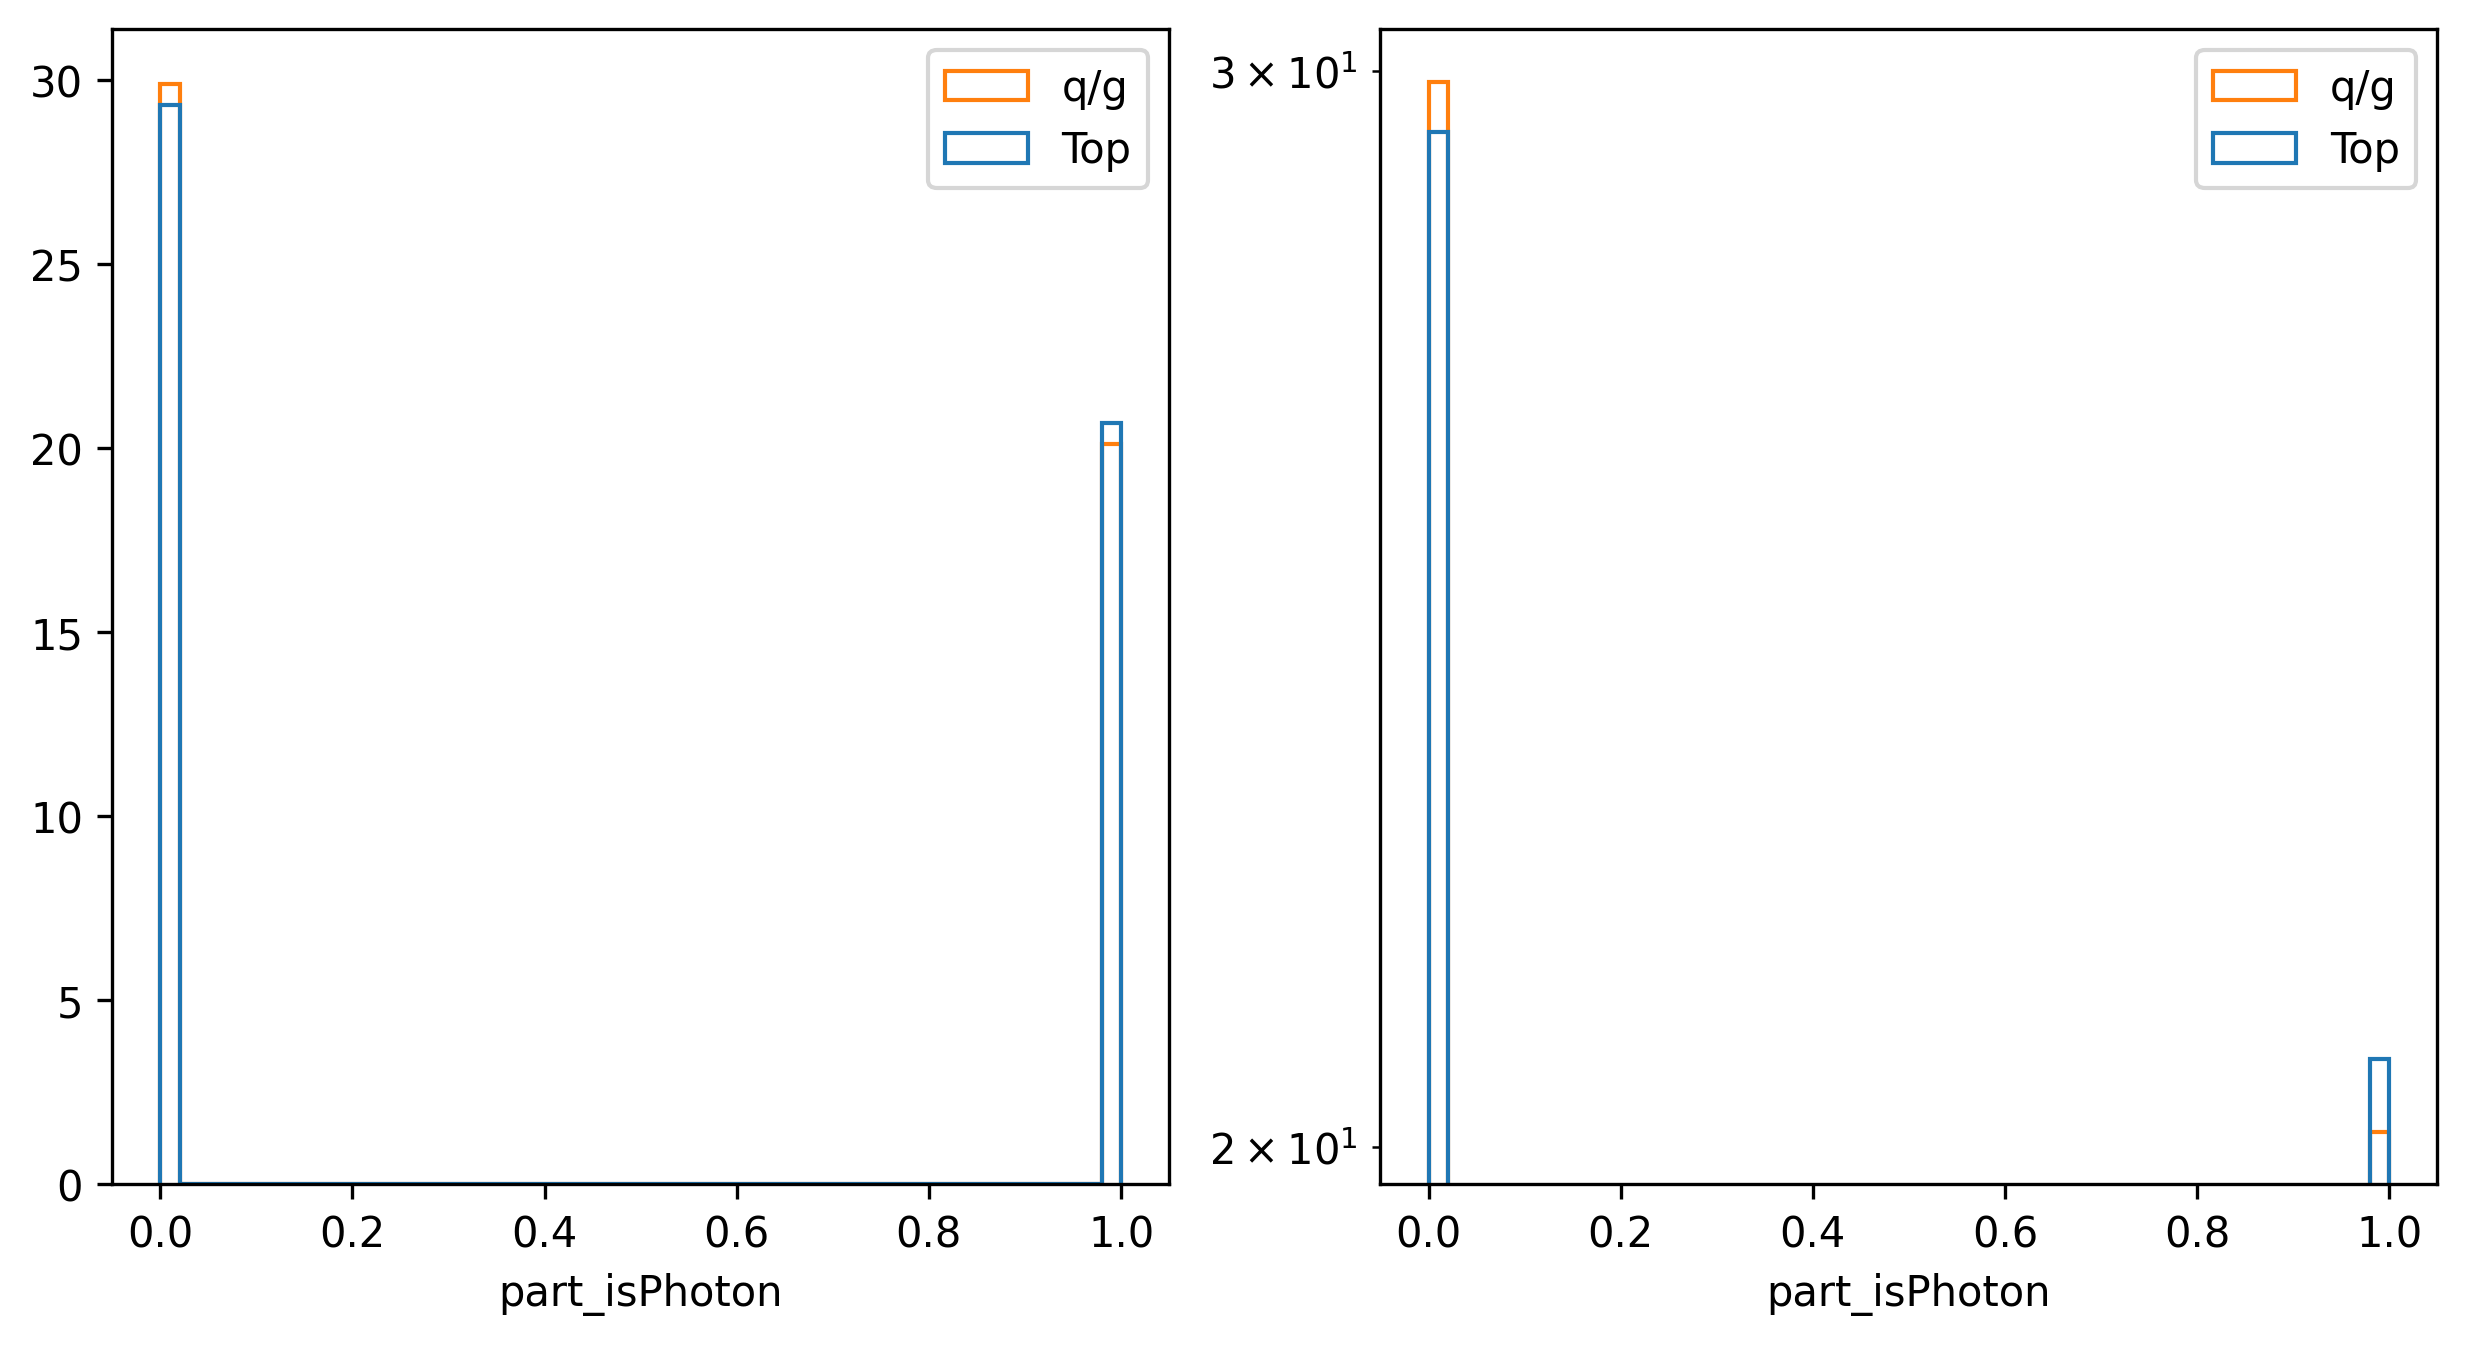

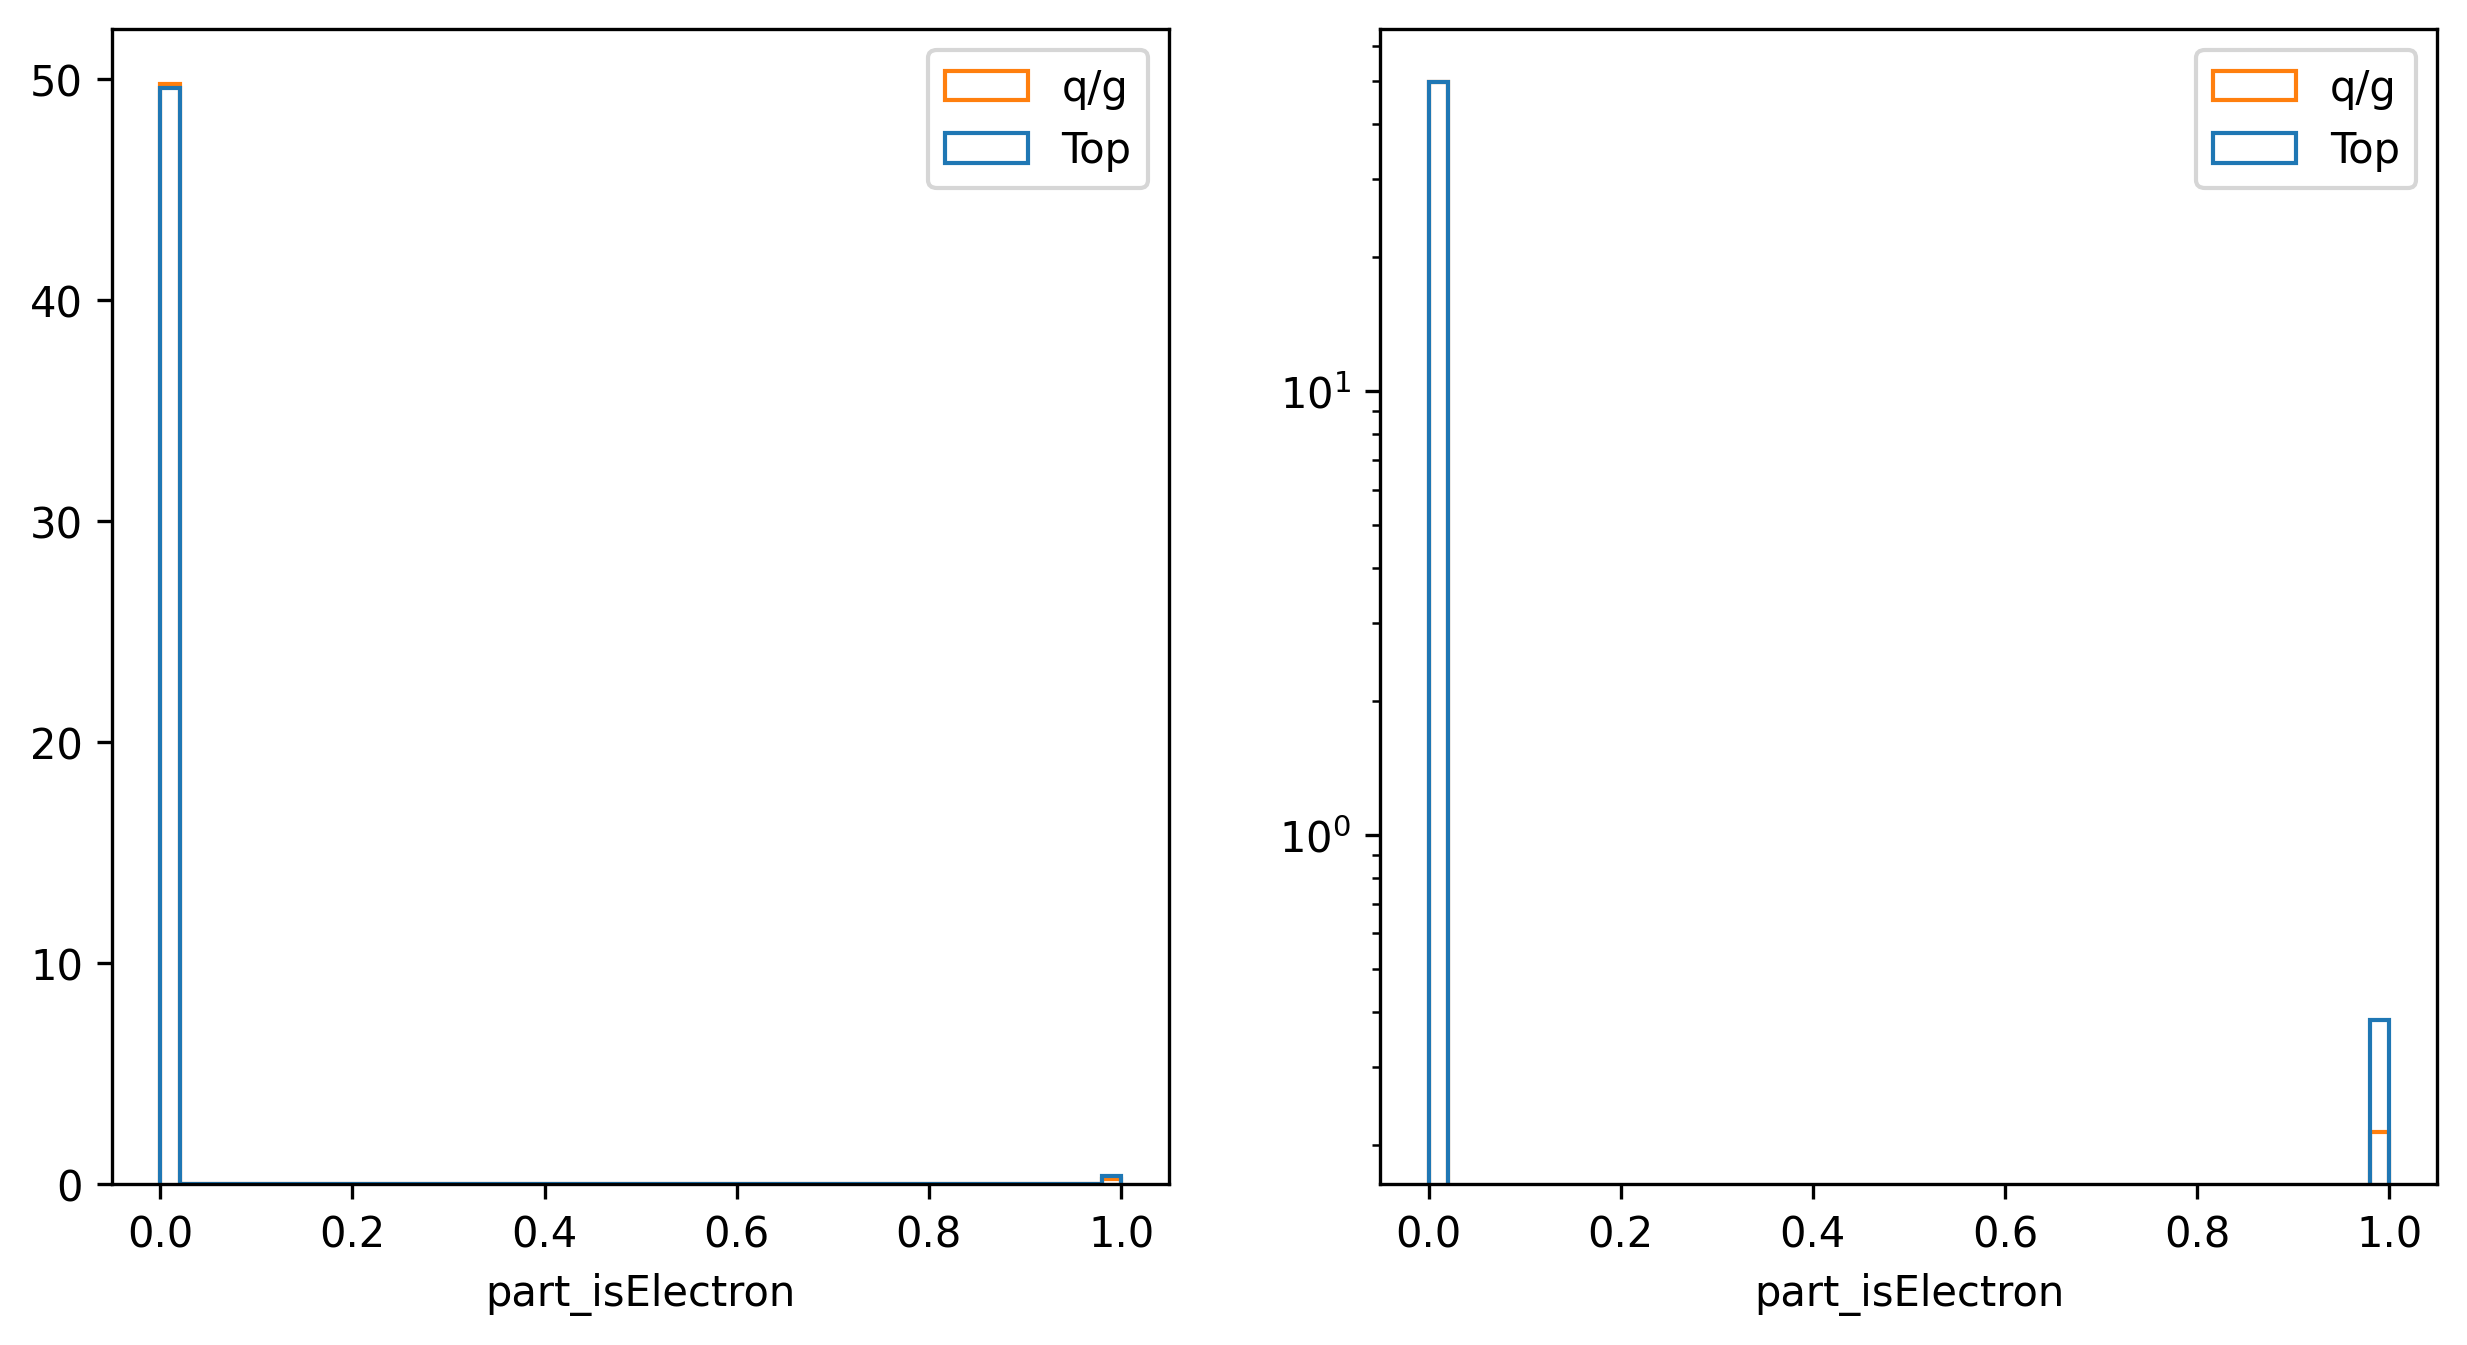

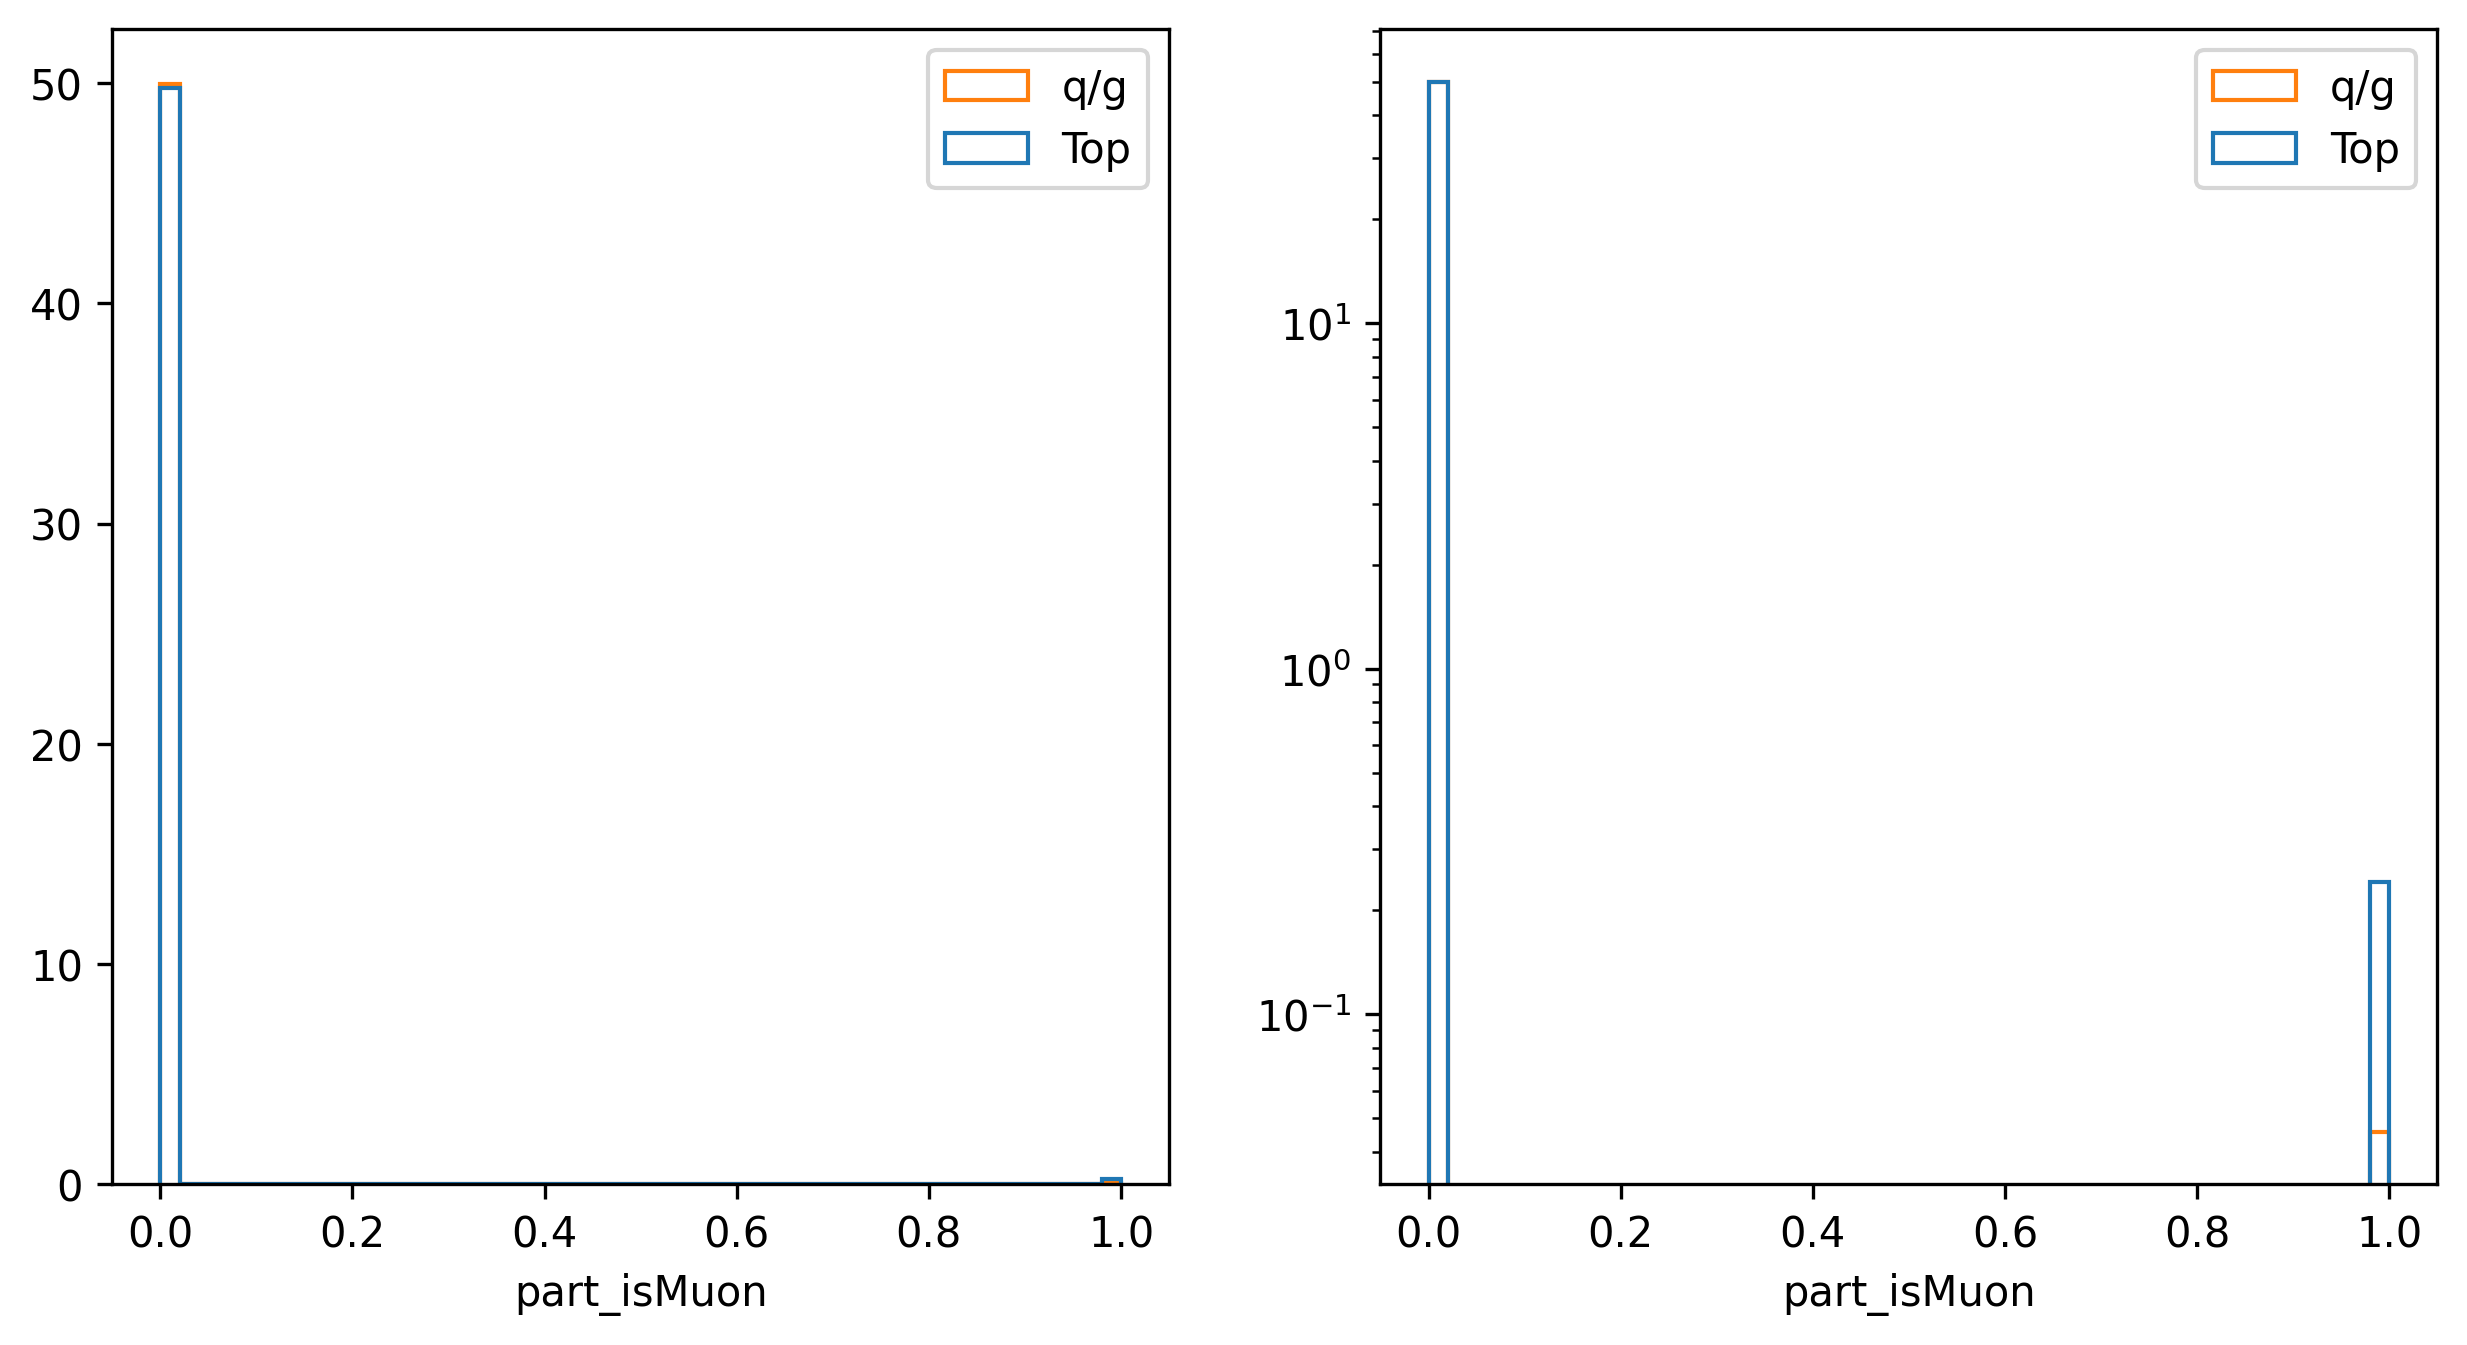

In [20]:
for name in particle_features:
    plot_particle_features(name)


In [22]:
# Construct a Lorentz 4-vector from the (px, py, pz, energy) arrays
def add_features(table):
    table['part_p4'] = vector.zip({'px': table['part_px'],
                                   'py': table['part_py'],
                                   'pz': table['part_pz'],
                                   'energy': table['part_energy']})
    table['part_pt'] = table['part_p4'].pt
    table['part_pt_log'] = np.log(table['part_p4'].pt)


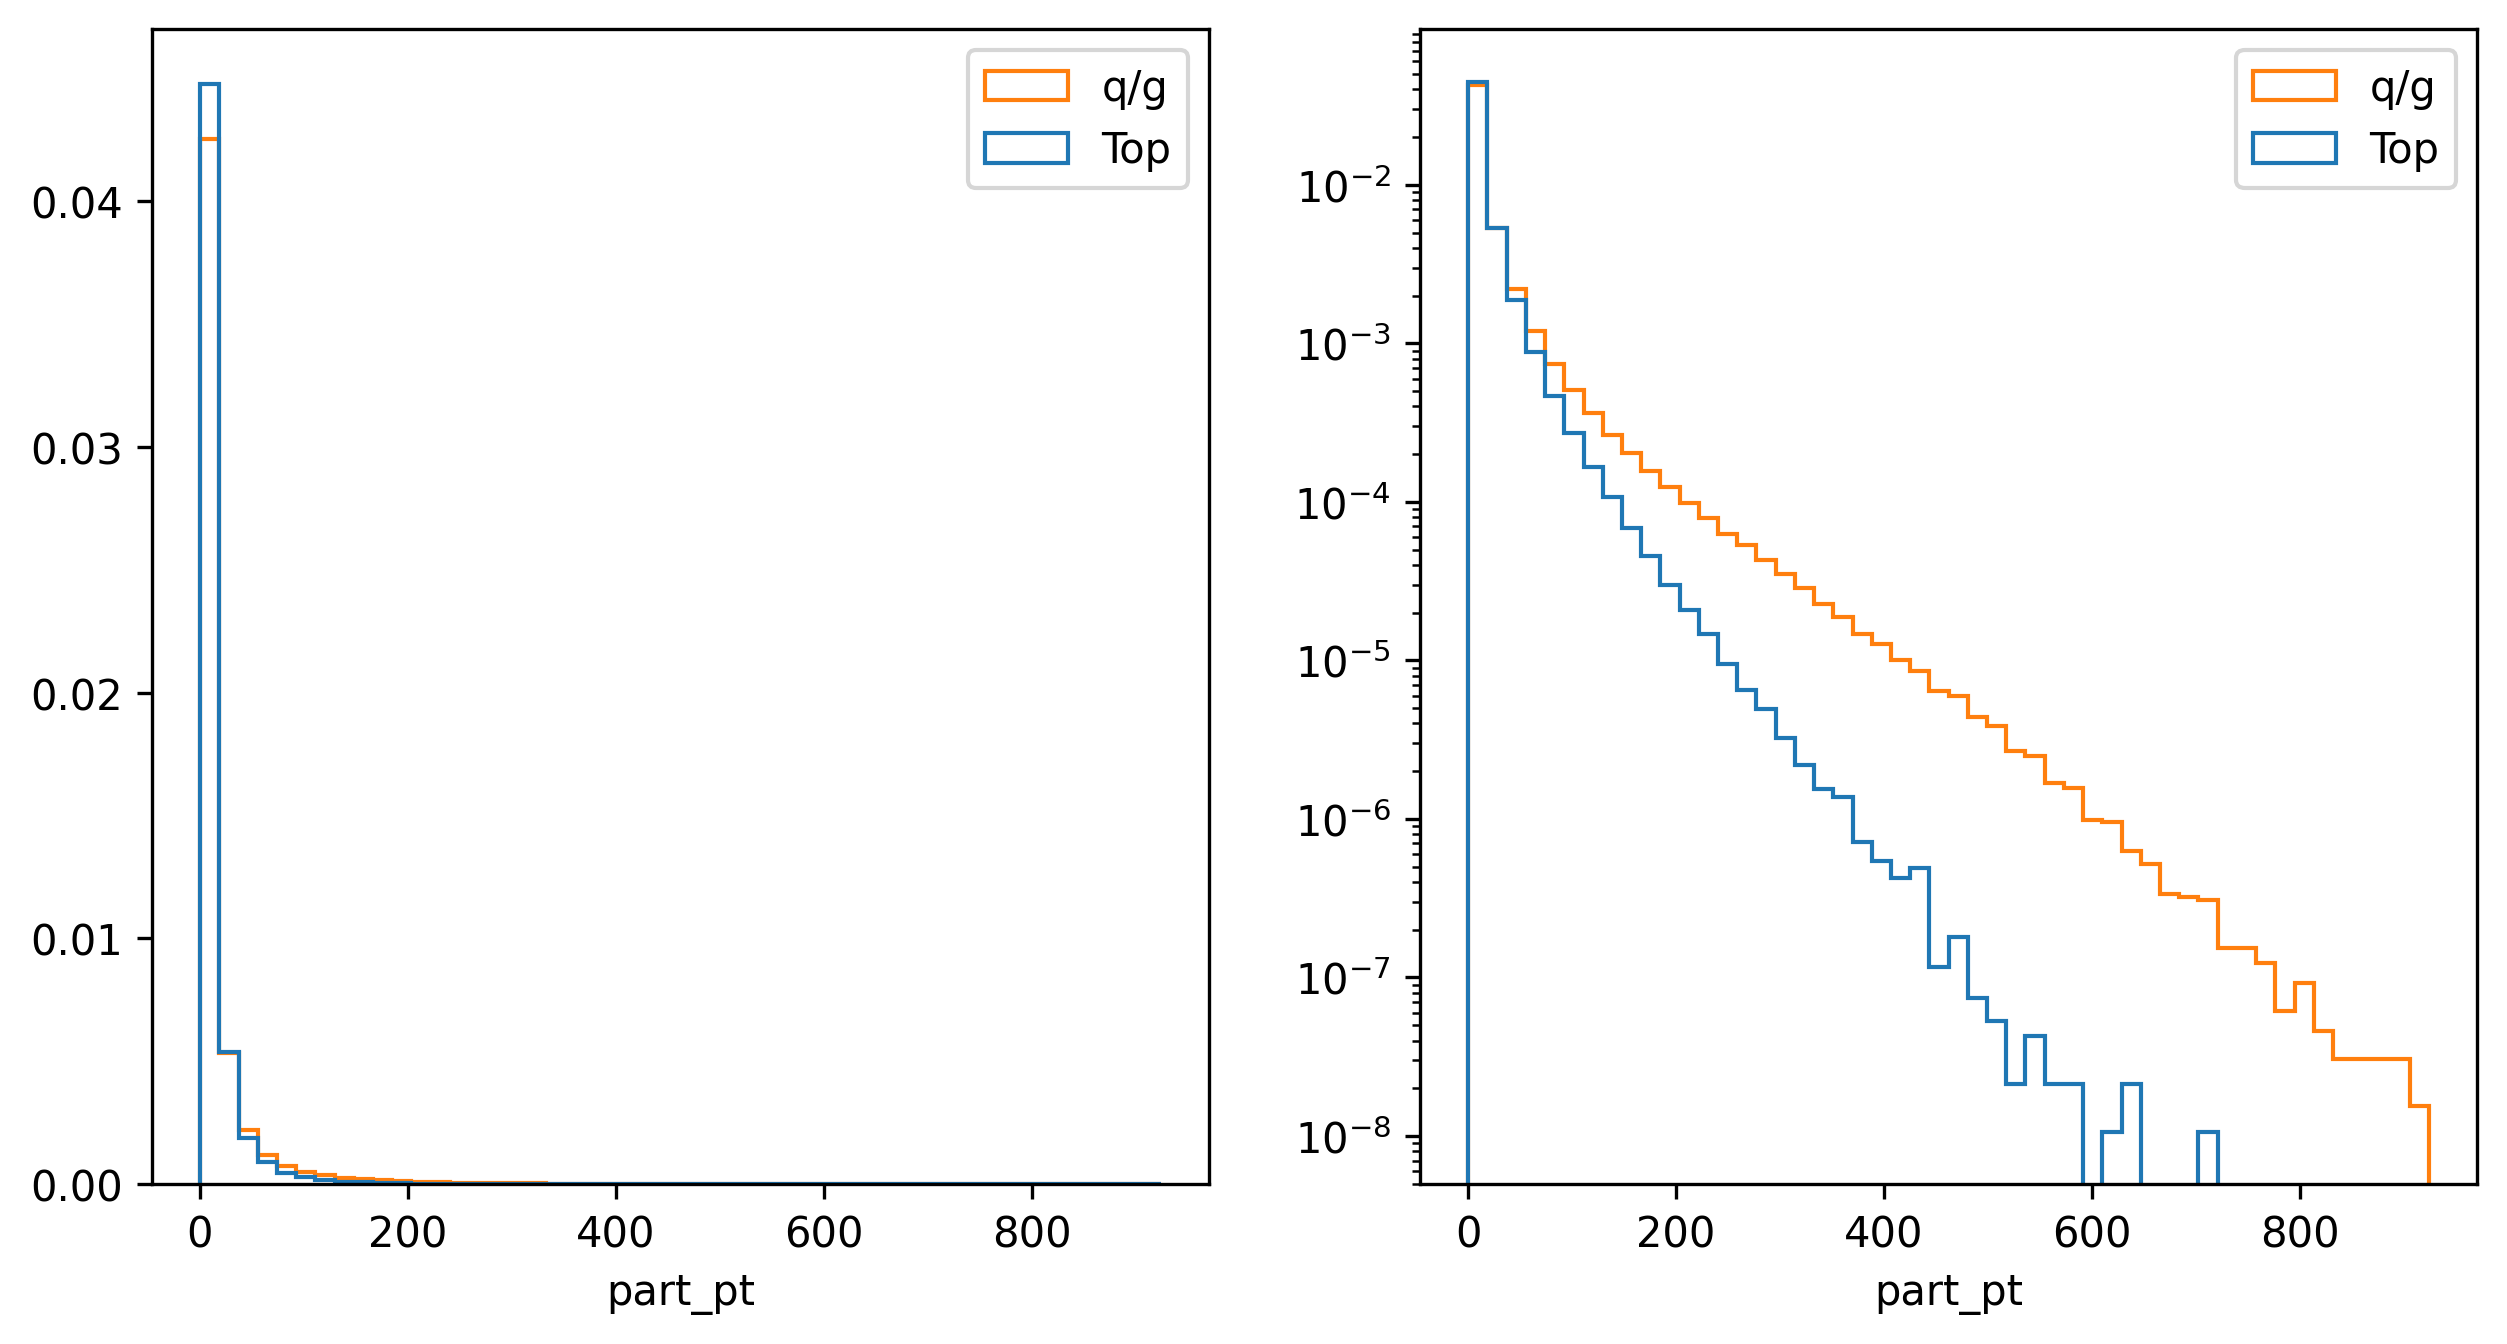

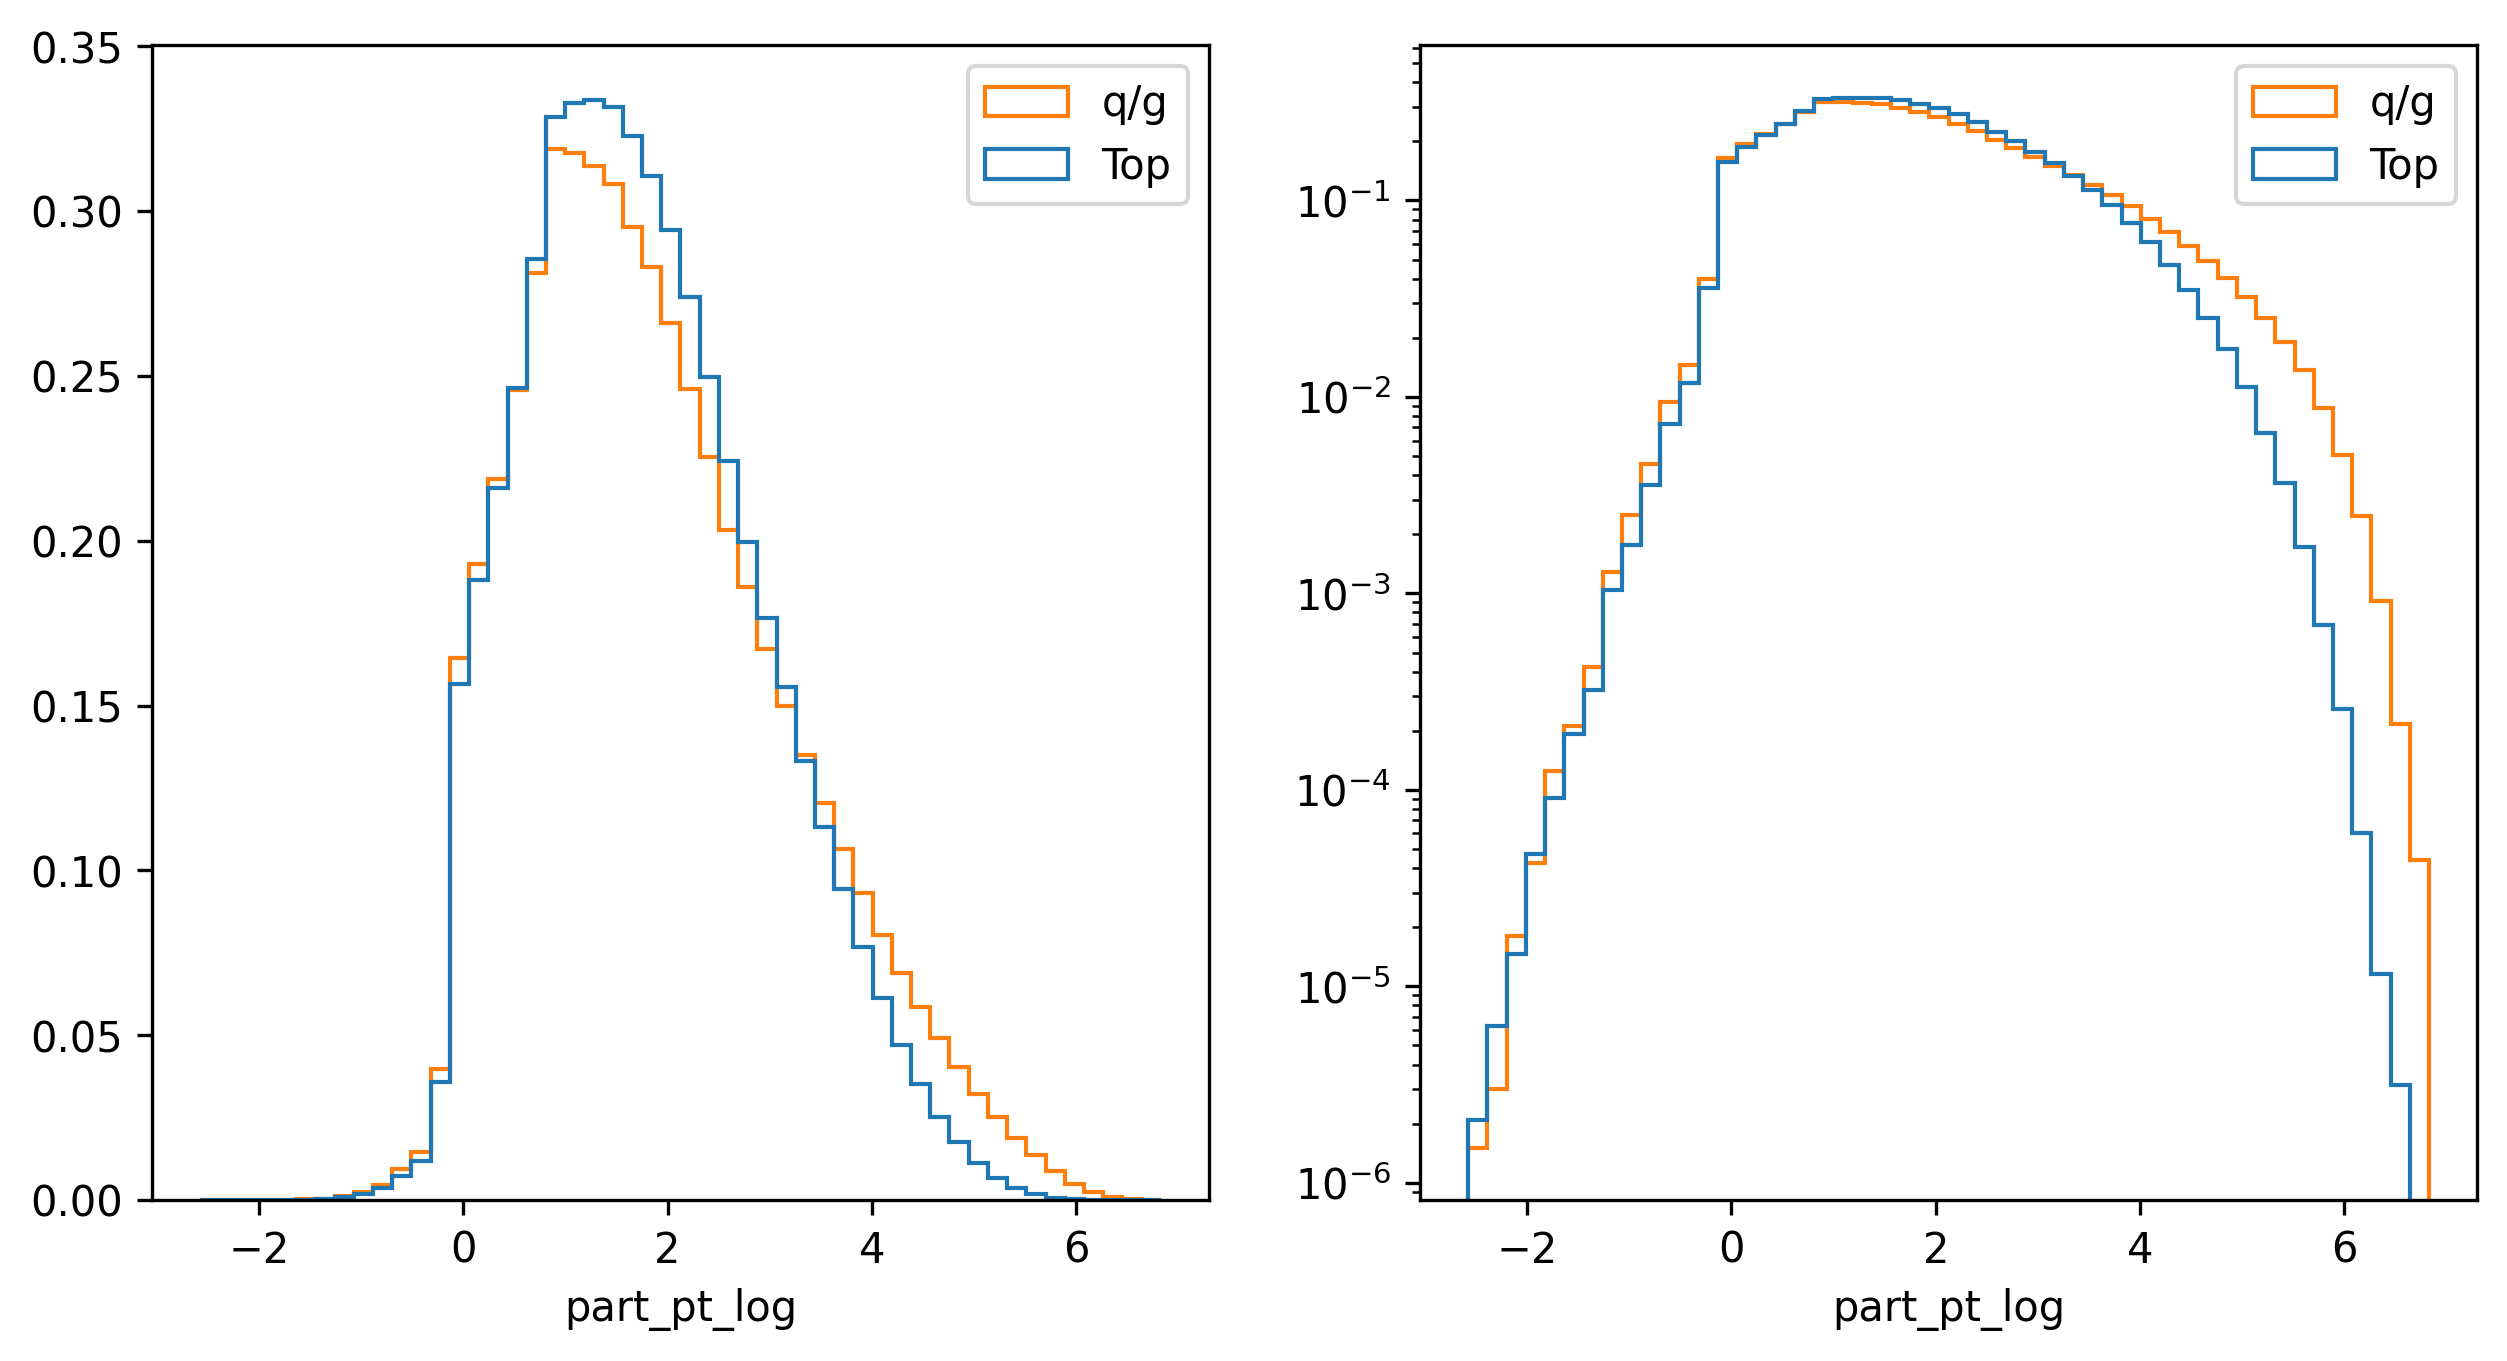

In [23]:
add_features(signal_table)
add_features(background_table)

plot_particle_features('part_pt')
plot_particle_features('part_pt_log')


In addition to the log transformation, another useful transformation is tanh(...), or tanh(const * ...):

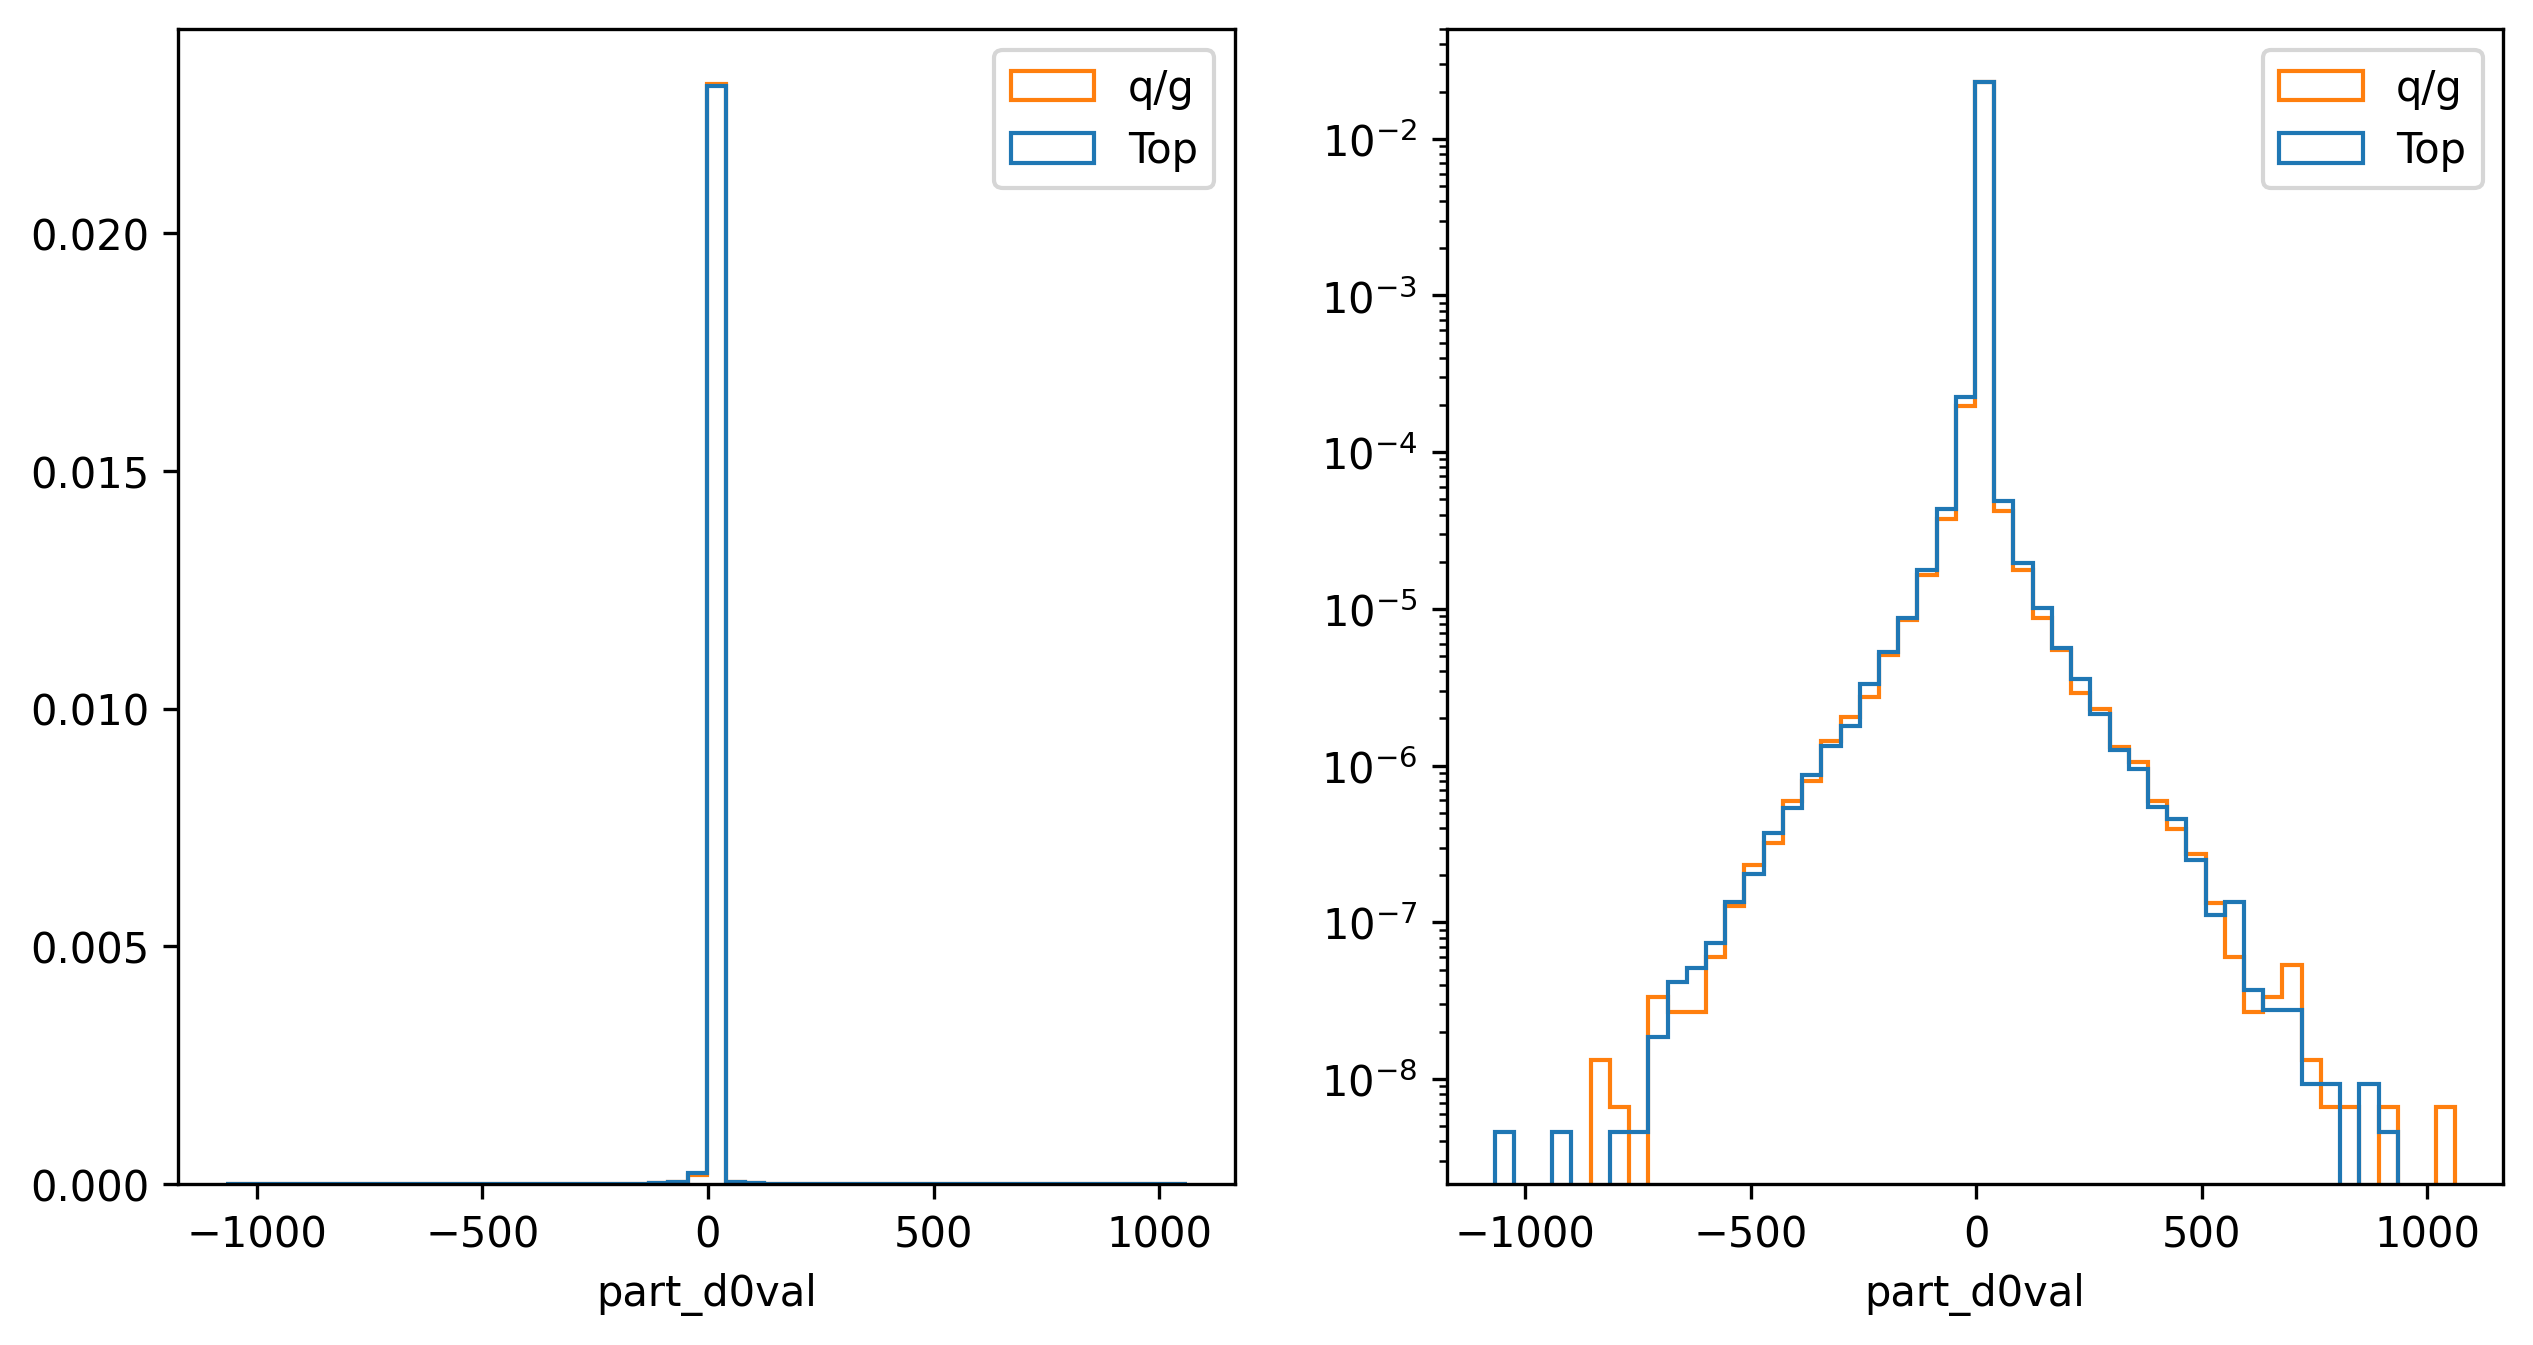

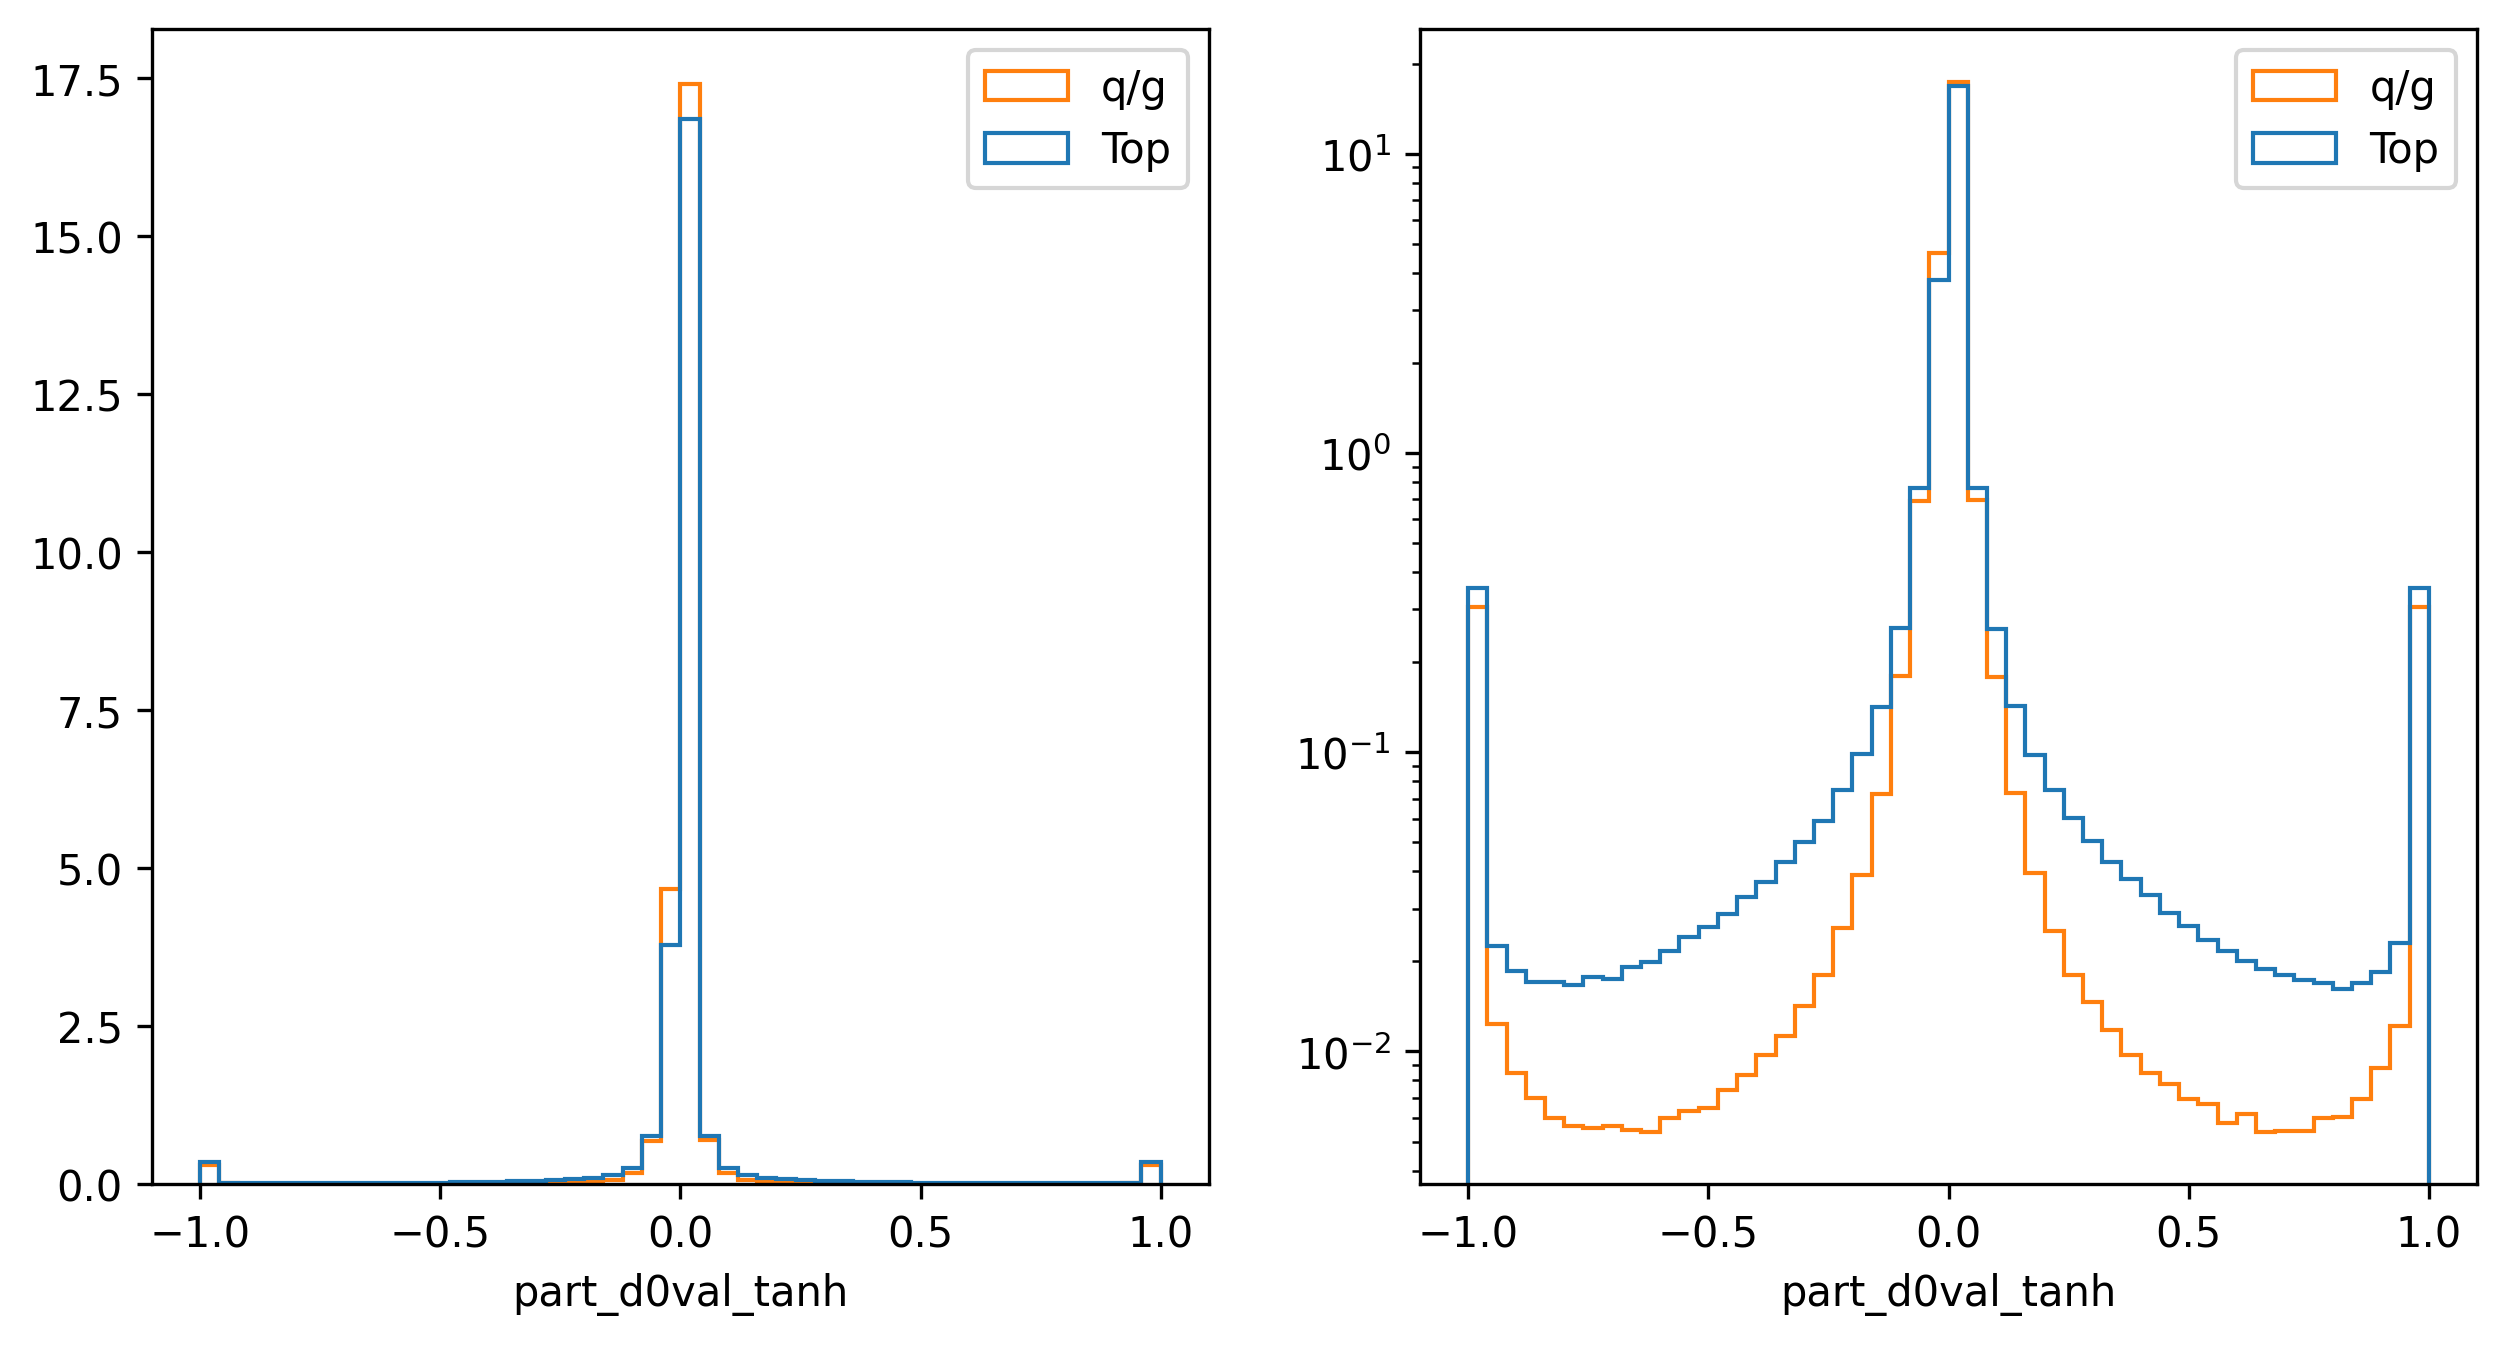

In [24]:
signal_table['part_d0val_tanh'] = np.tanh(signal_table['part_d0val'])
background_table['part_d0val_tanh'] = np.tanh(background_table['part_d0val'])
plot_particle_features('part_d0val')
plot_particle_features('part_d0val_tanh')
